In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf

In [13]:
# global vars
STORE_ID = 1
HIDDEN_NODES=80
EPOCHS=50000
ETA = 0.1

In [14]:
train_df = pd.read_csv("train.csv", low_memory=False)
test_df = pd.read_csv("test.csv")

In [15]:
def preprocess_code(df, store_id):
    # set store id to one store
    df = df[df['Store'] == store_id].reset_index(drop=True)
    #df = df[df['Open'] == 1].reset_index(drop=True)

    # reverse order of dataframe
    df = df.sort_values('Date').reset_index(drop=True)

    columns = df['StateHoliday'].unique().tolist()
    # autoencode StateHoliday
    encoder = OneHotEncoder(sparse_output=False)
    df_holiday = encoder.fit_transform(df[['StateHoliday']])

    # create autoencoder df, append to respective dfs
    df_holiday = pd.DataFrame(df_holiday, columns=columns)
    df = pd.concat([df, df_holiday], axis=1)

    
    return df

In [16]:
train_df = preprocess_code(train_df, STORE_ID)
test_df = preprocess_code(test_df, STORE_ID)

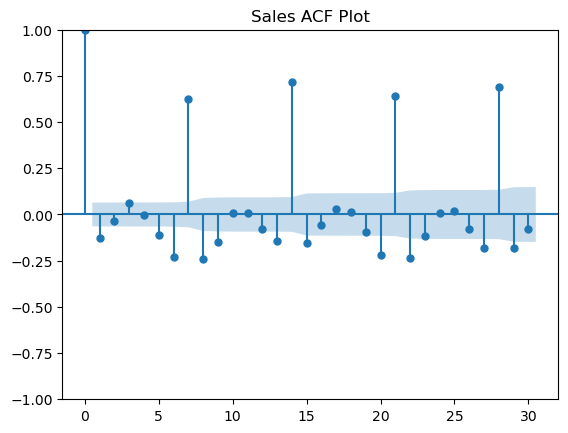

In [17]:
plot_acf(train_df['Sales'], title = 'Sales ACF Plot')
plt.show();

In [18]:
def preprocess_time_series(df, max_lag_percent=0.2):
    # Reset index to ensure datetime is a column
    dff = df.copy().reset_index(drop=False)
    dff["Date"] = pd.to_datetime(dff.Date.values)
    data_length = len(dff)
    max_possible_lag = int(data_length * max_lag_percent)
    max_lag = min(max_possible_lag, 100)  # Set an upper bound

    # Create evenly spaced lag features
    lag_steps = np.linspace(1, max_lag, min(15, max_lag), dtype=int)
    
    # Add specifically important lags based on ACF plot
    important_lags = [1, 7, 14, 21, 28]  # The peaks in your ACF plot
    
    # Combine and deduplicate lag values
    all_lags = np.unique(np.concatenate([lag_steps, important_lags]))
    all_lags = all_lags[all_lags <= max_lag]  # Ensure we don't exceed max_lag
    
    # Create lag features
    for lag in all_lags:
        dff[f"lag_{lag}"] = dff.Sales.shift(lag)
        dff[f"difference_{lag}"] = dff.Sales.diff(periods=lag)
    
    # Add rolling statistics with reasonable windows
    window_sizes = [min(w, max_lag) for w in [7, 14, 28]]
    for window in window_sizes:
        dff[f"rolling_mean_{window}"] = dff.Sales.rolling(window=window).mean()
        dff[f"rolling_std_{window}"] = dff.Sales.rolling(window=window).std()
    
    # Add exponentially weighted features
    for alpha in [0.1, 0.3, 0.5]:
        dff[f"ewm_mean_{int(alpha*100)}"] = dff.Sales.ewm(alpha=alpha).mean()
        dff[f"ewm_std_{int(alpha*100)}"] = dff.Sales.ewm(alpha=alpha).std()
    
    # Categorical time features
    dff["month_of_year"] = dff.Date.dt.month
    dff["is_weekend"] = dff["DayOfWeek"].isin([6, 7]).astype(int)
    
    # Cyclical encoding
    dff["day_sin"] = np.sin(2 * np.pi * dff.DayOfWeek / 7)
    dff["day_cos"] = np.cos(2 * np.pi * dff.DayOfWeek / 7)
    dff["month_sin"] = np.sin(2 * np.pi * dff.month_of_year / 12)
    dff["month_cos"] = np.cos(2 * np.pi * dff.month_of_year / 12)
    
    # Handle NaN values - fill rather than drop
    dff = dff.ffill().bfill()

    return dff


train_df = preprocess_time_series(train_df, max_lag_percent=0.2)
train_X = train_df.drop(columns=['Sales', 'index', 'Date', 'Store', 'StateHoliday', 'month_of_year'], axis=1)
#train_X = train_df.drop(columns= ['Sales', 'Date', 'Store'])
train_y = train_df['Sales']

train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [19]:
train_df.shape

(942, 70)

In [20]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

In [21]:
n_samples, n_features = train_X.shape
    
# Initialize weights with Xavier/Glorot initialization
np.random.seed(42)
W1 = np.random.randn(n_features, HIDDEN_NODES) * np.sqrt(2.0 / n_features)
W2 = np.random.randn(HIDDEN_NODES, 1) * np.sqrt(2.0 / HIDDEN_NODES)


In [22]:
def f(x, W1, W2):
    h = np.maximum(0, W1.T.dot(x))
    result = W2.T.dot(h)
    return result

def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def r_squared(y_true, y_pred):
    num = np.sum((y_true - y_pred) ** 2)
    den = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (num / den)



def train(epochs, X, y, X_test, y_test, W1, W2, eta, l2_reg=0.0001):
    errors = []
    test_errors = []
    n = X.shape[0]
    n_features = X.shape[1]
    n_test = X_test.shape[0]
    
    initial_eta = eta
    
    # Early stopping variables
    best_test_error = float('inf')
    best_epoch = 0
    best_W1 = W1.copy()
    best_W2 = W2.copy()
    
    # Check improvement every 100 epochs
    last_three_errors = []
    max_epochs = min(epochs, 50000)
    
    for epoch in tqdm(range(max_epochs)):
        # Slower decay of learning rate
        current_eta = initial_eta / (1 + epoch / 2000)
        
        # Randomly shuffle data for each epoch
        indices = np.random.permutation(n)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        dW2 = np.zeros_like(W2)
        for i in range(n):
            x = np.reshape(X_shuffled[i], (n_features, 1))
            h = np.maximum(0, W1.T.dot(x))
            pred = f(x, W1, W2)
            dW2 += (2/n) * (pred - y_shuffled[i]) * h
        
        dW2 += l2_reg * W2
        dW2 = np.clip(dW2, -5.0, 5.0)
        W2 = W2 - current_eta * dW2
        
        dW1 = np.zeros_like(W1)
        for i in range(n):
            x = np.reshape(X_shuffled[i], (n_features, 1))
            h = np.maximum(0, W1.T.dot(x))
            mat1 = np.heaviside(h, 0)
            pred = f(x, W1, W2)
            
            error_term = (2/n) * (pred - y_shuffled[i])
            grad_contribution = error_term * np.outer(x, (W2 * mat1).T).reshape(W1.shape)
            dW1 += grad_contribution
        
        dW1 += l2_reg * W1
        dW1 = np.clip(dW1, -5.0, 5.0)
        W1 = W1 - current_eta * dW1
        
        if epoch % 50 == 0 or epoch == max_epochs - 1:
            # Calculate error for monitoring
            predictions = np.array([f(np.reshape(X[i], (n_features, 1)), W1, W2)[0,0] for i in range(n)])
            val_predictions = np.array([f(np.reshape(X_test[i], (n_features, 1)), W1, W2)[0, 0] for i in range(n_test)])
            e = mse(y, predictions)
            val_mse = mse(y_test, val_predictions)
            val_rmse = rmse(y_test, val_predictions)
            val_mae = mae(y_test, val_predictions)
            val_r2 = r_squared(y_test, val_predictions)
            errors.append(e)
            test_errors.append(val_mse)
            
            # More detailed progress reporting
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Error: {e:.6f}, Learning rate: {current_eta:.6f}")
                print(f"Test MAE: {val_mae:.6f}")
                print(f"Test MSE: {val_mse:.6f}")
                print(f"Test RMSE: {val_rmse:.6f}")
                print(f"Test R-Squared: {val_r2:.4f}")
                
                
                # Print some sample comparisons
                sample_indices = np.random.choice(len(y), 3, replace=False)
                for idx in sample_indices:
                    print(f"Sample {idx}: Prediction={predictions[idx]:.2f}, Target={y[idx]}")
                
                # Early stopping check every 100 epochs
                if val_mse < best_test_error:
                    best_test_error = val_mse
                    best_epoch = epoch
                    best_W1 = W1.copy()
                    best_W2 = W2.copy()
                
                # Add current error to last three for tracking improvement
                last_three_errors.append(val_mse)
                if len(last_three_errors) > 5:
                    last_three_errors.pop(0)  # Keep only the last three
                
                # Check if no improvement for three consecutive 100-epoch intervals
                if len(last_three_errors) == 3 and all(last_three_errors[i] >= last_three_errors[i-1] for i in range(1, 3)):
                    print(f"\nEarly stopping at epoch {epoch}. No improvement for 300 epochs.")
                    print(f"Best validation MSE: {best_test_error:.6f} at epoch {best_epoch}")
                    break
    
    # Use the best weights found during training
    W1, W2 = best_W1, best_W2
    
    # Final predictions using best weights
    final_predictions = np.array([f(np.reshape(X[i], (n_features, 1)), W1, W2)[0,0] for i in range(n)])
    test_predictions = np.array([f(np.reshape(X_test[i], (n_features, 1)), W1, W2)[0,0] for i in range(n_test)])
        
    return W1, W2, errors, test_errors, final_predictions, test_predictions

# run training
W1, W2, train_errors, test_errors, train_predictions, test_predictions = train(EPOCHS, train_X, train_y, val_X, val_y, W1, W2, ETA, l2_reg=0.0001)


  0%|                                         | 7/50000 [00:00<27:04, 30.77it/s]

Epoch 0, Error: 17517807.466176, Learning rate: 0.100000
Test MAE: 3830.250447
Test MSE: 17678993.995611
Test RMSE: 4204.639580
Test R-Squared: -4.1115
Sample 52: Prediction=77.32, Target=3806
Sample 522: Prediction=94.93, Target=4212
Sample 142: Prediction=31.82, Target=0


  0%|                                       | 107/50000 [00:03<26:18, 31.61it/s]

Epoch 100, Error: 412504.903892, Learning rate: 0.095238
Test MAE: 554.256232
Test MSE: 555720.127906
Test RMSE: 745.466383
Test R-Squared: 0.8393
Sample 727: Prediction=4704.20, Target=4602
Sample 180: Prediction=3.77, Target=0
Sample 361: Prediction=5834.85, Target=5363


  0%|▏                                      | 207/50000 [00:06<26:17, 31.56it/s]

Epoch 200, Error: 382830.588921, Learning rate: 0.090909
Test MAE: 541.575245
Test MSE: 524689.550720
Test RMSE: 724.354575
Test R-Squared: 0.8483
Sample 195: Prediction=4967.47, Target=4652
Sample 167: Prediction=3217.17, Target=4178
Sample 646: Prediction=4800.31, Target=5688


  1%|▏                                      | 307/50000 [00:09<26:39, 31.07it/s]

Epoch 300, Error: 371259.800808, Learning rate: 0.086957
Test MAE: 542.942590
Test MSE: 523982.638269
Test RMSE: 723.866451
Test R-Squared: 0.8485
Sample 549: Prediction=6628.26, Target=6148
Sample 52: Prediction=4656.12, Target=3806
Sample 135: Prediction=5649.28, Target=7176


  1%|▎                                      | 407/50000 [00:12<26:15, 31.48it/s]

Epoch 400, Error: 357698.038970, Learning rate: 0.083333
Test MAE: 543.415148
Test MSE: 513263.085790
Test RMSE: 716.423817
Test R-Squared: 0.8516
Sample 428: Prediction=27.89, Target=0
Sample 433: Prediction=7153.92, Target=6532
Sample 482: Prediction=3904.31, Target=3919


  1%|▍                                      | 507/50000 [00:16<26:08, 31.55it/s]

Epoch 500, Error: 349074.154127, Learning rate: 0.080000
Test MAE: 540.280486
Test MSE: 503792.516724
Test RMSE: 709.783429
Test R-Squared: 0.8543
Sample 339: Prediction=4734.76, Target=3875
Sample 748: Prediction=4173.31, Target=3649
Sample 9: Prediction=5423.84, Target=5346


  1%|▍                                      | 607/50000 [00:19<26:04, 31.57it/s]

Epoch 600, Error: 338222.393104, Learning rate: 0.076923
Test MAE: 539.313895
Test MSE: 500843.065010
Test RMSE: 707.702667
Test R-Squared: 0.8552
Sample 88: Prediction=5969.98, Target=5518
Sample 651: Prediction=6238.46, Target=6454
Sample 428: Prediction=102.01, Target=0


  1%|▌                                      | 707/50000 [00:22<25:55, 31.69it/s]

Epoch 700, Error: 329800.844553, Learning rate: 0.074074
Test MAE: 537.015811
Test MSE: 497587.140211
Test RMSE: 705.398568
Test R-Squared: 0.8561
Sample 65: Prediction=6122.29, Target=5162
Sample 695: Prediction=3924.14, Target=3706
Sample 130: Prediction=3480.41, Target=3582


  2%|▋                                      | 807/50000 [00:25<25:55, 31.63it/s]

Epoch 800, Error: 321806.986186, Learning rate: 0.071429
Test MAE: 534.926565
Test MSE: 495056.755321
Test RMSE: 703.602697
Test R-Squared: 0.8569
Sample 43: Prediction=5436.24, Target=5603
Sample 201: Prediction=5184.54, Target=4128
Sample 662: Prediction=3406.68, Target=2605


  2%|▋                                      | 907/50000 [00:28<25:47, 31.72it/s]

Epoch 900, Error: 314337.689352, Learning rate: 0.068966
Test MAE: 536.277166
Test MSE: 494739.437498
Test RMSE: 703.377166
Test R-Squared: 0.8570
Sample 333: Prediction=892.67, Target=0
Sample 603: Prediction=6349.63, Target=6057
Sample 559: Prediction=40.01, Target=0


  2%|▊                                     | 1007/50000 [00:31<25:50, 31.59it/s]

Epoch 1000, Error: 308853.932152, Learning rate: 0.066667
Test MAE: 535.741511
Test MSE: 493289.518239
Test RMSE: 702.345726
Test R-Squared: 0.8574
Sample 274: Prediction=5466.49, Target=5578
Sample 362: Prediction=2892.20, Target=3662
Sample 721: Prediction=4939.39, Target=4599


  2%|▊                                     | 1107/50000 [00:34<25:54, 31.45it/s]

Epoch 1100, Error: 303112.940072, Learning rate: 0.064516
Test MAE: 534.902876
Test MSE: 492268.778291
Test RMSE: 701.618684
Test R-Squared: 0.8577
Sample 510: Prediction=4589.83, Target=3680
Sample 483: Prediction=5040.90, Target=5058
Sample 133: Prediction=5158.84, Target=4789


  2%|▉                                     | 1207/50000 [00:38<25:42, 31.63it/s]

Epoch 1200, Error: 294987.059313, Learning rate: 0.062500
Test MAE: 533.053058
Test MSE: 482404.336559
Test RMSE: 694.553336
Test R-Squared: 0.8605
Sample 666: Prediction=7121.25, Target=6574
Sample 206: Prediction=4783.81, Target=3836
Sample 308: Prediction=4391.28, Target=3906


  3%|▉                                     | 1307/50000 [00:41<25:41, 31.59it/s]

Epoch 1300, Error: 289916.316975, Learning rate: 0.060606
Test MAE: 532.222216
Test MSE: 481563.422638
Test RMSE: 693.947709
Test R-Squared: 0.8608
Sample 240: Prediction=5473.41, Target=4366
Sample 472: Prediction=5708.43, Target=5176
Sample 304: Prediction=5894.74, Target=5106


  3%|█                                     | 1407/50000 [00:44<25:46, 31.43it/s]

Epoch 1400, Error: 285474.181012, Learning rate: 0.058824
Test MAE: 530.070453
Test MSE: 478307.467453
Test RMSE: 691.597764
Test R-Squared: 0.8617
Sample 236: Prediction=96.22, Target=0
Sample 387: Prediction=-74.69, Target=0
Sample 259: Prediction=3618.25, Target=3076


  3%|█▏                                    | 1507/50000 [00:47<25:46, 31.35it/s]

Epoch 1500, Error: 281818.342301, Learning rate: 0.057143
Test MAE: 529.939682
Test MSE: 477774.273885
Test RMSE: 691.212177
Test R-Squared: 0.8619
Sample 615: Prediction=4961.18, Target=4055
Sample 152: Prediction=5240.92, Target=4409
Sample 541: Prediction=4602.48, Target=4318


  3%|█▏                                    | 1607/50000 [00:50<25:33, 31.56it/s]

Epoch 1600, Error: 271299.040604, Learning rate: 0.055556
Test MAE: 520.305994
Test MSE: 458721.000575
Test RMSE: 677.289451
Test R-Squared: 0.8674
Sample 494: Prediction=4824.49, Target=5031
Sample 444: Prediction=6634.53, Target=6239
Sample 204: Prediction=4927.80, Target=4735


  3%|█▎                                    | 1707/50000 [00:53<25:37, 31.42it/s]

Epoch 1700, Error: 262672.616844, Learning rate: 0.054054
Test MAE: 515.698771
Test MSE: 448893.086254
Test RMSE: 669.994840
Test R-Squared: 0.8702
Sample 242: Prediction=5142.65, Target=4407
Sample 686: Prediction=4667.50, Target=4303
Sample 190: Prediction=6197.06, Target=5173


  4%|█▎                                    | 1806/50000 [00:57<25:47, 31.14it/s]

Epoch 1800, Error: 259076.166728, Learning rate: 0.052632
Test MAE: 513.866259
Test MSE: 445568.473067
Test RMSE: 667.509156
Test R-Squared: 0.8712
Sample 581: Prediction=5009.94, Target=5075
Sample 535: Prediction=4961.77, Target=3703
Sample 125: Prediction=4936.32, Target=4150


  4%|█▍                                    | 1906/50000 [01:00<25:55, 30.91it/s]

Epoch 1900, Error: 256024.218424, Learning rate: 0.051282
Test MAE: 512.617224
Test MSE: 443296.045496
Test RMSE: 665.804810
Test R-Squared: 0.8718
Sample 197: Prediction=2863.82, Target=3650
Sample 276: Prediction=4158.98, Target=3768
Sample 79: Prediction=4366.12, Target=4111


  4%|█▌                                    | 2006/50000 [01:03<25:41, 31.14it/s]

Epoch 2000, Error: 252631.286229, Learning rate: 0.050000
Test MAE: 512.916478
Test MSE: 443518.306665
Test RMSE: 665.971701
Test R-Squared: 0.8718
Sample 568: Prediction=5712.45, Target=5317
Sample 241: Prediction=6614.79, Target=6198
Sample 705: Prediction=4528.07, Target=4685


  4%|█▌                                    | 2106/50000 [01:06<25:19, 31.53it/s]

Epoch 2100, Error: 249864.903611, Learning rate: 0.048780
Test MAE: 512.715113
Test MSE: 443130.680483
Test RMSE: 665.680614
Test R-Squared: 0.8719
Sample 221: Prediction=5937.21, Target=6293
Sample 420: Prediction=2999.39, Target=3141
Sample 295: Prediction=6146.43, Target=5701


  4%|█▋                                    | 2206/50000 [01:09<25:26, 31.31it/s]

Epoch 2200, Error: 247327.646011, Learning rate: 0.047619
Test MAE: 512.776549
Test MSE: 442781.049717
Test RMSE: 665.417951
Test R-Squared: 0.8720
Sample 57: Prediction=4245.42, Target=3959
Sample 73: Prediction=3627.65, Target=3565
Sample 563: Prediction=152.63, Target=0


  5%|█▊                                    | 2306/50000 [01:13<25:15, 31.46it/s]

Epoch 2300, Error: 243326.795644, Learning rate: 0.046512
Test MAE: 509.270870
Test MSE: 437234.529074
Test RMSE: 661.237120
Test R-Squared: 0.8736
Sample 646: Prediction=4816.63, Target=5688
Sample 587: Prediction=162.11, Target=0
Sample 183: Prediction=68.49, Target=0


  5%|█▊                                    | 2406/50000 [01:16<25:14, 31.43it/s]

Epoch 2400, Error: 234360.621603, Learning rate: 0.045455
Test MAE: 499.138933
Test MSE: 417027.041670
Test RMSE: 645.776309
Test R-Squared: 0.8794
Sample 742: Prediction=5239.03, Target=4435
Sample 201: Prediction=4983.61, Target=4128
Sample 158: Prediction=4131.80, Target=3785


  5%|█▉                                    | 2505/50000 [01:19<26:30, 29.86it/s]

Epoch 2500, Error: 230025.439387, Learning rate: 0.044444
Test MAE: 498.116441
Test MSE: 413956.254826
Test RMSE: 643.394323
Test R-Squared: 0.8803
Sample 95: Prediction=4191.05, Target=3982
Sample 49: Prediction=87.05, Target=0
Sample 418: Prediction=6406.39, Target=6196


  5%|█▉                                    | 2605/50000 [01:22<25:05, 31.47it/s]

Epoch 2600, Error: 226529.283644, Learning rate: 0.043478
Test MAE: 495.974320
Test MSE: 410430.608987
Test RMSE: 640.648585
Test R-Squared: 0.8813
Sample 336: Prediction=8612.33, Target=8277
Sample 510: Prediction=4482.39, Target=3680
Sample 6: Prediction=5545.00, Target=5263


  5%|██                                    | 2705/50000 [01:25<25:39, 30.72it/s]

Epoch 2700, Error: 223650.013801, Learning rate: 0.042553
Test MAE: 494.772819
Test MSE: 407851.444869
Test RMSE: 638.632480
Test R-Squared: 0.8821
Sample 567: Prediction=7720.07, Target=6660
Sample 719: Prediction=5691.66, Target=5720
Sample 525: Prediction=3952.78, Target=3957


  6%|██▏                                   | 2805/50000 [01:29<26:01, 30.23it/s]

Epoch 2800, Error: 220421.485380, Learning rate: 0.041667
Test MAE: 493.914613
Test MSE: 404352.828534
Test RMSE: 635.887434
Test R-Squared: 0.8831
Sample 0: Prediction=45.92, Target=0
Sample 602: Prediction=5390.77, Target=5138
Sample 273: Prediction=5240.29, Target=4663


  6%|██▏                                   | 2905/50000 [01:32<25:28, 30.81it/s]

Epoch 2900, Error: 218040.243855, Learning rate: 0.040816
Test MAE: 494.167249
Test MSE: 403770.174263
Test RMSE: 635.429126
Test R-Squared: 0.8833
Sample 168: Prediction=5087.99, Target=5190
Sample 472: Prediction=5718.67, Target=5176
Sample 159: Prediction=4609.51, Target=4757


  6%|██▎                                   | 3005/50000 [01:35<24:57, 31.39it/s]

Epoch 3000, Error: 216163.435476, Learning rate: 0.040000
Test MAE: 493.829337
Test MSE: 402837.428509
Test RMSE: 634.694752
Test R-Squared: 0.8835
Sample 655: Prediction=5625.15, Target=5407
Sample 444: Prediction=6645.46, Target=6239
Sample 97: Prediction=5241.17, Target=5083


  6%|██▎                                   | 3105/50000 [01:38<25:07, 31.11it/s]

Epoch 3100, Error: 214544.668101, Learning rate: 0.039216
Test MAE: 493.723857
Test MSE: 402887.971045
Test RMSE: 634.734567
Test R-Squared: 0.8835
Sample 44: Prediction=3650.49, Target=3773
Sample 719: Prediction=5688.99, Target=5720
Sample 614: Prediction=4733.62, Target=4790


  6%|██▍                                   | 3205/50000 [01:41<24:51, 31.38it/s]

Epoch 3200, Error: 212538.960399, Learning rate: 0.038462
Test MAE: 492.354017
Test MSE: 400922.747268
Test RMSE: 633.184608
Test R-Squared: 0.8841
Sample 470: Prediction=-93.49, Target=0
Sample 713: Prediction=4285.75, Target=4676
Sample 678: Prediction=3724.28, Target=4574


  7%|██▌                                   | 3305/50000 [01:44<24:42, 31.50it/s]

Epoch 3300, Error: 209517.481568, Learning rate: 0.037736
Test MAE: 490.012709
Test MSE: 396963.990716
Test RMSE: 630.050784
Test R-Squared: 0.8852
Sample 663: Prediction=4483.23, Target=4823
Sample 410: Prediction=5569.25, Target=4796
Sample 288: Prediction=5876.16, Target=5482


  7%|██▌                                   | 3405/50000 [01:48<25:30, 30.44it/s]

Epoch 3400, Error: 204280.532075, Learning rate: 0.037037
Test MAE: 485.986941
Test MSE: 390598.566477
Test RMSE: 624.978853
Test R-Squared: 0.8871
Sample 48: Prediction=4598.88, Target=4163
Sample 741: Prediction=4341.67, Target=4461
Sample 351: Prediction=9599.05, Target=8414


  7%|██▋                                   | 3505/50000 [01:51<24:44, 31.31it/s]

Epoch 3500, Error: 195411.539019, Learning rate: 0.036364
Test MAE: 476.016315
Test MSE: 374523.751199
Test RMSE: 611.983457
Test R-Squared: 0.8917
Sample 353: Prediction=3942.15, Target=4030
Sample 482: Prediction=3895.22, Target=3919
Sample 639: Prediction=5495.65, Target=5222


  7%|██▋                                   | 3605/50000 [01:54<25:12, 30.67it/s]

Epoch 3600, Error: 189154.461025, Learning rate: 0.035714
Test MAE: 465.093035
Test MSE: 355409.767085
Test RMSE: 596.162534
Test R-Squared: 0.8972
Sample 344: Prediction=6544.67, Target=5471
Sample 146: Prediction=-72.67, Target=0
Sample 485: Prediction=5996.61, Target=5912


  7%|██▊                                   | 3706/50000 [01:57<26:14, 29.40it/s]

Epoch 3700, Error: 184743.692129, Learning rate: 0.035088
Test MAE: 460.040722
Test MSE: 347369.304529
Test RMSE: 589.380441
Test R-Squared: 0.8996
Sample 464: Prediction=4101.87, Target=3516
Sample 297: Prediction=4478.07, Target=4042
Sample 127: Prediction=3477.93, Target=3901


  8%|██▉                                   | 3806/50000 [02:01<25:09, 30.60it/s]

Epoch 3800, Error: 181541.575487, Learning rate: 0.034483
Test MAE: 458.026710
Test MSE: 343988.570724
Test RMSE: 586.505388
Test R-Squared: 0.9005
Sample 19: Prediction=5718.47, Target=5242
Sample 253: Prediction=103.65, Target=0
Sample 42: Prediction=3696.15, Target=3591


  8%|██▉                                   | 3906/50000 [02:04<24:36, 31.22it/s]

Epoch 3900, Error: 179230.026558, Learning rate: 0.033898
Test MAE: 455.613870
Test MSE: 340869.544348
Test RMSE: 583.840341
Test R-Squared: 0.9014
Sample 448: Prediction=5116.69, Target=4726
Sample 339: Prediction=4480.10, Target=3875
Sample 637: Prediction=4093.38, Target=4881


  8%|███                                   | 4005/50000 [02:07<24:21, 31.47it/s]

Epoch 4000, Error: 177494.585373, Learning rate: 0.033333
Test MAE: 455.576460
Test MSE: 339833.194720
Test RMSE: 582.952138
Test R-Squared: 0.9017
Sample 619: Prediction=3794.34, Target=3900
Sample 246: Prediction=4963.43, Target=3680
Sample 610: Prediction=-32.01, Target=0


  8%|███                                   | 4105/50000 [02:10<24:42, 30.95it/s]

Epoch 4100, Error: 175825.892572, Learning rate: 0.032787
Test MAE: 455.875395
Test MSE: 340099.903044
Test RMSE: 583.180849
Test R-Squared: 0.9017
Sample 402: Prediction=4324.35, Target=4648
Sample 287: Prediction=5810.85, Target=5241
Sample 480: Prediction=5259.87, Target=4868


  8%|███▏                                  | 4205/50000 [02:14<24:18, 31.40it/s]

Epoch 4200, Error: 174044.292052, Learning rate: 0.032258
Test MAE: 456.152934
Test MSE: 340367.128259
Test RMSE: 583.409914
Test R-Squared: 0.9016
Sample 157: Prediction=6614.66, Target=6788
Sample 639: Prediction=5545.48, Target=5222
Sample 29: Prediction=6027.53, Target=5340


  9%|███▎                                  | 4305/50000 [02:17<24:21, 31.27it/s]

Epoch 4300, Error: 170433.755680, Learning rate: 0.031746
Test MAE: 455.809462
Test MSE: 336753.868816
Test RMSE: 580.304979
Test R-Squared: 0.9026
Sample 486: Prediction=5187.64, Target=5225
Sample 584: Prediction=5828.36, Target=4924
Sample 443: Prediction=316.41, Target=0


  9%|███▎                                  | 4405/50000 [02:20<24:42, 30.76it/s]

Epoch 4400, Error: 168273.983070, Learning rate: 0.031250
Test MAE: 453.749326
Test MSE: 333474.101236
Test RMSE: 577.472165
Test R-Squared: 0.9036
Sample 414: Prediction=61.83, Target=0
Sample 220: Prediction=-100.24, Target=0
Sample 53: Prediction=5341.58, Target=5220


  9%|███▍                                  | 4505/50000 [02:23<24:25, 31.04it/s]

Epoch 4500, Error: 164561.438453, Learning rate: 0.030769
Test MAE: 450.739484
Test MSE: 329802.241127
Test RMSE: 574.284112
Test R-Squared: 0.9046
Sample 287: Prediction=5758.38, Target=5241
Sample 116: Prediction=4445.25, Target=4001
Sample 603: Prediction=5965.49, Target=6057


  9%|███▍                                  | 4605/50000 [02:26<24:17, 31.15it/s]

Epoch 4600, Error: 158056.671707, Learning rate: 0.030303
Test MAE: 442.675505
Test MSE: 317531.944203
Test RMSE: 563.499729
Test R-Squared: 0.9082
Sample 613: Prediction=4438.91, Target=4421
Sample 207: Prediction=4264.92, Target=4280
Sample 709: Prediction=7847.59, Target=7380


  9%|███▌                                  | 4705/50000 [02:29<24:15, 31.12it/s]

Epoch 4700, Error: 150602.412713, Learning rate: 0.029851
Test MAE: 434.172163
Test MSE: 304779.012500
Test RMSE: 552.067942
Test R-Squared: 0.9119
Sample 262: Prediction=8386.62, Target=8069
Sample 327: Prediction=6358.69, Target=5726
Sample 589: Prediction=189.51, Target=0


 10%|███▋                                  | 4805/50000 [02:33<24:10, 31.15it/s]

Epoch 4800, Error: 145888.962443, Learning rate: 0.029412
Test MAE: 429.093283
Test MSE: 295430.567198
Test RMSE: 543.535249
Test R-Squared: 0.9146
Sample 159: Prediction=4629.71, Target=4757
Sample 688: Prediction=5125.07, Target=4717
Sample 145: Prediction=3163.82, Target=3257


 10%|███▋                                  | 4905/50000 [02:36<23:59, 31.33it/s]

Epoch 4900, Error: 143438.250811, Learning rate: 0.028986
Test MAE: 429.038513
Test MSE: 292523.705436
Test RMSE: 540.854607
Test R-Squared: 0.9154
Sample 369: Prediction=11.12, Target=0
Sample 432: Prediction=349.71, Target=0
Sample 403: Prediction=4211.98, Target=4985


 10%|███▊                                  | 5005/50000 [02:39<23:54, 31.38it/s]

Epoch 5000, Error: 139705.636192, Learning rate: 0.028571
Test MAE: 421.871824
Test MSE: 281443.659414
Test RMSE: 530.512638
Test R-Squared: 0.9186
Sample 739: Prediction=5037.35, Target=4738
Sample 226: Prediction=5201.66, Target=5083
Sample 413: Prediction=3404.37, Target=2362


 10%|███▉                                  | 5105/50000 [02:42<23:50, 31.38it/s]

Epoch 5100, Error: 137368.616078, Learning rate: 0.028169
Test MAE: 420.520759
Test MSE: 278087.638258
Test RMSE: 527.340154
Test R-Squared: 0.9196
Sample 122: Prediction=3620.77, Target=3755
Sample 619: Prediction=3838.13, Target=3900
Sample 118: Prediction=5324.74, Target=4949


 10%|███▉                                  | 5205/50000 [02:45<23:40, 31.53it/s]

Epoch 5200, Error: 135935.066379, Learning rate: 0.027778
Test MAE: 420.248123
Test MSE: 276554.725425
Test RMSE: 525.884707
Test R-Squared: 0.9200
Sample 243: Prediction=5016.65, Target=4727
Sample 565: Prediction=3724.90, Target=4097
Sample 401: Prediction=4624.45, Target=4665


 11%|████                                  | 5305/50000 [02:49<23:37, 31.54it/s]

Epoch 5300, Error: 134440.856606, Learning rate: 0.027397
Test MAE: 420.410275
Test MSE: 275729.098342
Test RMSE: 525.099132
Test R-Squared: 0.9203
Sample 358: Prediction=-26.89, Target=0
Sample 471: Prediction=4354.32, Target=4116
Sample 393: Prediction=4903.75, Target=4809


 11%|████                                  | 5405/50000 [02:52<23:32, 31.57it/s]

Epoch 5400, Error: 132878.348532, Learning rate: 0.027027
Test MAE: 421.132785
Test MSE: 275448.857164
Test RMSE: 524.832218
Test R-Squared: 0.9204
Sample 457: Prediction=4973.01, Target=5103
Sample 643: Prediction=4083.59, Target=4086
Sample 202: Prediction=3146.55, Target=3535


 11%|████▏                                 | 5505/50000 [02:55<23:31, 31.51it/s]

Epoch 5500, Error: 131529.548087, Learning rate: 0.026667
Test MAE: 420.254383
Test MSE: 273101.173474
Test RMSE: 522.590828
Test R-Squared: 0.9210
Sample 164: Prediction=5656.58, Target=5691
Sample 36: Prediction=4541.32, Target=4038
Sample 737: Prediction=4562.29, Target=4931


 11%|████▎                                 | 5605/50000 [02:58<23:25, 31.58it/s]

Epoch 5600, Error: 130126.272160, Learning rate: 0.026316
Test MAE: 420.193539
Test MSE: 272563.385959
Test RMSE: 522.076035
Test R-Squared: 0.9212
Sample 451: Prediction=5990.80, Target=5397
Sample 537: Prediction=4249.56, Target=4720
Sample 216: Prediction=4907.82, Target=3939


 11%|████▎                                 | 5705/50000 [03:01<23:22, 31.58it/s]

Epoch 5700, Error: 128056.016325, Learning rate: 0.025974
Test MAE: 419.691517
Test MSE: 272400.059668
Test RMSE: 521.919591
Test R-Squared: 0.9212
Sample 503: Prediction=4285.96, Target=4110
Sample 419: Prediction=6193.79, Target=5735
Sample 228: Prediction=4500.77, Target=4390


 12%|████▍                                 | 5805/50000 [03:04<23:17, 31.61it/s]

Epoch 5800, Error: 126608.901441, Learning rate: 0.025641
Test MAE: 418.496261
Test MSE: 271411.672007
Test RMSE: 520.971853
Test R-Squared: 0.9215
Sample 257: Prediction=4634.76, Target=4008
Sample 128: Prediction=4541.89, Target=4015
Sample 443: Prediction=331.52, Target=0


 12%|████▍                                 | 5905/50000 [03:07<23:17, 31.56it/s]

Epoch 5900, Error: 125635.091229, Learning rate: 0.025316
Test MAE: 418.520808
Test MSE: 271128.398073
Test RMSE: 520.699912
Test R-Squared: 0.9216
Sample 330: Prediction=4431.20, Target=4558
Sample 69: Prediction=4009.61, Target=4016
Sample 649: Prediction=-25.03, Target=0


 12%|████▌                                 | 6005/50000 [03:11<23:19, 31.43it/s]

Epoch 6000, Error: 124603.440738, Learning rate: 0.025000
Test MAE: 418.645809
Test MSE: 271155.633586
Test RMSE: 520.726064
Test R-Squared: 0.9216
Sample 148: Prediction=6420.45, Target=6106
Sample 374: Prediction=3819.52, Target=3695
Sample 230: Prediction=5887.27, Target=5292


 12%|████▋                                 | 6105/50000 [03:14<23:09, 31.58it/s]

Epoch 6100, Error: 123691.057713, Learning rate: 0.024691
Test MAE: 418.623592
Test MSE: 271086.788594
Test RMSE: 520.659955
Test R-Squared: 0.9216
Sample 316: Prediction=6557.31, Target=7132
Sample 267: Prediction=6523.13, Target=5804
Sample 576: Prediction=4607.46, Target=4718


 12%|████▋                                 | 6205/50000 [03:17<23:32, 31.00it/s]

Epoch 6200, Error: 122676.306498, Learning rate: 0.024390
Test MAE: 418.333104
Test MSE: 270771.237371
Test RMSE: 520.356837
Test R-Squared: 0.9217
Sample 534: Prediction=4296.73, Target=4419
Sample 285: Prediction=3968.28, Target=3937
Sample 736: Prediction=5516.63, Target=4903


 13%|████▊                                 | 6304/50000 [03:20<23:12, 31.39it/s]

Epoch 6300, Error: 121711.078853, Learning rate: 0.024096
Test MAE: 418.015797
Test MSE: 270270.219132
Test RMSE: 519.875196
Test R-Squared: 0.9219
Sample 456: Prediction=5156.93, Target=4583
Sample 71: Prediction=5784.71, Target=5012
Sample 19: Prediction=5660.89, Target=5242


 13%|████▊                                 | 6404/50000 [03:23<23:27, 30.97it/s]

Epoch 6400, Error: 120626.230344, Learning rate: 0.023810
Test MAE: 418.022667
Test MSE: 269950.847520
Test RMSE: 519.567943
Test R-Squared: 0.9219
Sample 725: Prediction=5278.81, Target=5151
Sample 228: Prediction=4513.09, Target=4390
Sample 230: Prediction=5863.99, Target=5292


 13%|████▉                                 | 6504/50000 [03:26<23:12, 31.24it/s]

Epoch 6500, Error: 119641.350788, Learning rate: 0.023529
Test MAE: 417.865261
Test MSE: 269401.336484
Test RMSE: 519.038858
Test R-Squared: 0.9221
Sample 264: Prediction=4135.39, Target=3990
Sample 398: Prediction=4548.79, Target=4044
Sample 450: Prediction=3683.78, Target=3352


 13%|█████                                 | 6604/50000 [03:30<23:01, 31.41it/s]

Epoch 6600, Error: 118691.790020, Learning rate: 0.023256
Test MAE: 417.505426
Test MSE: 268759.417338
Test RMSE: 518.420117
Test R-Squared: 0.9223
Sample 473: Prediction=3557.53, Target=4161
Sample 565: Prediction=3728.31, Target=4097
Sample 733: Prediction=5042.77, Target=5064


 13%|█████                                 | 6704/50000 [03:33<22:58, 31.41it/s]

Epoch 6700, Error: 117494.527552, Learning rate: 0.022989
Test MAE: 416.316793
Test MSE: 267135.144173
Test RMSE: 516.851182
Test R-Squared: 0.9228
Sample 269: Prediction=7170.07, Target=6803
Sample 236: Prediction=-31.17, Target=0
Sample 418: Prediction=6310.62, Target=6196


 14%|█████▏                                | 6804/50000 [03:36<22:51, 31.49it/s]

Epoch 6800, Error: 114637.266553, Learning rate: 0.022727
Test MAE: 411.317029
Test MSE: 262003.278645
Test RMSE: 511.862558
Test R-Squared: 0.9242
Sample 256: Prediction=4897.97, Target=4781
Sample 247: Prediction=3365.24, Target=3593
Sample 230: Prediction=5807.57, Target=5292


 14%|█████▏                                | 6906/50000 [03:39<24:56, 28.80it/s]

Epoch 6900, Error: 112980.619977, Learning rate: 0.022472
Test MAE: 408.867165
Test MSE: 258731.073213
Test RMSE: 508.656144
Test R-Squared: 0.9252
Sample 409: Prediction=-184.08, Target=0
Sample 128: Prediction=4525.96, Target=4015
Sample 255: Prediction=7232.25, Target=6943


 14%|█████▎                                | 7006/50000 [03:43<22:42, 31.55it/s]

Epoch 7000, Error: 111889.529948, Learning rate: 0.022222
Test MAE: 407.852952
Test MSE: 257740.080912
Test RMSE: 507.681082
Test R-Squared: 0.9255
Sample 509: Prediction=4630.20, Target=4945
Sample 257: Prediction=4633.31, Target=4008
Sample 738: Prediction=-175.80, Target=0


 14%|█████▍                                | 7106/50000 [03:46<22:36, 31.62it/s]

Epoch 7100, Error: 111099.331278, Learning rate: 0.021978
Test MAE: 406.902751
Test MSE: 256930.955995
Test RMSE: 506.883572
Test R-Squared: 0.9257
Sample 526: Prediction=4435.45, Target=4492
Sample 400: Prediction=6421.16, Target=6407
Sample 521: Prediction=102.93, Target=0


 14%|█████▍                                | 7206/50000 [03:49<22:38, 31.49it/s]

Epoch 7200, Error: 110227.585822, Learning rate: 0.021739
Test MAE: 406.315374
Test MSE: 256481.526946
Test RMSE: 506.440053
Test R-Squared: 0.9258
Sample 443: Prediction=304.08, Target=0
Sample 139: Prediction=4989.93, Target=4708
Sample 712: Prediction=3988.40, Target=3912


 15%|█████▌                                | 7306/50000 [03:52<23:02, 30.89it/s]

Epoch 7300, Error: 109440.452176, Learning rate: 0.021505
Test MAE: 405.934853
Test MSE: 255937.600971
Test RMSE: 505.902758
Test R-Squared: 0.9260
Sample 677: Prediction=126.34, Target=0
Sample 331: Prediction=4439.36, Target=3914
Sample 37: Prediction=5568.17, Target=5488


 15%|█████▋                                | 7405/50000 [03:55<22:47, 31.15it/s]

Epoch 7400, Error: 108810.925632, Learning rate: 0.021277
Test MAE: 405.551775
Test MSE: 255291.721872
Test RMSE: 505.264012
Test R-Squared: 0.9262
Sample 260: Prediction=4469.66, Target=4663
Sample 11: Prediction=115.09, Target=0
Sample 516: Prediction=5005.45, Target=4383


 15%|█████▋                                | 7505/50000 [03:58<22:34, 31.37it/s]

Epoch 7500, Error: 108173.495537, Learning rate: 0.021053
Test MAE: 405.175966
Test MSE: 254867.644648
Test RMSE: 504.844179
Test R-Squared: 0.9263
Sample 218: Prediction=4662.89, Target=4625
Sample 100: Prediction=3864.80, Target=3987
Sample 561: Prediction=5775.22, Target=5695


 15%|█████▊                                | 7605/50000 [04:02<22:27, 31.45it/s]

Epoch 7600, Error: 107499.413374, Learning rate: 0.020833
Test MAE: 404.974081
Test MSE: 254408.276337
Test RMSE: 504.389013
Test R-Squared: 0.9264
Sample 539: Prediction=4264.67, Target=4743
Sample 363: Prediction=234.34, Target=0
Sample 447: Prediction=5831.61, Target=5693


 15%|█████▊                                | 7705/50000 [04:05<22:24, 31.45it/s]

Epoch 7700, Error: 106767.491283, Learning rate: 0.020619
Test MAE: 404.672894
Test MSE: 253727.941969
Test RMSE: 503.714147
Test R-Squared: 0.9266
Sample 52: Prediction=4090.46, Target=3806
Sample 740: Prediction=4131.95, Target=4561
Sample 484: Prediction=4063.65, Target=4090


 16%|█████▉                                | 7805/50000 [04:08<22:15, 31.60it/s]

Epoch 7800, Error: 106037.832109, Learning rate: 0.020408
Test MAE: 404.537446
Test MSE: 253208.600302
Test RMSE: 503.198371
Test R-Squared: 0.9268
Sample 2: Prediction=5297.64, Target=5237
Sample 541: Prediction=4542.59, Target=4318
Sample 184: Prediction=6249.15, Target=6110


 16%|██████                                | 7905/50000 [04:11<22:33, 31.10it/s]

Epoch 7900, Error: 105365.558212, Learning rate: 0.020202
Test MAE: 404.312620
Test MSE: 252744.641200
Test RMSE: 502.737149
Test R-Squared: 0.9269
Sample 483: Prediction=4834.95, Target=5058
Sample 120: Prediction=340.77, Target=0
Sample 598: Prediction=-202.63, Target=0


 16%|██████                                | 8005/50000 [04:14<22:08, 31.61it/s]

Epoch 8000, Error: 104703.950610, Learning rate: 0.020000
Test MAE: 404.104992
Test MSE: 252367.329308
Test RMSE: 502.361751
Test R-Squared: 0.9270
Sample 688: Prediction=5096.55, Target=4717
Sample 230: Prediction=5776.09, Target=5292
Sample 238: Prediction=280.48, Target=0


 16%|██████▏                               | 8105/50000 [04:17<22:06, 31.58it/s]

Epoch 8100, Error: 104039.185031, Learning rate: 0.019802
Test MAE: 403.870601
Test MSE: 251802.055284
Test RMSE: 501.798820
Test R-Squared: 0.9272
Sample 435: Prediction=5142.22, Target=5269
Sample 338: Prediction=5579.95, Target=5263
Sample 303: Prediction=4834.50, Target=4963


 16%|██████▏                               | 8205/50000 [04:21<21:58, 31.69it/s]

Epoch 8200, Error: 103163.803224, Learning rate: 0.019608
Test MAE: 403.126705
Test MSE: 250569.574585
Test RMSE: 500.569251
Test R-Squared: 0.9276
Sample 123: Prediction=4788.03, Target=4408
Sample 345: Prediction=262.95, Target=0
Sample 670: Prediction=4640.85, Target=4546


 17%|██████▎                               | 8305/50000 [04:24<21:56, 31.66it/s]

Epoch 8300, Error: 102311.784746, Learning rate: 0.019417
Test MAE: 402.085858
Test MSE: 249046.571120
Test RMSE: 499.045660
Test R-Squared: 0.9280
Sample 253: Prediction=180.14, Target=0
Sample 129: Prediction=6363.97, Target=6038
Sample 743: Prediction=6422.22, Target=6486


 17%|██████▍                               | 8405/50000 [04:27<22:06, 31.37it/s]

Epoch 8400, Error: 101338.699780, Learning rate: 0.019231
Test MAE: 401.304404
Test MSE: 247932.689238
Test RMSE: 497.928398
Test R-Squared: 0.9283
Sample 50: Prediction=3804.10, Target=3849
Sample 137: Prediction=-30.61, Target=0
Sample 148: Prediction=6371.55, Target=6106


 17%|██████▍                               | 8505/50000 [04:30<21:50, 31.66it/s]

Epoch 8500, Error: 100491.501016, Learning rate: 0.019048
Test MAE: 400.464887
Test MSE: 246936.635373
Test RMSE: 496.927193
Test R-Squared: 0.9286
Sample 745: Prediction=5556.42, Target=5394
Sample 436: Prediction=5765.54, Target=5672
Sample 383: Prediction=3700.25, Target=3275


 17%|██████▌                               | 8605/50000 [04:33<21:49, 31.61it/s]

Epoch 8600, Error: 99689.456526, Learning rate: 0.018868
Test MAE: 398.963370
Test MSE: 244804.389412
Test RMSE: 494.777111
Test R-Squared: 0.9292
Sample 62: Prediction=3912.21, Target=3299
Sample 280: Prediction=3879.89, Target=3547
Sample 217: Prediction=4396.59, Target=4647


 17%|██████▌                               | 8705/50000 [04:36<21:47, 31.57it/s]

Epoch 8700, Error: 98650.234915, Learning rate: 0.018692
Test MAE: 398.790599
Test MSE: 244005.753620
Test RMSE: 493.969385
Test R-Squared: 0.9295
Sample 279: Prediction=4832.71, Target=4767
Sample 226: Prediction=5127.23, Target=5083
Sample 555: Prediction=3901.37, Target=4298


 18%|██████▋                               | 8805/50000 [04:39<21:41, 31.64it/s]

Epoch 8800, Error: 97110.781580, Learning rate: 0.018519
Test MAE: 396.435331
Test MSE: 241091.283453
Test RMSE: 491.010472
Test R-Squared: 0.9303
Sample 81: Prediction=3617.99, Target=3710
Sample 248: Prediction=4873.40, Target=4906
Sample 332: Prediction=4604.15, Target=4683


 18%|██████▊                               | 8905/50000 [04:43<21:38, 31.64it/s]

Epoch 8900, Error: 95300.413850, Learning rate: 0.018349
Test MAE: 391.547991
Test MSE: 235187.391387
Test RMSE: 484.961227
Test R-Squared: 0.9320
Sample 61: Prediction=4037.40, Target=4068
Sample 514: Prediction=5057.04, Target=5171
Sample 675: Prediction=3258.59, Target=3502


 18%|██████▊                               | 9005/50000 [04:46<21:38, 31.56it/s]

Epoch 9000, Error: 76256.352999, Learning rate: 0.018182
Test MAE: 368.169849
Test MSE: 209866.761132
Test RMSE: 458.112171
Test R-Squared: 0.9393
Sample 709: Prediction=7520.33, Target=7380
Sample 129: Prediction=6241.18, Target=6038
Sample 515: Prediction=-39.77, Target=0


 18%|██████▉                               | 9105/50000 [04:49<21:38, 31.50it/s]

Epoch 9100, Error: 74484.088493, Learning rate: 0.018018
Test MAE: 358.802061
Test MSE: 199129.718034
Test RMSE: 446.239530
Test R-Squared: 0.9424
Sample 354: Prediction=6354.96, Target=6381
Sample 576: Prediction=4591.35, Target=4718
Sample 363: Prediction=196.42, Target=0


 18%|██████▉                               | 9205/50000 [04:52<21:38, 31.41it/s]

Epoch 9200, Error: 73695.960206, Learning rate: 0.017857
Test MAE: 354.693855
Test MSE: 194128.825900
Test RMSE: 440.600529
Test R-Squared: 0.9439
Sample 620: Prediction=3917.81, Target=3621
Sample 159: Prediction=4652.34, Target=4757
Sample 57: Prediction=4027.03, Target=3959


 19%|███████                               | 9305/50000 [04:55<21:54, 30.95it/s]

Epoch 9300, Error: 73344.227118, Learning rate: 0.017699
Test MAE: 353.515909
Test MSE: 192880.241735
Test RMSE: 439.181331
Test R-Squared: 0.9442
Sample 0: Prediction=-40.14, Target=0
Sample 29: Prediction=5600.36, Target=5340
Sample 106: Prediction=4429.68, Target=4359


 19%|███████▏                              | 9405/50000 [04:58<22:18, 30.33it/s]

Epoch 9400, Error: 73028.705805, Learning rate: 0.017544
Test MAE: 352.823679
Test MSE: 192135.804679
Test RMSE: 438.332984
Test R-Squared: 0.9444
Sample 451: Prediction=5904.14, Target=5397
Sample 257: Prediction=4510.51, Target=4008
Sample 730: Prediction=3946.10, Target=3965


 19%|███████▏                              | 9505/50000 [05:02<21:47, 30.98it/s]

Epoch 9500, Error: 72708.855659, Learning rate: 0.017391
Test MAE: 351.970591
Test MSE: 191001.394551
Test RMSE: 437.037063
Test R-Squared: 0.9448
Sample 562: Prediction=5006.98, Target=4944
Sample 343: Prediction=16.69, Target=0
Sample 174: Prediction=5075.80, Target=5182


 19%|███████▎                              | 9605/50000 [05:05<22:07, 30.43it/s]

Epoch 9600, Error: 72407.924847, Learning rate: 0.017241
Test MAE: 351.919384
Test MSE: 190856.171458
Test RMSE: 436.870886
Test R-Squared: 0.9448
Sample 738: Prediction=-115.70, Target=0
Sample 350: Prediction=5485.27, Target=5660
Sample 522: Prediction=4274.94, Target=4212


 19%|███████▍                              | 9705/50000 [05:08<22:01, 30.49it/s]

Epoch 9700, Error: 72155.221320, Learning rate: 0.017094
Test MAE: 351.792518
Test MSE: 190574.999532
Test RMSE: 436.548966
Test R-Squared: 0.9449
Sample 284: Prediction=-121.58, Target=0
Sample 696: Prediction=4801.05, Target=4654
Sample 405: Prediction=4180.27, Target=3989


 20%|███████▍                              | 9805/50000 [05:12<21:54, 30.58it/s]

Epoch 9800, Error: 71940.895167, Learning rate: 0.016949
Test MAE: 351.799892
Test MSE: 190448.618535
Test RMSE: 436.404192
Test R-Squared: 0.9449
Sample 677: Prediction=128.56, Target=0
Sample 702: Prediction=148.52, Target=0
Sample 698: Prediction=6429.19, Target=5870


 20%|███████▌                              | 9905/50000 [05:15<21:15, 31.44it/s]

Epoch 9900, Error: 71714.848438, Learning rate: 0.016807
Test MAE: 351.602283
Test MSE: 190080.553247
Test RMSE: 435.982285
Test R-Squared: 0.9450
Sample 396: Prediction=4798.71, Target=4645
Sample 312: Prediction=7836.85, Target=7195
Sample 168: Prediction=4999.58, Target=5190


 20%|███████▍                             | 10005/50000 [05:18<21:14, 31.38it/s]

Epoch 10000, Error: 71514.320128, Learning rate: 0.016667
Test MAE: 351.710535
Test MSE: 189994.993012
Test RMSE: 435.884151
Test R-Squared: 0.9451
Sample 25: Prediction=6896.82, Target=6686
Sample 738: Prediction=-111.63, Target=0
Sample 342: Prediction=3712.98, Target=4023


 20%|███████▍                             | 10105/50000 [05:21<21:08, 31.46it/s]

Epoch 10100, Error: 71308.738612, Learning rate: 0.016529
Test MAE: 351.918915
Test MSE: 190092.611658
Test RMSE: 435.996114
Test R-Squared: 0.9450
Sample 169: Prediction=20.06, Target=0
Sample 218: Prediction=4655.35, Target=4625
Sample 404: Prediction=3594.24, Target=3492


 20%|███████▌                             | 10205/50000 [05:24<21:25, 30.95it/s]

Epoch 10200, Error: 71084.555922, Learning rate: 0.016393
Test MAE: 351.863205
Test MSE: 189969.248993
Test RMSE: 435.854619
Test R-Squared: 0.9451
Sample 441: Prediction=3779.99, Target=3826
Sample 162: Prediction=5675.99, Target=5623
Sample 222: Prediction=4501.78, Target=4395


 21%|███████▋                             | 10305/50000 [05:28<21:26, 30.86it/s]

Epoch 10300, Error: 70778.686555, Learning rate: 0.016260
Test MAE: 351.802479
Test MSE: 189912.676171
Test RMSE: 435.789716
Test R-Squared: 0.9451
Sample 138: Prediction=5161.49, Target=4925
Sample 115: Prediction=5636.66, Target=5614
Sample 332: Prediction=4574.46, Target=4683


 21%|███████▋                             | 10405/50000 [05:31<21:19, 30.94it/s]

Epoch 10400, Error: 70431.530974, Learning rate: 0.016129
Test MAE: 351.220587
Test MSE: 189333.603513
Test RMSE: 435.124814
Test R-Squared: 0.9453
Sample 5: Prediction=4615.09, Target=4327
Sample 600: Prediction=4960.61, Target=4706
Sample 285: Prediction=3959.56, Target=3937


 21%|███████▊                             | 10505/50000 [05:34<21:04, 31.24it/s]

Epoch 10500, Error: 69953.659273, Learning rate: 0.016000
Test MAE: 350.394421
Test MSE: 188424.465313
Test RMSE: 434.078870
Test R-Squared: 0.9455
Sample 334: Prediction=4650.92, Target=4481
Sample 578: Prediction=3734.91, Target=3701
Sample 746: Prediction=6431.07, Target=6467


 21%|███████▊                             | 10605/50000 [05:37<21:46, 30.14it/s]

Epoch 10600, Error: 69200.587330, Learning rate: 0.015873
Test MAE: 349.474502
Test MSE: 186748.493596
Test RMSE: 432.144066
Test R-Squared: 0.9460
Sample 376: Prediction=5034.27, Target=5230
Sample 367: Prediction=4094.87, Target=3928
Sample 602: Prediction=5060.15, Target=5138


 21%|███████▉                             | 10705/50000 [05:40<20:56, 31.28it/s]

Epoch 10700, Error: 68093.950044, Learning rate: 0.015748
Test MAE: 347.064774
Test MSE: 184049.954386
Test RMSE: 429.010436
Test R-Squared: 0.9468
Sample 500: Prediction=4653.54, Target=4563
Sample 501: Prediction=9586.05, Target=9331
Sample 278: Prediction=-13.51, Target=0


 22%|███████▉                             | 10805/50000 [05:44<21:08, 30.91it/s]

Epoch 10800, Error: 67835.861188, Learning rate: 0.015625
Test MAE: 346.463912
Test MSE: 183413.329380
Test RMSE: 428.267824
Test R-Squared: 0.9470
Sample 398: Prediction=4510.39, Target=4044
Sample 372: Prediction=5607.42, Target=5220
Sample 735: Prediction=3931.84, Target=4459


 22%|████████                             | 10905/50000 [05:47<21:12, 30.73it/s]

Epoch 10900, Error: 67585.536133, Learning rate: 0.015504
Test MAE: 346.277328
Test MSE: 183171.033766
Test RMSE: 427.984852
Test R-Squared: 0.9470
Sample 642: Prediction=5492.67, Target=4901
Sample 583: Prediction=5093.34, Target=4804
Sample 363: Prediction=181.54, Target=0


 22%|████████▏                            | 11005/50000 [05:50<21:00, 30.94it/s]

Epoch 11000, Error: 67398.146244, Learning rate: 0.015385
Test MAE: 346.050530
Test MSE: 182984.893933
Test RMSE: 427.767336
Test R-Squared: 0.9471
Sample 599: Prediction=3367.80, Target=3198
Sample 31: Prediction=3574.70, Target=3573
Sample 72: Prediction=5551.10, Target=5128


 22%|████████▏                            | 11105/50000 [05:53<20:37, 31.43it/s]

Epoch 11100, Error: 67211.138298, Learning rate: 0.015267
Test MAE: 345.482029
Test MSE: 182447.562855
Test RMSE: 427.138810
Test R-Squared: 0.9472
Sample 433: Prediction=6631.15, Target=6532
Sample 266: Prediction=83.54, Target=0
Sample 500: Prediction=4652.91, Target=4563


 22%|████████▎                            | 11205/50000 [05:56<20:37, 31.36it/s]

Epoch 11200, Error: 66983.058683, Learning rate: 0.015152
Test MAE: 345.467683
Test MSE: 182404.701765
Test RMSE: 427.088635
Test R-Squared: 0.9473
Sample 228: Prediction=4516.50, Target=4390
Sample 640: Prediction=3669.63, Target=3776
Sample 601: Prediction=4016.24, Target=3998


 23%|████████▎                            | 11305/50000 [06:00<20:36, 31.30it/s]

Epoch 11300, Error: 66708.529359, Learning rate: 0.015038
Test MAE: 345.220696
Test MSE: 182206.703881
Test RMSE: 426.856772
Test R-Squared: 0.9473
Sample 574: Prediction=4625.04, Target=5011
Sample 713: Prediction=4441.83, Target=4676
Sample 443: Prediction=390.71, Target=0


 23%|████████▍                            | 11407/50000 [06:03<20:44, 31.01it/s]

Epoch 11400, Error: 66490.184450, Learning rate: 0.014925
Test MAE: 345.075124
Test MSE: 182069.254391
Test RMSE: 426.695740
Test R-Squared: 0.9474
Sample 16: Prediction=5847.43, Target=6046
Sample 400: Prediction=6262.27, Target=6407
Sample 326: Prediction=4683.15, Target=4624


 23%|████████▌                            | 11507/50000 [06:06<20:40, 31.02it/s]

Epoch 11500, Error: 66218.949417, Learning rate: 0.014815
Test MAE: 344.884267
Test MSE: 181810.240041
Test RMSE: 426.392120
Test R-Squared: 0.9474
Sample 748: Prediction=4075.39, Target=3649
Sample 457: Prediction=4989.63, Target=5103
Sample 62: Prediction=3873.98, Target=3299


 23%|████████▌                            | 11607/50000 [06:09<20:44, 30.84it/s]

Epoch 11600, Error: 65899.466413, Learning rate: 0.014706
Test MAE: 344.571648
Test MSE: 181504.699077
Test RMSE: 426.033683
Test R-Squared: 0.9475
Sample 605: Prediction=5353.76, Target=5514
Sample 376: Prediction=5035.98, Target=5230
Sample 66: Prediction=112.54, Target=0


 23%|████████▋                            | 11707/50000 [06:13<20:19, 31.39it/s]

Epoch 11700, Error: 65628.043158, Learning rate: 0.014599
Test MAE: 344.680241
Test MSE: 181565.300905
Test RMSE: 426.104800
Test R-Squared: 0.9475
Sample 335: Prediction=6071.15, Target=6154
Sample 394: Prediction=4318.55, Target=4564
Sample 137: Prediction=-54.91, Target=0


 24%|████████▋                            | 11807/50000 [06:16<20:31, 31.00it/s]

Epoch 11800, Error: 65308.047310, Learning rate: 0.014493
Test MAE: 344.615985
Test MSE: 181284.331564
Test RMSE: 425.774978
Test R-Squared: 0.9476
Sample 243: Prediction=4842.07, Target=4727
Sample 210: Prediction=5207.77, Target=5003
Sample 279: Prediction=4783.16, Target=4767


 24%|████████▊                            | 11907/50000 [06:19<20:29, 30.97it/s]

Epoch 11900, Error: 64920.328144, Learning rate: 0.014388
Test MAE: 344.005227
Test MSE: 180593.176783
Test RMSE: 424.962559
Test R-Squared: 0.9478
Sample 639: Prediction=5603.97, Target=5222
Sample 452: Prediction=7973.94, Target=7558
Sample 704: Prediction=4075.21, Target=4211


 24%|████████▉                            | 12007/50000 [06:22<20:18, 31.18it/s]

Epoch 12000, Error: 64471.474215, Learning rate: 0.014286
Test MAE: 343.701305
Test MSE: 180163.297073
Test RMSE: 424.456473
Test R-Squared: 0.9479
Sample 26: Prediction=4779.51, Target=4881
Sample 54: Prediction=4533.81, Target=4681
Sample 107: Prediction=4937.79, Target=5235


 24%|████████▉                            | 12107/50000 [06:25<20:36, 30.64it/s]

Epoch 12100, Error: 64003.674076, Learning rate: 0.014184
Test MAE: 343.006061
Test MSE: 179155.621929
Test RMSE: 423.267790
Test R-Squared: 0.9482
Sample 205: Prediction=3821.96, Target=3661
Sample 202: Prediction=3203.85, Target=3535
Sample 328: Prediction=5191.02, Target=5871


 24%|█████████                            | 12207/50000 [06:29<20:24, 30.86it/s]

Epoch 12200, Error: 63648.193152, Learning rate: 0.014085
Test MAE: 342.350511
Test MSE: 178424.003784
Test RMSE: 422.402656
Test R-Squared: 0.9484
Sample 599: Prediction=3371.06, Target=3198
Sample 267: Prediction=6386.82, Target=5804
Sample 222: Prediction=4502.16, Target=4395


 25%|█████████                            | 12307/50000 [06:32<20:23, 30.82it/s]

Epoch 12300, Error: 63342.292864, Learning rate: 0.013986
Test MAE: 341.797965
Test MSE: 177788.274090
Test RMSE: 421.649468
Test R-Squared: 0.9486
Sample 697: Prediction=6914.49, Target=6714
Sample 433: Prediction=6624.09, Target=6532
Sample 729: Prediction=3925.70, Target=4228


 25%|█████████▏                           | 12407/50000 [06:35<20:03, 31.24it/s]

Epoch 12400, Error: 62974.032087, Learning rate: 0.013889
Test MAE: 340.764983
Test MSE: 176360.611957
Test RMSE: 419.953107
Test R-Squared: 0.9490
Sample 406: Prediction=6479.21, Target=5896
Sample 107: Prediction=4943.25, Target=5235
Sample 463: Prediction=-38.72, Target=0


 25%|█████████▎                           | 12507/50000 [06:38<19:54, 31.38it/s]

Epoch 12500, Error: 62647.070215, Learning rate: 0.013793
Test MAE: 340.284788
Test MSE: 175820.320941
Test RMSE: 419.309338
Test R-Squared: 0.9492
Sample 569: Prediction=176.79, Target=0
Sample 713: Prediction=4450.00, Target=4676
Sample 46: Prediction=5568.48, Target=5337


 25%|█████████▎                           | 12607/50000 [06:41<20:08, 30.94it/s]

Epoch 12600, Error: 62402.342706, Learning rate: 0.013699
Test MAE: 339.716458
Test MSE: 175269.967398
Test RMSE: 418.652562
Test R-Squared: 0.9493
Sample 706: Prediction=3364.29, Target=3890
Sample 543: Prediction=57.49, Target=0
Sample 584: Prediction=5288.44, Target=4924


 25%|█████████▍                           | 12705/50000 [06:45<20:16, 30.65it/s]

Epoch 12700, Error: 62136.410626, Learning rate: 0.013605
Test MAE: 339.566533
Test MSE: 175054.399409
Test RMSE: 418.395028
Test R-Squared: 0.9494
Sample 408: Prediction=5038.73, Target=4724
Sample 329: Prediction=3767.25, Target=3681
Sample 732: Prediction=3992.27, Target=4196


 26%|█████████▍                           | 12807/50000 [06:48<21:02, 29.46it/s]

Epoch 12800, Error: 61644.010159, Learning rate: 0.013514
Test MAE: 338.769567
Test MSE: 174253.119062
Test RMSE: 417.436365
Test R-Squared: 0.9496
Sample 587: Prediction=87.86, Target=0
Sample 337: Prediction=6380.14, Target=6377
Sample 426: Prediction=5655.59, Target=5558


 26%|█████████▌                           | 12907/50000 [06:51<19:39, 31.45it/s]

Epoch 12900, Error: 61007.664945, Learning rate: 0.013423
Test MAE: 337.693056
Test MSE: 173242.918731
Test RMSE: 416.224601
Test R-Squared: 0.9499
Sample 220: Prediction=52.12, Target=0
Sample 568: Prediction=5516.60, Target=5317
Sample 554: Prediction=6238.80, Target=6119


 26%|█████████▋                           | 13007/50000 [06:55<19:31, 31.57it/s]

Epoch 13000, Error: 60520.502003, Learning rate: 0.013333
Test MAE: 337.604700
Test MSE: 172799.351376
Test RMSE: 415.691414
Test R-Squared: 0.9500
Sample 602: Prediction=5074.45, Target=5138
Sample 290: Prediction=3512.34, Target=3530
Sample 114: Prediction=5279.54, Target=5450


 26%|█████████▋                           | 13107/50000 [06:58<19:30, 31.52it/s]

Epoch 13100, Error: 60043.561135, Learning rate: 0.013245
Test MAE: 336.727326
Test MSE: 171697.634482
Test RMSE: 414.364133
Test R-Squared: 0.9504
Sample 541: Prediction=4393.96, Target=4318
Sample 79: Prediction=4217.57, Target=4111
Sample 748: Prediction=4055.15, Target=3649


 26%|█████████▊                           | 13207/50000 [07:01<19:39, 31.20it/s]

Epoch 13200, Error: 59503.174234, Learning rate: 0.013158
Test MAE: 336.405507
Test MSE: 170900.773232
Test RMSE: 413.401467
Test R-Squared: 0.9506
Sample 663: Prediction=4479.49, Target=4823
Sample 47: Prediction=4029.65, Target=4044
Sample 18: Prediction=4806.81, Target=4583


 27%|█████████▊                           | 13305/50000 [07:04<20:23, 29.98it/s]

Epoch 13300, Error: 58802.442014, Learning rate: 0.013072
Test MAE: 335.665775
Test MSE: 169818.430820
Test RMSE: 412.090319
Test R-Squared: 0.9509
Sample 344: Prediction=6073.86, Target=5471
Sample 491: Prediction=5166.00, Target=5008
Sample 144: Prediction=3723.28, Target=3493


 27%|█████████▉                           | 13405/50000 [07:07<19:43, 30.92it/s]

Epoch 13400, Error: 58338.217234, Learning rate: 0.012987
Test MAE: 333.440244
Test MSE: 167411.774288
Test RMSE: 409.159840
Test R-Squared: 0.9516
Sample 590: Prediction=4060.44, Target=4221
Sample 363: Prediction=150.25, Target=0
Sample 200: Prediction=3856.51, Target=3827


 27%|█████████▉                           | 13505/50000 [07:11<19:47, 30.74it/s]

Epoch 13500, Error: 58070.678182, Learning rate: 0.012903
Test MAE: 332.828084
Test MSE: 166652.931780
Test RMSE: 408.231468
Test R-Squared: 0.9518
Sample 239: Prediction=7474.54, Target=7263
Sample 166: Prediction=-204.05, Target=0
Sample 353: Prediction=3982.22, Target=4030


 27%|██████████                           | 13605/50000 [07:14<19:13, 31.55it/s]

Epoch 13600, Error: 57769.825464, Learning rate: 0.012821
Test MAE: 332.805780
Test MSE: 166449.395864
Test RMSE: 407.982102
Test R-Squared: 0.9519
Sample 515: Prediction=-92.95, Target=0
Sample 413: Prediction=3101.63, Target=2362
Sample 561: Prediction=5583.11, Target=5695


 27%|██████████▏                          | 13705/50000 [07:17<19:21, 31.25it/s]

Epoch 13700, Error: 57552.841030, Learning rate: 0.012739
Test MAE: 332.439105
Test MSE: 166115.840097
Test RMSE: 407.573110
Test R-Squared: 0.9520
Sample 177: Prediction=5926.73, Target=5839
Sample 345: Prediction=240.62, Target=0
Sample 554: Prediction=6224.65, Target=6119


 28%|██████████▏                          | 13804/50000 [07:20<23:31, 25.63it/s]

Epoch 13800, Error: 57317.883277, Learning rate: 0.012658
Test MAE: 332.116472
Test MSE: 165850.670233
Test RMSE: 407.247677
Test R-Squared: 0.9520
Sample 643: Prediction=4159.52, Target=4086
Sample 631: Prediction=189.49, Target=0
Sample 451: Prediction=5796.81, Target=5397


 28%|██████████▎                          | 13907/50000 [07:24<19:21, 31.08it/s]

Epoch 13900, Error: 57045.754206, Learning rate: 0.012579
Test MAE: 332.059467
Test MSE: 165789.974781
Test RMSE: 407.173151
Test R-Squared: 0.9521
Sample 746: Prediction=6469.93, Target=6467
Sample 271: Prediction=4726.87, Target=4840
Sample 92: Prediction=3217.34, Target=3204


 28%|██████████▎                          | 14007/50000 [07:27<19:22, 30.97it/s]

Epoch 14000, Error: 56796.674277, Learning rate: 0.012500
Test MAE: 331.638833
Test MSE: 165314.837476
Test RMSE: 406.589274
Test R-Squared: 0.9522
Sample 562: Prediction=4999.35, Target=4944
Sample 120: Prediction=306.52, Target=0
Sample 700: Prediction=4883.77, Target=4909


 28%|██████████▍                          | 14107/50000 [07:30<19:22, 30.88it/s]

Epoch 14100, Error: 56513.993895, Learning rate: 0.012422
Test MAE: 331.059082
Test MSE: 164732.840761
Test RMSE: 405.872937
Test R-Squared: 0.9524
Sample 719: Prediction=5669.81, Target=5720
Sample 477: Prediction=5438.97, Target=5474
Sample 315: Prediction=5343.04, Target=5498


 28%|██████████▌                          | 14207/50000 [07:33<19:17, 30.93it/s]

Epoch 14200, Error: 56233.337075, Learning rate: 0.012346
Test MAE: 330.433017
Test MSE: 164087.671361
Test RMSE: 405.077365
Test R-Squared: 0.9526
Sample 119: Prediction=3757.07, Target=3667
Sample 666: Prediction=6733.29, Target=6574
Sample 261: Prediction=3617.90, Target=3405


 29%|██████████▌                          | 14307/50000 [07:37<19:23, 30.69it/s]

Epoch 14300, Error: 55919.573949, Learning rate: 0.012270
Test MAE: 330.097248
Test MSE: 163790.433642
Test RMSE: 404.710308
Test R-Squared: 0.9526
Sample 76: Prediction=5471.61, Target=5770
Sample 286: Prediction=86.58, Target=0
Sample 529: Prediction=3915.20, Target=4183


 29%|██████████▋                          | 14407/50000 [07:40<19:27, 30.48it/s]

Epoch 14400, Error: 55599.718922, Learning rate: 0.012195
Test MAE: 329.714382
Test MSE: 163491.043139
Test RMSE: 404.340257
Test R-Squared: 0.9527
Sample 267: Prediction=6364.98, Target=5804
Sample 92: Prediction=3257.61, Target=3204
Sample 656: Prediction=5147.88, Target=5011


 29%|██████████▋                          | 14505/50000 [07:43<19:00, 31.12it/s]

Epoch 14500, Error: 55200.804266, Learning rate: 0.012121
Test MAE: 329.441219
Test MSE: 163210.587441
Test RMSE: 403.993301
Test R-Squared: 0.9528
Sample 77: Prediction=3575.52, Target=3566
Sample 555: Prediction=3937.14, Target=4298
Sample 157: Prediction=6739.21, Target=6788


 29%|██████████▊                          | 14605/50000 [07:46<19:00, 31.04it/s]

Epoch 14600, Error: 54769.720410, Learning rate: 0.012048
Test MAE: 328.372004
Test MSE: 162185.458811
Test RMSE: 402.722558
Test R-Squared: 0.9531
Sample 147: Prediction=5181.19, Target=5020
Sample 212: Prediction=6532.99, Target=6362
Sample 472: Prediction=5562.94, Target=5176


 29%|██████████▉                          | 14705/50000 [07:49<18:55, 31.09it/s]

Epoch 14700, Error: 54289.600352, Learning rate: 0.011976
Test MAE: 327.648795
Test MSE: 161431.845401
Test RMSE: 401.785820
Test R-Squared: 0.9533
Sample 389: Prediction=5850.69, Target=5439
Sample 512: Prediction=4545.45, Target=4782
Sample 727: Prediction=4297.40, Target=4602


 30%|██████████▉                          | 14805/50000 [07:53<18:57, 30.95it/s]

Epoch 14800, Error: 53493.374707, Learning rate: 0.011905
Test MAE: 325.341655
Test MSE: 158599.498077
Test RMSE: 398.245525
Test R-Squared: 0.9541
Sample 402: Prediction=4498.90, Target=4648
Sample 213: Prediction=3936.36, Target=4207
Sample 447: Prediction=5903.01, Target=5693


 30%|███████████                          | 14905/50000 [07:56<19:33, 29.91it/s]

Epoch 14900, Error: 52921.104611, Learning rate: 0.011834
Test MAE: 324.034675
Test MSE: 157232.392648
Test RMSE: 396.525400
Test R-Squared: 0.9545
Sample 316: Prediction=6597.97, Target=7132
Sample 707: Prediction=3778.76, Target=4047
Sample 178: Prediction=4190.49, Target=4190


 30%|███████████                          | 15005/50000 [07:59<19:02, 30.63it/s]

Epoch 15000, Error: 52541.668043, Learning rate: 0.011765
Test MAE: 323.292596
Test MSE: 156510.505517
Test RMSE: 395.614087
Test R-Squared: 0.9547
Sample 256: Prediction=4778.32, Target=4781
Sample 358: Prediction=-36.51, Target=0
Sample 6: Prediction=5419.95, Target=5263


 30%|███████████▏                         | 15105/50000 [08:02<18:31, 31.40it/s]

Epoch 15100, Error: 52227.592139, Learning rate: 0.011696
Test MAE: 322.958594
Test MSE: 156111.576334
Test RMSE: 395.109575
Test R-Squared: 0.9549
Sample 583: Prediction=5039.18, Target=4804
Sample 616: Prediction=3879.62, Target=4194
Sample 86: Prediction=3959.56, Target=4078


 30%|███████████▎                         | 15205/50000 [08:06<18:48, 30.84it/s]

Epoch 15200, Error: 51915.945946, Learning rate: 0.011628
Test MAE: 322.598725
Test MSE: 155659.520466
Test RMSE: 394.537096
Test R-Squared: 0.9550
Sample 22: Prediction=7.04, Target=0
Sample 115: Prediction=5659.22, Target=5614
Sample 663: Prediction=4566.28, Target=4823


 31%|███████████▎                         | 15305/50000 [08:09<18:36, 31.07it/s]

Epoch 15300, Error: 51542.361247, Learning rate: 0.011561
Test MAE: 322.008085
Test MSE: 154992.620903
Test RMSE: 393.691022
Test R-Squared: 0.9552
Sample 554: Prediction=6187.76, Target=6119
Sample 206: Prediction=4069.81, Target=3836
Sample 132: Prediction=5590.99, Target=5307


 31%|███████████▍                         | 15405/50000 [08:12<18:53, 30.53it/s]

Epoch 15400, Error: 51088.795050, Learning rate: 0.011494
Test MAE: 320.939861
Test MSE: 153928.860445
Test RMSE: 392.337687
Test R-Squared: 0.9555
Sample 581: Prediction=5131.79, Target=5075
Sample 391: Prediction=6012.42, Target=6071
Sample 619: Prediction=3811.71, Target=3900


 31%|███████████▍                         | 15505/50000 [08:15<19:04, 30.14it/s]

Epoch 15500, Error: 50562.790726, Learning rate: 0.011429
Test MAE: 319.798206
Test MSE: 152787.206946
Test RMSE: 390.880042
Test R-Squared: 0.9558
Sample 159: Prediction=4688.18, Target=4757
Sample 112: Prediction=6070.72, Target=5775
Sample 305: Prediction=4680.69, Target=5352


 31%|███████████▌                         | 15605/50000 [08:19<18:53, 30.33it/s]

Epoch 15600, Error: 50025.937077, Learning rate: 0.011364
Test MAE: 318.570391
Test MSE: 151556.696462
Test RMSE: 389.302834
Test R-Squared: 0.9562
Sample 139: Prediction=4796.55, Target=4708
Sample 526: Prediction=4391.48, Target=4492
Sample 113: Prediction=87.58, Target=0


 31%|███████████▌                         | 15705/50000 [08:22<18:14, 31.35it/s]

Epoch 15700, Error: 49607.990507, Learning rate: 0.011299
Test MAE: 318.031698
Test MSE: 151004.133517
Test RMSE: 388.592503
Test R-Squared: 0.9563
Sample 371: Prediction=4610.82, Target=4748
Sample 467: Prediction=4780.26, Target=4935
Sample 622: Prediction=132.92, Target=0


 32%|███████████▋                         | 15805/50000 [08:25<18:25, 30.93it/s]

Epoch 15800, Error: 49280.315684, Learning rate: 0.011236
Test MAE: 317.467120
Test MSE: 150590.988871
Test RMSE: 388.060548
Test R-Squared: 0.9565
Sample 674: Prediction=5436.47, Target=5506
Sample 703: Prediction=4539.65, Target=4507
Sample 356: Prediction=3164.48, Target=3185


 32%|███████████▊                         | 15905/50000 [08:28<18:35, 30.58it/s]

Epoch 15900, Error: 49024.503065, Learning rate: 0.011173
Test MAE: 316.825849
Test MSE: 150180.166966
Test RMSE: 387.530859
Test R-Squared: 0.9566
Sample 454: Prediction=5695.79, Target=5577
Sample 675: Prediction=3378.98, Target=3502
Sample 509: Prediction=4681.97, Target=4945


 32%|███████████▊                         | 16005/50000 [08:31<18:34, 30.50it/s]

Epoch 16000, Error: 48741.520789, Learning rate: 0.011111
Test MAE: 316.247212
Test MSE: 149775.383233
Test RMSE: 387.008247
Test R-Squared: 0.9567
Sample 215: Prediction=3849.33, Target=3941
Sample 609: Prediction=48.09, Target=0
Sample 430: Prediction=4269.02, Target=3563


 32%|███████████▉                         | 16105/50000 [08:35<18:45, 30.11it/s]

Epoch 16100, Error: 48483.218614, Learning rate: 0.011050
Test MAE: 315.712395
Test MSE: 149363.766644
Test RMSE: 386.476088
Test R-Squared: 0.9568
Sample 555: Prediction=3937.84, Target=4298
Sample 140: Prediction=55.36, Target=0
Sample 701: Prediction=272.23, Target=0


 32%|███████████▉                         | 16203/50000 [08:38<18:42, 30.11it/s]

Epoch 16200, Error: 48188.479131, Learning rate: 0.010989
Test MAE: 315.135581
Test MSE: 148796.310108
Test RMSE: 385.741248
Test R-Squared: 0.9570
Sample 37: Prediction=5602.52, Target=5488
Sample 734: Prediction=67.24, Target=0
Sample 72: Prediction=5431.02, Target=5128


 33%|████████████                         | 16304/50000 [08:42<18:34, 30.23it/s]

Epoch 16300, Error: 47922.761716, Learning rate: 0.010929
Test MAE: 314.740191
Test MSE: 148458.917283
Test RMSE: 385.303669
Test R-Squared: 0.9571
Sample 547: Prediction=5163.23, Target=5286
Sample 683: Prediction=6084.82, Target=6112
Sample 661: Prediction=3735.16, Target=3741


 33%|████████████▏                        | 16405/50000 [08:45<18:55, 29.60it/s]

Epoch 16400, Error: 47681.826160, Learning rate: 0.010870
Test MAE: 314.226741
Test MSE: 148127.843115
Test RMSE: 384.873802
Test R-Squared: 0.9572
Sample 589: Prediction=25.30, Target=0
Sample 294: Prediction=5015.06, Target=4954
Sample 430: Prediction=4257.79, Target=3563


 33%|████████████▏                        | 16507/50000 [08:48<18:07, 30.81it/s]

Epoch 16500, Error: 47413.387794, Learning rate: 0.010811
Test MAE: 313.100109
Test MSE: 147291.503151
Test RMSE: 383.785752
Test R-Squared: 0.9574
Sample 362: Prediction=3135.98, Target=3662
Sample 285: Prediction=3947.11, Target=3937
Sample 573: Prediction=3883.62, Target=3727


 33%|████████████▎                        | 16606/50000 [08:52<19:12, 28.99it/s]

Epoch 16600, Error: 47101.952187, Learning rate: 0.010753
Test MAE: 312.313293
Test MSE: 146827.154524
Test RMSE: 383.180316
Test R-Squared: 0.9575
Sample 571: Prediction=293.49, Target=0
Sample 295: Prediction=5950.41, Target=5701
Sample 190: Prediction=5270.71, Target=5173


 33%|████████████▎                        | 16706/50000 [08:55<18:42, 29.66it/s]

Epoch 16700, Error: 46724.646312, Learning rate: 0.010695
Test MAE: 312.108637
Test MSE: 146714.957843
Test RMSE: 383.033886
Test R-Squared: 0.9576
Sample 614: Prediction=4747.58, Target=4790
Sample 272: Prediction=4813.35, Target=4892
Sample 244: Prediction=4434.59, Target=4677


 34%|████████████▍                        | 16804/50000 [08:58<17:49, 31.05it/s]

Epoch 16800, Error: 46323.941414, Learning rate: 0.010638
Test MAE: 311.958668
Test MSE: 146719.640978
Test RMSE: 383.039999
Test R-Squared: 0.9576
Sample 582: Prediction=4590.17, Target=4609
Sample 540: Prediction=5312.62, Target=5258
Sample 446: Prediction=5350.54, Target=5237


 34%|████████████▌                        | 16904/50000 [09:01<17:44, 31.10it/s]

Epoch 16900, Error: 46002.618420, Learning rate: 0.010582
Test MAE: 311.671953
Test MSE: 146668.351181
Test RMSE: 382.973042
Test R-Squared: 0.9576
Sample 291: Prediction=-72.57, Target=0
Sample 433: Prediction=6617.06, Target=6532
Sample 320: Prediction=3523.91, Target=3136


 34%|████████████▌                        | 17004/50000 [09:05<17:47, 30.92it/s]

Epoch 17000, Error: 45631.996124, Learning rate: 0.010526
Test MAE: 311.472113
Test MSE: 146648.420065
Test RMSE: 382.947020
Test R-Squared: 0.9576
Sample 702: Prediction=104.56, Target=0
Sample 637: Prediction=4476.49, Target=4881
Sample 612: Prediction=4731.34, Target=4460


 34%|████████████▋                        | 17104/50000 [09:08<17:46, 30.85it/s]

Epoch 17100, Error: 45295.467611, Learning rate: 0.010471
Test MAE: 311.585429
Test MSE: 146682.003110
Test RMSE: 382.990866
Test R-Squared: 0.9576
Sample 91: Prediction=5811.77, Target=5784
Sample 625: Prediction=4571.34, Target=4425
Sample 623: Prediction=4911.80, Target=4785


 34%|████████████▋                        | 17204/50000 [09:11<17:51, 30.61it/s]

Epoch 17200, Error: 44990.712974, Learning rate: 0.010417
Test MAE: 310.695412
Test MSE: 145930.725119
Test RMSE: 382.008802
Test R-Squared: 0.9578
Sample 306: Prediction=155.18, Target=0
Sample 469: Prediction=4690.55, Target=4726
Sample 448: Prediction=4844.74, Target=4726


 35%|████████████▊                        | 17304/50000 [09:14<17:51, 30.51it/s]

Epoch 17300, Error: 44690.132926, Learning rate: 0.010363
Test MAE: 310.142140
Test MSE: 145615.804986
Test RMSE: 381.596390
Test R-Squared: 0.9579
Sample 291: Prediction=-69.13, Target=0
Sample 604: Prediction=4658.51, Target=4967
Sample 16: Prediction=6053.00, Target=6046


 35%|████████████▉                        | 17406/50000 [09:18<17:20, 31.31it/s]

Epoch 17400, Error: 44419.765538, Learning rate: 0.010309
Test MAE: 309.616138
Test MSE: 145205.178043
Test RMSE: 381.057972
Test R-Squared: 0.9580
Sample 497: Prediction=4177.27, Target=4149
Sample 484: Prediction=3999.66, Target=4090
Sample 305: Prediction=4690.00, Target=5352


 35%|████████████▉                        | 17507/50000 [09:21<17:34, 30.81it/s]

Epoch 17500, Error: 43954.290584, Learning rate: 0.010256
Test MAE: 309.282931
Test MSE: 144987.961791
Test RMSE: 380.772848
Test R-Squared: 0.9581
Sample 680: Prediction=6036.31, Target=6008
Sample 384: Prediction=174.23, Target=0
Sample 164: Prediction=5729.71, Target=5691


 35%|█████████████                        | 17607/50000 [09:24<17:28, 30.90it/s]

Epoch 17600, Error: 43672.051605, Learning rate: 0.010204
Test MAE: 308.595774
Test MSE: 144573.632421
Test RMSE: 380.228395
Test R-Squared: 0.9582
Sample 353: Prediction=4032.38, Target=4030
Sample 485: Prediction=6274.83, Target=5912
Sample 17: Prediction=3942.20, Target=3722


 35%|█████████████                        | 17707/50000 [09:27<17:23, 30.96it/s]

Epoch 17700, Error: 43393.455385, Learning rate: 0.010152
Test MAE: 308.239213
Test MSE: 144381.487912
Test RMSE: 379.975641
Test R-Squared: 0.9583
Sample 301: Prediction=103.97, Target=0
Sample 329: Prediction=3757.41, Target=3681
Sample 632: Prediction=3571.44, Target=3797


 36%|█████████████▏                       | 17807/50000 [09:31<17:51, 30.05it/s]

Epoch 17800, Error: 43218.179899, Learning rate: 0.010101
Test MAE: 307.766552
Test MSE: 144103.964742
Test RMSE: 379.610280
Test R-Squared: 0.9583
Sample 96: Prediction=-171.71, Target=0
Sample 411: Prediction=4025.05, Target=3883
Sample 385: Prediction=3812.10, Target=3737


 36%|█████████████▎                       | 17907/50000 [09:34<17:29, 30.57it/s]

Epoch 17900, Error: 42996.140021, Learning rate: 0.010050
Test MAE: 307.693479
Test MSE: 143994.656417
Test RMSE: 379.466278
Test R-Squared: 0.9584
Sample 113: Prediction=75.40, Target=0
Sample 246: Prediction=3943.77, Target=3680
Sample 298: Prediction=3904.52, Target=3588


 36%|█████████████▎                       | 18007/50000 [09:37<17:04, 31.22it/s]

Epoch 18000, Error: 42795.818340, Learning rate: 0.010000
Test MAE: 307.541655
Test MSE: 143898.801874
Test RMSE: 379.339956
Test R-Squared: 0.9584
Sample 307: Prediction=-74.82, Target=0
Sample 467: Prediction=4783.81, Target=4935
Sample 13: Prediction=7120.90, Target=6816


 36%|█████████████▍                       | 18107/50000 [09:40<17:10, 30.96it/s]

Epoch 18100, Error: 42579.188406, Learning rate: 0.009950
Test MAE: 306.971807
Test MSE: 143381.005169
Test RMSE: 378.656844
Test R-Squared: 0.9585
Sample 674: Prediction=5419.18, Target=5506
Sample 554: Prediction=6210.47, Target=6119
Sample 351: Prediction=8859.97, Target=8414


 36%|█████████████▍                       | 18207/50000 [09:44<17:07, 30.94it/s]

Epoch 18200, Error: 42301.812935, Learning rate: 0.009901
Test MAE: 306.424882
Test MSE: 142938.063774
Test RMSE: 378.071506
Test R-Squared: 0.9587
Sample 378: Prediction=5136.25, Target=5187
Sample 727: Prediction=4286.92, Target=4602
Sample 233: Prediction=4012.05, Target=4015


 37%|█████████████▌                       | 18305/50000 [09:47<17:09, 30.78it/s]

Epoch 18300, Error: 41963.115926, Learning rate: 0.009852
Test MAE: 305.917122
Test MSE: 142542.363340
Test RMSE: 377.547829
Test R-Squared: 0.9588
Sample 26: Prediction=4821.05, Target=4881
Sample 455: Prediction=6141.92, Target=6140
Sample 702: Prediction=82.77, Target=0


 37%|█████████████▌                       | 18405/50000 [09:50<17:05, 30.82it/s]

Epoch 18400, Error: 41656.257046, Learning rate: 0.009804
Test MAE: 305.731481
Test MSE: 142403.333986
Test RMSE: 377.363663
Test R-Squared: 0.9588
Sample 307: Prediction=-75.82, Target=0
Sample 374: Prediction=3833.53, Target=3695
Sample 530: Prediction=132.58, Target=0


 37%|█████████████▋                       | 18505/50000 [09:53<17:09, 30.60it/s]

Epoch 18500, Error: 41376.252697, Learning rate: 0.009756
Test MAE: 305.336348
Test MSE: 142083.886692
Test RMSE: 376.940163
Test R-Squared: 0.9589
Sample 225: Prediction=3752.89, Target=3557
Sample 146: Prediction=-3.55, Target=0
Sample 622: Prediction=94.34, Target=0


 37%|█████████████▊                       | 18605/50000 [09:56<16:52, 31.01it/s]

Epoch 18600, Error: 41127.783449, Learning rate: 0.009709
Test MAE: 305.162995
Test MSE: 141930.813270
Test RMSE: 376.737061
Test R-Squared: 0.9590
Sample 219: Prediction=-1.40, Target=0
Sample 296: Prediction=5119.94, Target=4806
Sample 355: Prediction=6026.35, Target=5540


 37%|█████████████▊                       | 18705/50000 [10:00<16:44, 31.15it/s]

Epoch 18700, Error: 40878.573744, Learning rate: 0.009662
Test MAE: 305.039526
Test MSE: 141888.053892
Test RMSE: 376.680307
Test R-Squared: 0.9590
Sample 357: Prediction=-16.79, Target=0
Sample 498: Prediction=5202.33, Target=5042
Sample 144: Prediction=3579.90, Target=3493


 38%|█████████████▉                       | 18805/50000 [10:03<16:43, 31.08it/s]

Epoch 18800, Error: 40640.291181, Learning rate: 0.009615
Test MAE: 304.522827
Test MSE: 141424.000491
Test RMSE: 376.063825
Test R-Squared: 0.9591
Sample 514: Prediction=5309.33, Target=5171
Sample 121: Prediction=3555.44, Target=3557
Sample 735: Prediction=4142.11, Target=4459


 38%|█████████████▉                       | 18905/50000 [10:06<16:52, 30.71it/s]

Epoch 18900, Error: 40360.359028, Learning rate: 0.009569
Test MAE: 304.234272
Test MSE: 141068.737825
Test RMSE: 375.591184
Test R-Squared: 0.9592
Sample 411: Prediction=4019.43, Target=3883
Sample 376: Prediction=5044.90, Target=5230
Sample 455: Prediction=6142.40, Target=6140


 38%|██████████████                       | 19005/50000 [10:09<17:01, 30.35it/s]

Epoch 19000, Error: 40091.349732, Learning rate: 0.009524
Test MAE: 303.865916
Test MSE: 140634.814816
Test RMSE: 375.013086
Test R-Squared: 0.9593
Sample 634: Prediction=5824.77, Target=5973
Sample 40: Prediction=-34.54, Target=0
Sample 469: Prediction=4695.73, Target=4726


 38%|██████████████▏                      | 19106/50000 [10:13<17:06, 30.10it/s]

Epoch 19100, Error: 39833.825787, Learning rate: 0.009479
Test MAE: 303.312661
Test MSE: 140097.622733
Test RMSE: 374.296170
Test R-Squared: 0.9595
Sample 633: Prediction=5219.17, Target=5278
Sample 194: Prediction=3963.91, Target=3755
Sample 711: Prediction=3559.20, Target=3869


 38%|██████████████▏                      | 19206/50000 [10:16<16:58, 30.23it/s]

Epoch 19200, Error: 39505.428363, Learning rate: 0.009434
Test MAE: 302.760827
Test MSE: 139575.670407
Test RMSE: 373.598274
Test R-Squared: 0.9596
Sample 362: Prediction=3225.05, Target=3662
Sample 70: Prediction=5377.16, Target=5580
Sample 142: Prediction=206.54, Target=0


 39%|██████████████▎                      | 19306/50000 [10:19<16:26, 31.13it/s]

Epoch 19300, Error: 39202.477117, Learning rate: 0.009390
Test MAE: 302.142324
Test MSE: 139053.870181
Test RMSE: 372.899276
Test R-Squared: 0.9598
Sample 17: Prediction=3952.17, Target=3722
Sample 233: Prediction=4024.80, Target=4015
Sample 740: Prediction=4195.60, Target=4561


 39%|██████████████▎                      | 19406/50000 [10:22<16:25, 31.06it/s]

Epoch 19400, Error: 38911.464973, Learning rate: 0.009346
Test MAE: 301.674508
Test MSE: 138542.190277
Test RMSE: 372.212561
Test R-Squared: 0.9599
Sample 419: Prediction=6100.13, Target=5735
Sample 381: Prediction=4004.74, Target=3963
Sample 395: Prediction=4410.12, Target=4315


 39%|██████████████▍                      | 19506/50000 [10:26<16:57, 29.96it/s]

Epoch 19500, Error: 38611.230777, Learning rate: 0.009302
Test MAE: 301.239127
Test MSE: 138050.125076
Test RMSE: 371.550972
Test R-Squared: 0.9601
Sample 263: Prediction=3221.11, Target=3364
Sample 711: Prediction=3559.25, Target=3869
Sample 23: Prediction=146.23, Target=0


 39%|██████████████▌                      | 19606/50000 [10:29<16:30, 30.69it/s]

Epoch 19600, Error: 38227.205553, Learning rate: 0.009259
Test MAE: 300.971026
Test MSE: 137612.640705
Test RMSE: 370.961778
Test R-Squared: 0.9602
Sample 503: Prediction=4335.14, Target=4110
Sample 429: Prediction=5479.45, Target=5223
Sample 630: Prediction=4187.94, Target=4396


 39%|██████████████▌                      | 19706/50000 [10:32<16:25, 30.75it/s]

Epoch 19700, Error: 37849.452839, Learning rate: 0.009217
Test MAE: 300.539216
Test MSE: 137154.358055
Test RMSE: 370.343568
Test R-Squared: 0.9603
Sample 487: Prediction=5639.33, Target=5464
Sample 227: Prediction=4969.43, Target=5015
Sample 520: Prediction=4998.94, Target=4797


 40%|██████████████▋                      | 19806/50000 [10:35<16:09, 31.13it/s]

Epoch 19800, Error: 37513.901466, Learning rate: 0.009174
Test MAE: 299.881977
Test MSE: 136528.912905
Test RMSE: 369.498191
Test R-Squared: 0.9605
Sample 273: Prediction=4965.66, Target=4663
Sample 703: Prediction=4496.79, Target=4507
Sample 81: Prediction=3676.76, Target=3710


 40%|██████████████▋                      | 19906/50000 [10:39<16:06, 31.12it/s]

Epoch 19900, Error: 37261.190069, Learning rate: 0.009132
Test MAE: 299.397117
Test MSE: 136093.492036
Test RMSE: 368.908514
Test R-Squared: 0.9607
Sample 10: Prediction=312.37, Target=0
Sample 429: Prediction=5471.85, Target=5223
Sample 570: Prediction=10.36, Target=0


 40%|██████████████▊                      | 20006/50000 [10:42<16:08, 30.96it/s]

Epoch 20000, Error: 36944.043205, Learning rate: 0.009091
Test MAE: 298.937915
Test MSE: 135706.225930
Test RMSE: 368.383260
Test R-Squared: 0.9608
Sample 688: Prediction=4996.40, Target=4717
Sample 214: Prediction=-47.58, Target=0
Sample 79: Prediction=4203.07, Target=4111


 40%|██████████████▉                      | 20106/50000 [10:45<16:10, 30.81it/s]

Epoch 20100, Error: 36689.870848, Learning rate: 0.009050
Test MAE: 298.399279
Test MSE: 135363.758489
Test RMSE: 367.918141
Test R-Squared: 0.9609
Sample 560: Prediction=4043.93, Target=3906
Sample 440: Prediction=3744.24, Target=4108
Sample 201: Prediction=4331.26, Target=4128


 40%|██████████████▉                      | 20206/50000 [10:48<16:15, 30.55it/s]

Epoch 20200, Error: 36441.925397, Learning rate: 0.009009
Test MAE: 297.893424
Test MSE: 135019.510070
Test RMSE: 367.450010
Test R-Squared: 0.9610
Sample 676: Prediction=6757.47, Target=7032
Sample 288: Prediction=5639.88, Target=5482
Sample 428: Prediction=267.34, Target=0


 41%|███████████████                      | 20306/50000 [10:51<16:00, 30.90it/s]

Epoch 20300, Error: 36226.415703, Learning rate: 0.008969
Test MAE: 297.743934
Test MSE: 134810.812519
Test RMSE: 367.165920
Test R-Squared: 0.9610
Sample 568: Prediction=5500.95, Target=5317
Sample 131: Prediction=4253.54, Target=4180
Sample 18: Prediction=4732.68, Target=4583


 41%|███████████████                      | 20406/50000 [10:55<15:47, 31.25it/s]

Epoch 20400, Error: 36048.997340, Learning rate: 0.008929
Test MAE: 297.489215
Test MSE: 134573.966836
Test RMSE: 366.843246
Test R-Squared: 0.9611
Sample 601: Prediction=4123.23, Target=3998
Sample 483: Prediction=4975.10, Target=5058
Sample 498: Prediction=5161.90, Target=5042


 41%|███████████████▏                     | 20506/50000 [10:58<15:46, 31.17it/s]

Epoch 20500, Error: 35846.792818, Learning rate: 0.008889
Test MAE: 297.172987
Test MSE: 134286.164217
Test RMSE: 366.450766
Test R-Squared: 0.9612
Sample 106: Prediction=4426.28, Target=4359
Sample 440: Prediction=3747.36, Target=4108
Sample 83: Prediction=4073.77, Target=4202


 41%|███████████████▏                     | 20606/50000 [11:01<15:57, 30.71it/s]

Epoch 20600, Error: 35690.800968, Learning rate: 0.008850
Test MAE: 296.980741
Test MSE: 134079.494383
Test RMSE: 366.168669
Test R-Squared: 0.9612
Sample 261: Prediction=3504.77, Target=3405
Sample 521: Prediction=72.79, Target=0
Sample 115: Prediction=5655.61, Target=5614


 41%|███████████████▎                     | 20706/50000 [11:04<16:03, 30.40it/s]

Epoch 20700, Error: 35515.540509, Learning rate: 0.008811
Test MAE: 296.922541
Test MSE: 133958.762546
Test RMSE: 366.003774
Test R-Squared: 0.9613
Sample 69: Prediction=3990.19, Target=4016
Sample 692: Prediction=4378.14, Target=4178
Sample 90: Prediction=5017.91, Target=5179


 42%|███████████████▍                     | 20806/50000 [11:08<15:57, 30.48it/s]

Epoch 20800, Error: 35337.819062, Learning rate: 0.008772
Test MAE: 296.872812
Test MSE: 133803.324326
Test RMSE: 365.791367
Test R-Squared: 0.9613
Sample 704: Prediction=4283.36, Target=4211
Sample 709: Prediction=7516.68, Target=7380
Sample 269: Prediction=7067.37, Target=6803


 42%|███████████████▍                     | 20906/50000 [11:11<15:32, 31.20it/s]

Epoch 20900, Error: 35172.006370, Learning rate: 0.008734
Test MAE: 296.712204
Test MSE: 133603.536027
Test RMSE: 365.518175
Test R-Squared: 0.9614
Sample 133: Prediction=4964.36, Target=4789
Sample 443: Prediction=272.24, Target=0
Sample 748: Prediction=4057.28, Target=3649


 42%|███████████████▌                     | 21006/50000 [11:14<15:28, 31.24it/s]

Epoch 21000, Error: 34976.418052, Learning rate: 0.008696
Test MAE: 296.611278
Test MSE: 133477.877292
Test RMSE: 365.346243
Test R-Squared: 0.9614
Sample 469: Prediction=4715.61, Target=4726
Sample 514: Prediction=5299.91, Target=5171
Sample 46: Prediction=5481.22, Target=5337


 42%|███████████████▌                     | 21106/50000 [11:17<15:27, 31.14it/s]

Epoch 21100, Error: 34810.687975, Learning rate: 0.008658
Test MAE: 296.381158
Test MSE: 133293.972206
Test RMSE: 365.094470
Test R-Squared: 0.9615
Sample 314: Prediction=-30.37, Target=0
Sample 201: Prediction=4330.30, Target=4128
Sample 343: Prediction=15.82, Target=0


 42%|███████████████▋                     | 21206/50000 [11:20<15:49, 30.32it/s]

Epoch 21200, Error: 34697.237196, Learning rate: 0.008621
Test MAE: 296.057485
Test MSE: 132980.459463
Test RMSE: 364.664859
Test R-Squared: 0.9616
Sample 519: Prediction=4351.82, Target=4562
Sample 185: Prediction=8417.27, Target=8043
Sample 113: Prediction=38.02, Target=0


 43%|███████████████▊                     | 21306/50000 [11:24<15:29, 30.88it/s]

Epoch 21300, Error: 34506.740538, Learning rate: 0.008584
Test MAE: 296.006330
Test MSE: 132909.532846
Test RMSE: 364.567597
Test R-Squared: 0.9616
Sample 177: Prediction=5925.22, Target=5839
Sample 287: Prediction=5385.65, Target=5241
Sample 443: Prediction=267.31, Target=0


 43%|███████████████▊                     | 21406/50000 [11:27<15:31, 30.69it/s]

Epoch 21400, Error: 34383.250884, Learning rate: 0.008547
Test MAE: 295.880556
Test MSE: 132802.115556
Test RMSE: 364.420246
Test R-Squared: 0.9616
Sample 698: Prediction=6135.75, Target=5870
Sample 84: Prediction=5027.29, Target=5328
Sample 730: Prediction=3981.46, Target=3965


 43%|███████████████▉                     | 21506/50000 [11:30<15:13, 31.19it/s]

Epoch 21500, Error: 34225.134572, Learning rate: 0.008511
Test MAE: 295.794403
Test MSE: 132705.692962
Test RMSE: 364.287926
Test R-Squared: 0.9616
Sample 204: Prediction=4651.87, Target=4735
Sample 667: Prediction=4010.20, Target=3735
Sample 489: Prediction=10.53, Target=0


 43%|███████████████▉                     | 21606/50000 [11:33<15:10, 31.18it/s]

Epoch 21600, Error: 34071.986157, Learning rate: 0.008475
Test MAE: 295.796186
Test MSE: 132614.094038
Test RMSE: 364.162181
Test R-Squared: 0.9617
Sample 672: Prediction=29.41, Target=0
Sample 705: Prediction=4587.85, Target=4685
Sample 301: Prediction=64.42, Target=0


 43%|████████████████                     | 21706/50000 [11:37<15:10, 31.06it/s]

Epoch 21700, Error: 33877.039883, Learning rate: 0.008439
Test MAE: 295.972315
Test MSE: 132500.860627
Test RMSE: 364.006677
Test R-Squared: 0.9617
Sample 281: Prediction=5926.80, Target=5799
Sample 567: Prediction=6992.66, Target=6660
Sample 328: Prediction=5292.69, Target=5871


 44%|████████████████▏                    | 21806/50000 [11:40<15:14, 30.82it/s]

Epoch 21800, Error: 33709.169957, Learning rate: 0.008403
Test MAE: 295.797095
Test MSE: 132240.031915
Test RMSE: 363.648226
Test R-Squared: 0.9618
Sample 462: Prediction=4231.78, Target=4042
Sample 8: Prediction=5037.15, Target=4820
Sample 312: Prediction=7548.47, Target=7195


 44%|████████████████▏                    | 21906/50000 [11:43<15:11, 30.81it/s]

Epoch 21900, Error: 33534.151939, Learning rate: 0.008368
Test MAE: 295.632866
Test MSE: 132064.822751
Test RMSE: 363.407241
Test R-Squared: 0.9618
Sample 660: Prediction=3737.53, Target=3784
Sample 200: Prediction=3740.18, Target=3827
Sample 706: Prediction=3511.85, Target=3890


 44%|████████████████▎                    | 22006/50000 [11:46<15:13, 30.64it/s]

Epoch 22000, Error: 33314.868850, Learning rate: 0.008333
Test MAE: 295.371331
Test MSE: 131702.822359
Test RMSE: 362.908835
Test R-Squared: 0.9619
Sample 418: Prediction=6118.55, Target=6196
Sample 359: Prediction=6.60, Target=0
Sample 615: Prediction=4315.42, Target=4055


 44%|████████████████▎                    | 22106/50000 [11:49<14:49, 31.37it/s]

Epoch 22100, Error: 33137.324036, Learning rate: 0.008299
Test MAE: 294.877814
Test MSE: 131267.919905
Test RMSE: 362.309150
Test R-Squared: 0.9620
Sample 579: Prediction=207.28, Target=0
Sample 94: Prediction=4026.84, Target=4169
Sample 693: Prediction=169.90, Target=0


 44%|████████████████▍                    | 22206/50000 [11:53<14:54, 31.09it/s]

Epoch 22200, Error: 32973.310193, Learning rate: 0.008264
Test MAE: 294.166761
Test MSE: 130649.961226
Test RMSE: 361.455338
Test R-Squared: 0.9622
Sample 118: Prediction=4969.32, Target=4949
Sample 80: Prediction=8063.62, Target=7959
Sample 121: Prediction=3578.78, Target=3557


 45%|████████████████▌                    | 22304/50000 [11:56<15:13, 30.31it/s]

Epoch 22300, Error: 32806.858022, Learning rate: 0.008230
Test MAE: 293.780452
Test MSE: 130304.993875
Test RMSE: 360.977830
Test R-Squared: 0.9623
Sample 171: Prediction=4392.19, Target=4364
Sample 108: Prediction=4391.79, Target=4341
Sample 107: Prediction=5178.32, Target=5235


 45%|████████████████▌                    | 22404/50000 [11:59<14:56, 30.77it/s]

Epoch 22400, Error: 32610.316651, Learning rate: 0.008197
Test MAE: 293.554657
Test MSE: 130082.810770
Test RMSE: 360.669947
Test R-Squared: 0.9624
Sample 187: Prediction=-241.82, Target=0
Sample 679: Prediction=5366.17, Target=5397
Sample 441: Prediction=3772.02, Target=3826


 45%|████████████████▋                    | 22504/50000 [12:02<14:55, 30.69it/s]

Epoch 22500, Error: 32347.878813, Learning rate: 0.008163
Test MAE: 292.857100
Test MSE: 129454.968259
Test RMSE: 359.798511
Test R-Squared: 0.9626
Sample 152: Prediction=4570.08, Target=4409
Sample 521: Prediction=87.77, Target=0
Sample 67: Prediction=4831.46, Target=4663


 45%|████████████████▋                    | 22604/50000 [12:06<15:25, 29.61it/s]

Epoch 22600, Error: 32081.685542, Learning rate: 0.008130
Test MAE: 291.655388
Test MSE: 128485.346014
Test RMSE: 358.448526
Test R-Squared: 0.9629
Sample 681: Prediction=5077.41, Target=4969
Sample 654: Prediction=3869.08, Target=3751
Sample 7: Prediction=4434.04, Target=4270


 45%|████████████████▊                    | 22704/50000 [12:09<14:37, 31.09it/s]

Epoch 22700, Error: 31867.813257, Learning rate: 0.008097
Test MAE: 290.973966
Test MSE: 127898.017578
Test RMSE: 357.628323
Test R-Squared: 0.9630
Sample 675: Prediction=3400.60, Target=3502
Sample 2: Prediction=5350.16, Target=5237
Sample 737: Prediction=4853.58, Target=4931


 46%|████████████████▊                    | 22804/50000 [12:12<14:50, 30.53it/s]

Epoch 22800, Error: 31594.608403, Learning rate: 0.008065
Test MAE: 289.929330
Test MSE: 127078.112337
Test RMSE: 356.480171
Test R-Squared: 0.9633
Sample 15: Prediction=-28.40, Target=0
Sample 693: Prediction=166.08, Target=0
Sample 105: Prediction=137.26, Target=0


 46%|████████████████▉                    | 22904/50000 [12:15<14:37, 30.88it/s]

Epoch 22900, Error: 31353.061628, Learning rate: 0.008032
Test MAE: 289.496791
Test MSE: 126674.553396
Test RMSE: 355.913688
Test R-Squared: 0.9634
Sample 578: Prediction=3749.07, Target=3701
Sample 35: Prediction=4942.96, Target=4601
Sample 213: Prediction=4068.64, Target=4207


 46%|█████████████████                    | 23004/50000 [12:18<14:36, 30.82it/s]

Epoch 23000, Error: 31101.487799, Learning rate: 0.008000
Test MAE: 288.643701
Test MSE: 125933.555521
Test RMSE: 354.871182
Test R-Squared: 0.9636
Sample 367: Prediction=4027.19, Target=3928
Sample 107: Prediction=5195.68, Target=5235
Sample 484: Prediction=4020.89, Target=4090


 46%|█████████████████                    | 23105/50000 [12:22<14:39, 30.59it/s]

Epoch 23100, Error: 30836.642900, Learning rate: 0.007968
Test MAE: 288.068506
Test MSE: 125362.057397
Test RMSE: 354.065047
Test R-Squared: 0.9638
Sample 109: Prediction=5351.97, Target=5280
Sample 655: Prediction=5312.74, Target=5407
Sample 673: Prediction=5706.62, Target=5424


 46%|█████████████████▏                   | 23205/50000 [12:25<14:40, 30.43it/s]

Epoch 23200, Error: 30517.813117, Learning rate: 0.007937
Test MAE: 288.491345
Test MSE: 125552.734160
Test RMSE: 354.334213
Test R-Squared: 0.9637
Sample 636: Prediction=4179.52, Target=3900
Sample 46: Prediction=5471.19, Target=5337
Sample 203: Prediction=3930.04, Target=3948


 47%|█████████████████▏                   | 23305/50000 [12:28<14:20, 31.03it/s]

Epoch 23300, Error: 30295.959670, Learning rate: 0.007905
Test MAE: 288.513556
Test MSE: 125516.961481
Test RMSE: 354.283730
Test R-Squared: 0.9637
Sample 548: Prediction=-109.25, Target=0
Sample 491: Prediction=5076.73, Target=5008
Sample 596: Prediction=5075.76, Target=4997


 47%|█████████████████▎                   | 23405/50000 [12:31<14:16, 31.04it/s]

Epoch 23400, Error: 30008.006342, Learning rate: 0.007874
Test MAE: 288.563827
Test MSE: 125452.179590
Test RMSE: 354.192292
Test R-Squared: 0.9637
Sample 620: Prediction=3783.63, Target=3621
Sample 140: Prediction=69.47, Target=0
Sample 451: Prediction=5665.13, Target=5397


 47%|█████████████████▍                   | 23505/50000 [12:35<14:12, 31.09it/s]

Epoch 23500, Error: 29833.110205, Learning rate: 0.007843
Test MAE: 288.452399
Test MSE: 125258.813715
Test RMSE: 353.919219
Test R-Squared: 0.9638
Sample 433: Prediction=6601.78, Target=6532
Sample 42: Prediction=3628.46, Target=3591
Sample 552: Prediction=3973.64, Target=4000


 47%|█████████████████▍                   | 23605/50000 [12:38<14:17, 30.78it/s]

Epoch 23600, Error: 29525.461224, Learning rate: 0.007812
Test MAE: 288.649108
Test MSE: 125209.867416
Test RMSE: 353.850063
Test R-Squared: 0.9638
Sample 406: Prediction=6342.24, Target=5896
Sample 699: Prediction=-11.76, Target=0
Sample 103: Prediction=123.50, Target=0


 47%|█████████████████▌                   | 23705/50000 [12:41<14:33, 30.12it/s]

Epoch 23700, Error: 29350.705019, Learning rate: 0.007782
Test MAE: 288.483411
Test MSE: 125020.984668
Test RMSE: 353.583066
Test R-Squared: 0.9639
Sample 50: Prediction=3710.21, Target=3849
Sample 660: Prediction=3788.71, Target=3784
Sample 735: Prediction=4253.62, Target=4459


 48%|█████████████████▌                   | 23805/50000 [12:44<14:16, 30.57it/s]

Epoch 23800, Error: 28936.431552, Learning rate: 0.007752
Test MAE: 288.700068
Test MSE: 124960.405304
Test RMSE: 353.497391
Test R-Squared: 0.9639
Sample 482: Prediction=3940.22, Target=3919
Sample 119: Prediction=3712.04, Target=3667
Sample 478: Prediction=88.27, Target=0


 48%|█████████████████▋                   | 23905/50000 [12:48<13:54, 31.28it/s]

Epoch 23900, Error: 28482.576144, Learning rate: 0.007722
Test MAE: 287.778695
Test MSE: 124223.869453
Test RMSE: 352.454067
Test R-Squared: 0.9641
Sample 572: Prediction=5818.08, Target=6049
Sample 688: Prediction=4968.03, Target=4717
Sample 22: Prediction=53.41, Target=0


 48%|█████████████████▊                   | 24005/50000 [12:51<14:12, 30.47it/s]

Epoch 24000, Error: 28243.101093, Learning rate: 0.007692
Test MAE: 287.205782
Test MSE: 123746.965680
Test RMSE: 351.776869
Test R-Squared: 0.9642
Sample 318: Prediction=-97.14, Target=0
Sample 215: Prediction=3919.03, Target=3941
Sample 531: Prediction=5884.93, Target=5857


 48%|█████████████████▊                   | 24105/50000 [12:54<13:57, 30.91it/s]

Epoch 24100, Error: 27967.512753, Learning rate: 0.007663
Test MAE: 286.652492
Test MSE: 123225.726910
Test RMSE: 351.035222
Test R-Squared: 0.9644
Sample 252: Prediction=150.84, Target=0
Sample 484: Prediction=4036.32, Target=4090
Sample 587: Prediction=101.17, Target=0


 48%|█████████████████▉                   | 24205/50000 [12:57<13:55, 30.88it/s]

Epoch 24200, Error: 27697.810361, Learning rate: 0.007634
Test MAE: 285.965852
Test MSE: 122657.791357
Test RMSE: 350.225344
Test R-Squared: 0.9645
Sample 248: Prediction=4855.80, Target=4906
Sample 590: Prediction=4063.47, Target=4221
Sample 171: Prediction=4420.40, Target=4364


 49%|█████████████████▉                   | 24305/50000 [13:00<14:13, 30.11it/s]

Epoch 24300, Error: 27453.504295, Learning rate: 0.007605
Test MAE: 285.686042
Test MSE: 122475.915702
Test RMSE: 349.965592
Test R-Squared: 0.9646
Sample 274: Prediction=5572.13, Target=5578
Sample 196: Prediction=3640.97, Target=3894
Sample 634: Prediction=5933.74, Target=5973


 49%|██████████████████                   | 24405/50000 [13:04<13:51, 30.76it/s]

Epoch 24400, Error: 27266.141365, Learning rate: 0.007576
Test MAE: 285.634229
Test MSE: 122412.245627
Test RMSE: 349.874614
Test R-Squared: 0.9646
Sample 487: Prediction=5617.44, Target=5464
Sample 128: Prediction=4283.12, Target=4015
Sample 526: Prediction=4409.69, Target=4492


 49%|██████████████████▏                  | 24505/50000 [13:07<13:37, 31.19it/s]

Epoch 24500, Error: 27071.732495, Learning rate: 0.007547
Test MAE: 285.540015
Test MSE: 122339.389409
Test RMSE: 349.770481
Test R-Squared: 0.9646
Sample 113: Prediction=47.42, Target=0
Sample 563: Prediction=77.06, Target=0
Sample 739: Prediction=4665.73, Target=4738


 49%|██████████████████▏                  | 24605/50000 [13:10<13:37, 31.06it/s]

Epoch 24600, Error: 26838.636123, Learning rate: 0.007519
Test MAE: 285.442628
Test MSE: 122174.839037
Test RMSE: 349.535176
Test R-Squared: 0.9647
Sample 420: Prediction=3152.36, Target=3141
Sample 45: Prediction=5422.90, Target=5393
Sample 386: Prediction=7602.69, Target=7739


 49%|██████████████████▎                  | 24705/50000 [13:13<13:38, 30.92it/s]

Epoch 24700, Error: 26700.244181, Learning rate: 0.007491
Test MAE: 285.252087
Test MSE: 121909.654443
Test RMSE: 349.155631
Test R-Squared: 0.9648
Sample 196: Prediction=3631.64, Target=3894
Sample 289: Prediction=4630.38, Target=4293
Sample 385: Prediction=3749.50, Target=3737


 50%|██████████████████▎                  | 24805/50000 [13:17<13:38, 30.79it/s]

Epoch 24800, Error: 26569.298454, Learning rate: 0.007463
Test MAE: 285.352301
Test MSE: 121933.813105
Test RMSE: 349.190225
Test R-Squared: 0.9647
Sample 411: Prediction=3957.03, Target=3883
Sample 181: Prediction=4127.97, Target=4102
Sample 426: Prediction=5615.83, Target=5558


 50%|██████████████████▍                  | 24905/50000 [13:20<14:05, 29.70it/s]

Epoch 24900, Error: 26447.800635, Learning rate: 0.007435
Test MAE: 285.227603
Test MSE: 121811.947117
Test RMSE: 349.015683
Test R-Squared: 0.9648
Sample 578: Prediction=3753.91, Target=3701
Sample 444: Prediction=6295.88, Target=6239
Sample 171: Prediction=4420.82, Target=4364


 50%|██████████████████▌                  | 25005/50000 [13:23<13:26, 30.98it/s]

Epoch 25000, Error: 26310.301864, Learning rate: 0.007407
Test MAE: 285.151662
Test MSE: 121756.916898
Test RMSE: 348.936838
Test R-Squared: 0.9648
Sample 687: Prediction=5733.47, Target=5469
Sample 111: Prediction=7361.72, Target=7193
Sample 504: Prediction=5604.22, Target=5409


 50%|██████████████████▌                  | 25105/50000 [13:26<13:25, 30.90it/s]

Epoch 25100, Error: 26183.361793, Learning rate: 0.007380
Test MAE: 284.939362
Test MSE: 121557.785494
Test RMSE: 348.651381
Test R-Squared: 0.9649
Sample 170: Prediction=5203.10, Target=5055
Sample 205: Prediction=3708.62, Target=3661
Sample 189: Prediction=5967.63, Target=5868


 50%|██████████████████▋                  | 25205/50000 [13:30<13:19, 31.02it/s]

Epoch 25200, Error: 26033.790831, Learning rate: 0.007353
Test MAE: 285.054394
Test MSE: 121541.465565
Test RMSE: 348.627976
Test R-Squared: 0.9649
Sample 43: Prediction=5371.22, Target=5603
Sample 441: Prediction=3790.55, Target=3826
Sample 358: Prediction=-93.20, Target=0


 51%|██████████████████▋                  | 25305/50000 [13:33<13:24, 30.71it/s]

Epoch 25300, Error: 25913.465965, Learning rate: 0.007326
Test MAE: 284.896174
Test MSE: 121458.021242
Test RMSE: 348.508280
Test R-Squared: 0.9649
Sample 614: Prediction=4892.79, Target=4790
Sample 188: Prediction=153.22, Target=0
Sample 56: Prediction=3954.47, Target=3998


 51%|██████████████████▊                  | 25405/50000 [13:36<13:35, 30.16it/s]

Epoch 25400, Error: 25780.297684, Learning rate: 0.007299
Test MAE: 284.796478
Test MSE: 121350.324542
Test RMSE: 348.353735
Test R-Squared: 0.9649
Sample 380: Prediction=4033.21, Target=4019
Sample 519: Prediction=4403.09, Target=4562
Sample 164: Prediction=5796.92, Target=5691


 51%|██████████████████▊                  | 25505/50000 [13:39<13:18, 30.67it/s]

Epoch 25500, Error: 25686.142489, Learning rate: 0.007273
Test MAE: 284.563599
Test MSE: 121125.084764
Test RMSE: 348.030293
Test R-Squared: 0.9650
Sample 291: Prediction=-35.71, Target=0
Sample 121: Prediction=3567.19, Target=3557
Sample 607: Prediction=5455.61, Target=5372


 51%|██████████████████▉                  | 25605/50000 [13:42<13:06, 31.01it/s]

Epoch 25600, Error: 25590.636068, Learning rate: 0.007246
Test MAE: 284.400891
Test MSE: 121061.193817
Test RMSE: 347.938491
Test R-Squared: 0.9650
Sample 733: Prediction=5287.01, Target=5064
Sample 491: Prediction=5089.97, Target=5008
Sample 750: Prediction=3572.37, Target=3551


 51%|███████████████████                  | 25705/50000 [13:46<13:19, 30.38it/s]

Epoch 25700, Error: 25464.881727, Learning rate: 0.007220
Test MAE: 284.210371
Test MSE: 120874.715455
Test RMSE: 347.670412
Test R-Squared: 0.9651
Sample 443: Prediction=235.29, Target=0
Sample 751: Prediction=3698.10, Target=3805
Sample 134: Prediction=-47.24, Target=0


 52%|███████████████████                  | 25805/50000 [13:49<12:56, 31.16it/s]

Epoch 25800, Error: 25361.740684, Learning rate: 0.007194
Test MAE: 284.178349
Test MSE: 120827.170046
Test RMSE: 347.602028
Test R-Squared: 0.9651
Sample 178: Prediction=4223.00, Target=4190
Sample 752: Prediction=4694.29, Target=4773
Sample 1: Prediction=3943.84, Target=4014


 52%|███████████████████▏                 | 25905/50000 [13:52<13:00, 30.87it/s]

Epoch 25900, Error: 25265.490782, Learning rate: 0.007168
Test MAE: 284.215963
Test MSE: 120856.039783
Test RMSE: 347.643553
Test R-Squared: 0.9651
Sample 690: Prediction=64.60, Target=0
Sample 312: Prediction=7413.06, Target=7195
Sample 94: Prediction=4058.95, Target=4169


 52%|███████████████████▏                 | 26005/50000 [13:55<13:16, 30.13it/s]

Epoch 26000, Error: 25157.772492, Learning rate: 0.007143
Test MAE: 284.248818
Test MSE: 120798.577649
Test RMSE: 347.560898
Test R-Squared: 0.9651
Sample 401: Prediction=4621.19, Target=4665
Sample 438: Prediction=5274.98, Target=5384
Sample 639: Prediction=5463.66, Target=5222


 52%|███████████████████▎                 | 26105/50000 [13:59<12:57, 30.75it/s]

Epoch 26100, Error: 25005.605568, Learning rate: 0.007117
Test MAE: 283.948664
Test MSE: 120627.543094
Test RMSE: 347.314761
Test R-Squared: 0.9651
Sample 507: Prediction=6076.89, Target=5942
Sample 105: Prediction=144.96, Target=0
Sample 734: Prediction=70.74, Target=0


 52%|███████████████████▍                 | 26205/50000 [14:02<12:41, 31.24it/s]

Epoch 26200, Error: 24867.085541, Learning rate: 0.007092
Test MAE: 283.783194
Test MSE: 120437.807721
Test RMSE: 347.041507
Test R-Squared: 0.9652
Sample 561: Prediction=5608.88, Target=5695
Sample 744: Prediction=46.21, Target=0
Sample 558: Prediction=3969.58, Target=4276


 53%|███████████████████▍                 | 26305/50000 [14:05<12:41, 31.13it/s]

Epoch 26300, Error: 24740.447375, Learning rate: 0.007067
Test MAE: 283.853380
Test MSE: 120452.122968
Test RMSE: 347.062131
Test R-Squared: 0.9652
Sample 479: Prediction=6259.16, Target=6144
Sample 338: Prediction=5393.52, Target=5263
Sample 704: Prediction=4206.60, Target=4211


 53%|███████████████████▌                 | 26405/50000 [14:08<12:42, 30.94it/s]

Epoch 26400, Error: 24654.801897, Learning rate: 0.007042
Test MAE: 283.709422
Test MSE: 120329.644193
Test RMSE: 346.885636
Test R-Squared: 0.9652
Sample 57: Prediction=4030.54, Target=3959
Sample 335: Prediction=6026.84, Target=6154
Sample 365: Prediction=5739.28, Target=5681


 53%|███████████████████▌                 | 26505/50000 [14:12<12:41, 30.86it/s]

Epoch 26500, Error: 24563.056352, Learning rate: 0.007018
Test MAE: 283.645463
Test MSE: 120272.234883
Test RMSE: 346.802876
Test R-Squared: 0.9652
Sample 406: Prediction=6276.90, Target=5896
Sample 410: Prediction=4886.07, Target=4796
Sample 260: Prediction=4649.44, Target=4663


 53%|███████████████████▋                 | 26605/50000 [14:15<12:38, 30.86it/s]

Epoch 26600, Error: 24468.464593, Learning rate: 0.006993
Test MAE: 283.508095
Test MSE: 120165.232887
Test RMSE: 346.648573
Test R-Squared: 0.9653
Sample 356: Prediction=3322.08, Target=3185
Sample 351: Prediction=8688.86, Target=8414
Sample 68: Prediction=5270.78, Target=5233


 53%|███████████████████▊                 | 26703/50000 [14:18<12:44, 30.47it/s]

Epoch 26700, Error: 24368.599226, Learning rate: 0.006969
Test MAE: 283.527013
Test MSE: 120169.723416
Test RMSE: 346.655050
Test R-Squared: 0.9653
Sample 632: Prediction=3567.12, Target=3797
Sample 700: Prediction=5017.05, Target=4909
Sample 415: Prediction=5534.99, Target=5499


 54%|███████████████████▊                 | 26805/50000 [14:21<12:28, 30.97it/s]

Epoch 26800, Error: 24283.204963, Learning rate: 0.006944
Test MAE: 283.482722
Test MSE: 120149.075362
Test RMSE: 346.625266
Test R-Squared: 0.9653
Sample 135: Prediction=6276.06, Target=7176
Sample 132: Prediction=5481.11, Target=5307
Sample 548: Prediction=-112.21, Target=0


 54%|███████████████████▉                 | 26905/50000 [14:25<12:23, 31.04it/s]

Epoch 26900, Error: 24194.897176, Learning rate: 0.006920
Test MAE: 283.472434
Test MSE: 120157.403087
Test RMSE: 346.637279
Test R-Squared: 0.9653
Sample 417: Prediction=4466.82, Target=4486
Sample 733: Prediction=5296.23, Target=5064
Sample 425: Prediction=5600.62, Target=5637


 54%|███████████████████▉                 | 27005/50000 [14:28<12:18, 31.12it/s]

Epoch 27000, Error: 24102.721248, Learning rate: 0.006897
Test MAE: 283.382940
Test MSE: 120085.637357
Test RMSE: 346.533746
Test R-Squared: 0.9653
Sample 35: Prediction=4885.84, Target=4601
Sample 617: Prediction=3993.64, Target=3954
Sample 639: Prediction=5458.01, Target=5222


 54%|████████████████████                 | 27105/50000 [14:31<12:24, 30.75it/s]

Epoch 27100, Error: 24014.716205, Learning rate: 0.006873
Test MAE: 283.347532
Test MSE: 120058.007094
Test RMSE: 346.493877
Test R-Squared: 0.9653
Sample 584: Prediction=5066.41, Target=4924
Sample 599: Prediction=3512.42, Target=3198
Sample 122: Prediction=3644.80, Target=3755


 54%|████████████████████▏                | 27205/50000 [14:34<12:20, 30.77it/s]

Epoch 27200, Error: 23925.041529, Learning rate: 0.006849
Test MAE: 283.418136
Test MSE: 120073.531522
Test RMSE: 346.516279
Test R-Squared: 0.9653
Sample 686: Prediction=4379.28, Target=4303
Sample 273: Prediction=4942.54, Target=4663
Sample 488: Prediction=4701.04, Target=4232


 55%|████████████████████▏                | 27305/50000 [14:37<12:23, 30.54it/s]

Epoch 27300, Error: 23851.688393, Learning rate: 0.006826
Test MAE: 283.373805
Test MSE: 119970.303163
Test RMSE: 346.367295
Test R-Squared: 0.9653
Sample 138: Prediction=5113.16, Target=4925
Sample 538: Prediction=3864.45, Target=3795
Sample 339: Prediction=4260.58, Target=3875


 55%|████████████████████▎                | 27405/50000 [14:41<12:11, 30.87it/s]

Epoch 27400, Error: 23755.362038, Learning rate: 0.006803
Test MAE: 283.373105
Test MSE: 119931.218598
Test RMSE: 346.310870
Test R-Squared: 0.9653
Sample 335: Prediction=6038.82, Target=6154
Sample 557: Prediction=39.57, Target=0
Sample 128: Prediction=4279.47, Target=4015


 55%|████████████████████▎                | 27505/50000 [14:44<12:05, 31.02it/s]

Epoch 27500, Error: 23658.811627, Learning rate: 0.006780
Test MAE: 283.401659
Test MSE: 119924.583146
Test RMSE: 346.301290
Test R-Squared: 0.9653
Sample 34: Prediction=4715.38, Target=4960
Sample 51: Prediction=5571.25, Target=5572
Sample 520: Prediction=4903.10, Target=4797


 55%|████████████████████▍                | 27605/50000 [14:47<12:03, 30.97it/s]

Epoch 27600, Error: 23555.860473, Learning rate: 0.006757
Test MAE: 283.408688
Test MSE: 119941.084994
Test RMSE: 346.325115
Test R-Squared: 0.9653
Sample 327: Prediction=5869.81, Target=5726
Sample 3: Prediction=-76.05, Target=0
Sample 45: Prediction=5408.67, Target=5393


 55%|████████████████████▌                | 27705/50000 [14:50<12:03, 30.80it/s]

Epoch 27700, Error: 23436.565023, Learning rate: 0.006734
Test MAE: 283.352987
Test MSE: 119870.791112
Test RMSE: 346.223614
Test R-Squared: 0.9653
Sample 48: Prediction=4383.20, Target=4163
Sample 188: Prediction=152.85, Target=0
Sample 64: Prediction=4578.83, Target=4611


 56%|████████████████████▌                | 27805/50000 [14:54<12:02, 30.71it/s]

Epoch 27800, Error: 23302.768681, Learning rate: 0.006711
Test MAE: 283.249357
Test MSE: 119805.986316
Test RMSE: 346.130014
Test R-Squared: 0.9654
Sample 347: Prediction=26.59, Target=0
Sample 707: Prediction=3853.87, Target=4047
Sample 468: Prediction=8444.17, Target=7893


 56%|████████████████████▋                | 27904/50000 [14:57<12:04, 30.48it/s]

Epoch 27900, Error: 23192.460117, Learning rate: 0.006689
Test MAE: 283.090562
Test MSE: 119661.904452
Test RMSE: 345.921818
Test R-Squared: 0.9654
Sample 446: Prediction=5428.63, Target=5237
Sample 716: Prediction=4495.06, Target=4529
Sample 586: Prediction=5995.63, Target=5849


 56%|████████████████████▋                | 28004/50000 [15:00<11:49, 30.99it/s]

Epoch 28000, Error: 23089.975173, Learning rate: 0.006667
Test MAE: 282.924093
Test MSE: 119560.151773
Test RMSE: 345.774712
Test R-Squared: 0.9654
Sample 282: Prediction=4656.11, Target=4400
Sample 270: Prediction=4422.14, Target=4623
Sample 362: Prediction=3407.87, Target=3662


 56%|████████████████████▊                | 28104/50000 [15:03<11:44, 31.06it/s]

Epoch 28100, Error: 22990.756980, Learning rate: 0.006645
Test MAE: 282.907631
Test MSE: 119547.451730
Test RMSE: 345.756347
Test R-Squared: 0.9654
Sample 638: Prediction=54.77, Target=0
Sample 514: Prediction=5244.45, Target=5171
Sample 426: Prediction=5626.92, Target=5558


 56%|████████████████████▊                | 28204/50000 [15:06<11:46, 30.87it/s]

Epoch 28200, Error: 22907.176121, Learning rate: 0.006623
Test MAE: 282.726082
Test MSE: 119422.563911
Test RMSE: 345.575699
Test R-Squared: 0.9655
Sample 220: Prediction=144.53, Target=0
Sample 325: Prediction=4606.18, Target=4409
Sample 478: Prediction=72.73, Target=0


 57%|████████████████████▉                | 28304/50000 [15:10<11:45, 30.75it/s]

Epoch 28300, Error: 22825.415771, Learning rate: 0.006601
Test MAE: 282.482391
Test MSE: 119248.000378
Test RMSE: 345.323038
Test R-Squared: 0.9655
Sample 313: Prediction=5786.17, Target=5433
Sample 635: Prediction=3723.70, Target=3547
Sample 23: Prediction=109.46, Target=0


 57%|█████████████████████                | 28407/50000 [15:13<11:42, 30.74it/s]

Epoch 28400, Error: 22722.603708, Learning rate: 0.006579
Test MAE: 282.366263
Test MSE: 119171.075407
Test RMSE: 345.211639
Test R-Squared: 0.9655
Sample 312: Prediction=7389.26, Target=7195
Sample 654: Prediction=3881.59, Target=3751
Sample 382: Prediction=4906.65, Target=4841


 57%|█████████████████████                | 28507/50000 [15:16<11:42, 30.61it/s]

Epoch 28500, Error: 22629.512260, Learning rate: 0.006557
Test MAE: 282.248989
Test MSE: 119091.641020
Test RMSE: 345.096568
Test R-Squared: 0.9656
Sample 70: Prediction=5455.61, Target=5580
Sample 689: Prediction=3915.03, Target=4017
Sample 71: Prediction=5131.68, Target=5012


 57%|█████████████████████▏               | 28607/50000 [15:19<11:26, 31.17it/s]

Epoch 28600, Error: 22529.819364, Learning rate: 0.006536
Test MAE: 282.147456
Test MSE: 118999.945166
Test RMSE: 344.963687
Test R-Squared: 0.9656
Sample 384: Prediction=185.52, Target=0
Sample 278: Prediction=-74.41, Target=0
Sample 359: Prediction=-45.32, Target=0


 57%|█████████████████████▏               | 28707/50000 [15:23<11:23, 31.17it/s]

Epoch 28700, Error: 22406.344581, Learning rate: 0.006515
Test MAE: 282.010743
Test MSE: 118862.258046
Test RMSE: 344.764061
Test R-Squared: 0.9656
Sample 404: Prediction=3652.28, Target=3492
Sample 738: Prediction=-17.21, Target=0
Sample 691: Prediction=4476.40, Target=4597


 58%|█████████████████████▎               | 28807/50000 [15:26<11:27, 30.82it/s]

Epoch 28800, Error: 22249.383307, Learning rate: 0.006494
Test MAE: 281.560937
Test MSE: 118518.586921
Test RMSE: 344.265286
Test R-Squared: 0.9657
Sample 56: Prediction=3954.17, Target=3998
Sample 115: Prediction=5641.08, Target=5614
Sample 592: Prediction=21.82, Target=0


 58%|█████████████████████▍               | 28907/50000 [15:29<11:31, 30.52it/s]

Epoch 28900, Error: 22115.885109, Learning rate: 0.006472
Test MAE: 281.216441
Test MSE: 118238.794388
Test RMSE: 343.858684
Test R-Squared: 0.9658
Sample 334: Prediction=4532.50, Target=4481
Sample 604: Prediction=4835.52, Target=4967
Sample 139: Prediction=4716.36, Target=4708


 58%|█████████████████████▍               | 29006/50000 [15:32<11:43, 29.82it/s]

Epoch 29000, Error: 21957.906280, Learning rate: 0.006452
Test MAE: 280.683764
Test MSE: 117832.006832
Test RMSE: 343.266670
Test R-Squared: 0.9659
Sample 260: Prediction=4655.82, Target=4663
Sample 256: Prediction=4833.19, Target=4781
Sample 58: Prediction=4494.91, Target=4552


 58%|█████████████████████▌               | 29104/50000 [15:35<11:23, 30.57it/s]

Epoch 29100, Error: 21784.867679, Learning rate: 0.006431
Test MAE: 280.334231
Test MSE: 117494.702558
Test RMSE: 342.775003
Test R-Squared: 0.9660
Sample 415: Prediction=5523.30, Target=5499
Sample 203: Prediction=3930.60, Target=3948
Sample 597: Prediction=-14.98, Target=0


 58%|█████████████████████▌               | 29205/50000 [15:39<12:16, 28.25it/s]

Epoch 29200, Error: 21640.612221, Learning rate: 0.006410
Test MAE: 279.937990
Test MSE: 117237.278791
Test RMSE: 342.399297
Test R-Squared: 0.9661
Sample 40: Prediction=-43.86, Target=0
Sample 633: Prediction=5152.79, Target=5278
Sample 511: Prediction=5235.59, Target=5355


 59%|█████████████████████▋               | 29307/50000 [15:42<11:03, 31.17it/s]

Epoch 29300, Error: 21499.728773, Learning rate: 0.006390
Test MAE: 279.561683
Test MSE: 116965.778350
Test RMSE: 342.002600
Test R-Squared: 0.9662
Sample 615: Prediction=4258.20, Target=4055
Sample 558: Prediction=3965.55, Target=4276
Sample 226: Prediction=4986.78, Target=5083


 59%|█████████████████████▊               | 29407/50000 [15:45<11:03, 31.04it/s]

Epoch 29400, Error: 21347.059838, Learning rate: 0.006369
Test MAE: 279.242665
Test MSE: 116706.552941
Test RMSE: 341.623408
Test R-Squared: 0.9663
Sample 451: Prediction=5549.68, Target=5397
Sample 474: Prediction=85.35, Target=0
Sample 188: Prediction=137.47, Target=0


 59%|█████████████████████▊               | 29507/50000 [15:49<11:02, 30.92it/s]

Epoch 29500, Error: 21205.843310, Learning rate: 0.006349
Test MAE: 279.055560
Test MSE: 116591.637645
Test RMSE: 341.455177
Test R-Squared: 0.9663
Sample 86: Prediction=4070.78, Target=4078
Sample 598: Prediction=-71.60, Target=0
Sample 477: Prediction=5408.35, Target=5474


 59%|█████████████████████▉               | 29606/50000 [15:52<11:16, 30.15it/s]

Epoch 29600, Error: 21042.194392, Learning rate: 0.006329
Test MAE: 278.222593
Test MSE: 116067.305629
Test RMSE: 340.686521
Test R-Squared: 0.9664
Sample 38: Prediction=4793.85, Target=4592
Sample 672: Prediction=96.70, Target=0
Sample 33: Prediction=3418.24, Target=3310


 59%|█████████████████████▉               | 29706/50000 [15:55<11:26, 29.58it/s]

Epoch 29700, Error: 20882.775106, Learning rate: 0.006309
Test MAE: 277.700267
Test MSE: 115705.034373
Test RMSE: 340.154427
Test R-Squared: 0.9665
Sample 658: Prediction=4583.21, Target=4669
Sample 524: Prediction=5390.60, Target=5200
Sample 133: Prediction=4875.13, Target=4789


 60%|██████████████████████               | 29806/50000 [15:58<10:45, 31.31it/s]

Epoch 29800, Error: 20739.846114, Learning rate: 0.006289
Test MAE: 277.495636
Test MSE: 115555.038387
Test RMSE: 339.933874
Test R-Squared: 0.9666
Sample 345: Prediction=87.41, Target=0
Sample 651: Prediction=6459.72, Target=6454
Sample 489: Prediction=14.68, Target=0


 60%|██████████████████████▏              | 29906/50000 [16:01<11:11, 29.94it/s]

Epoch 29900, Error: 20605.177924, Learning rate: 0.006270
Test MAE: 277.259723
Test MSE: 115363.432668
Test RMSE: 339.651929
Test R-Squared: 0.9666
Sample 30: Prediction=4953.22, Target=4968
Sample 522: Prediction=4218.01, Target=4212
Sample 576: Prediction=4682.51, Target=4718


 60%|██████████████████████▏              | 30007/50000 [16:05<11:05, 30.06it/s]

Epoch 30000, Error: 20490.988147, Learning rate: 0.006250
Test MAE: 277.125249
Test MSE: 115255.153987
Test RMSE: 339.492495
Test R-Squared: 0.9667
Sample 186: Prediction=3403.00, Target=3377
Sample 82: Prediction=5191.93, Target=5161
Sample 663: Prediction=4719.69, Target=4823


 60%|██████████████████████▎              | 30105/50000 [16:08<11:47, 28.11it/s]

Epoch 30100, Error: 20381.983062, Learning rate: 0.006231
Test MAE: 276.868071
Test MSE: 115063.372144
Test RMSE: 339.209923
Test R-Squared: 0.9667
Sample 752: Prediction=4757.26, Target=4773
Sample 101: Prediction=53.12, Target=0
Sample 298: Prediction=3867.62, Target=3588


 60%|██████████████████████▎              | 30204/50000 [16:11<10:58, 30.05it/s]

Epoch 30200, Error: 20281.490125, Learning rate: 0.006211
Test MAE: 276.634417
Test MSE: 114908.304778
Test RMSE: 338.981275
Test R-Squared: 0.9668
Sample 520: Prediction=4897.87, Target=4797
Sample 493: Prediction=4990.85, Target=5055
Sample 334: Prediction=4533.99, Target=4481


 61%|██████████████████████▍              | 30304/50000 [16:15<10:38, 30.87it/s]

Epoch 30300, Error: 20173.715448, Learning rate: 0.006192
Test MAE: 276.491850
Test MSE: 114815.961112
Test RMSE: 338.845040
Test R-Squared: 0.9668
Sample 150: Prediction=139.46, Target=0
Sample 262: Prediction=8066.16, Target=8069
Sample 84: Prediction=5148.24, Target=5328


 61%|██████████████████████▍              | 30405/50000 [16:18<10:29, 31.15it/s]

Epoch 30400, Error: 20069.056203, Learning rate: 0.006173
Test MAE: 276.317813
Test MSE: 114695.298015
Test RMSE: 338.666943
Test R-Squared: 0.9668
Sample 643: Prediction=4194.43, Target=4086
Sample 461: Prediction=4420.90, Target=4381
Sample 275: Prediction=9658.62, Target=9528


 61%|██████████████████████▌              | 30505/50000 [16:21<10:38, 30.55it/s]

Epoch 30500, Error: 19968.825062, Learning rate: 0.006154
Test MAE: 276.112236
Test MSE: 114559.292714
Test RMSE: 338.466088
Test R-Squared: 0.9669
Sample 312: Prediction=7348.07, Target=7195
Sample 687: Prediction=5707.37, Target=5469
Sample 419: Prediction=6022.68, Target=5735


 61%|██████████████████████▋              | 30605/50000 [16:24<10:27, 30.90it/s]

Epoch 30600, Error: 19882.437003, Learning rate: 0.006135
Test MAE: 275.889126
Test MSE: 114395.786876
Test RMSE: 338.224462
Test R-Squared: 0.9669
Sample 458: Prediction=4041.53, Target=4035
Sample 242: Prediction=4428.20, Target=4407
Sample 93: Prediction=5572.60, Target=5563


 61%|██████████████████████▋              | 30705/50000 [16:28<10:25, 30.87it/s]

Epoch 30700, Error: 19771.144146, Learning rate: 0.006116
Test MAE: 275.560586
Test MSE: 114157.317193
Test RMSE: 337.871747
Test R-Squared: 0.9670
Sample 143: Prediction=5297.05, Target=5255
Sample 89: Prediction=4949.32, Target=4994
Sample 594: Prediction=3734.35, Target=3805


 62%|██████████████████████▊              | 30805/50000 [16:31<10:29, 30.48it/s]

Epoch 30800, Error: 19669.013384, Learning rate: 0.006098
Test MAE: 275.328492
Test MSE: 114003.824175
Test RMSE: 337.644523
Test R-Squared: 0.9670
Sample 132: Prediction=5465.18, Target=5307
Sample 288: Prediction=5607.19, Target=5482
Sample 451: Prediction=5553.97, Target=5397


 62%|██████████████████████▊              | 30905/50000 [16:34<10:10, 31.28it/s]

Epoch 30900, Error: 19573.546976, Learning rate: 0.006079
Test MAE: 275.086388
Test MSE: 113839.881096
Test RMSE: 337.401661
Test R-Squared: 0.9671
Sample 208: Prediction=5527.47, Target=5377
Sample 85: Prediction=4700.64, Target=4549
Sample 624: Prediction=3612.44, Target=3601


 62%|██████████████████████▉              | 31005/50000 [16:37<10:11, 31.08it/s]

Epoch 31000, Error: 19465.929158, Learning rate: 0.006061
Test MAE: 275.010308
Test MSE: 113771.601186
Test RMSE: 337.300461
Test R-Squared: 0.9671
Sample 493: Prediction=4992.00, Target=5055
Sample 301: Prediction=63.15, Target=0
Sample 747: Prediction=4393.56, Target=4341


 62%|███████████████████████              | 31105/50000 [16:41<10:11, 30.90it/s]

Epoch 31100, Error: 19356.166928, Learning rate: 0.006042
Test MAE: 275.024660
Test MSE: 113795.786720
Test RMSE: 337.336311
Test R-Squared: 0.9671
Sample 450: Prediction=3315.35, Target=3352
Sample 201: Prediction=4182.65, Target=4128
Sample 393: Prediction=4824.63, Target=4809


 62%|███████████████████████              | 31205/50000 [16:44<10:06, 30.97it/s]

Epoch 31200, Error: 19238.846170, Learning rate: 0.006024
Test MAE: 274.972797
Test MSE: 113758.173492
Test RMSE: 337.280556
Test R-Squared: 0.9671
Sample 254: Prediction=3672.68, Target=3467
Sample 384: Prediction=195.06, Target=0
Sample 475: Prediction=5113.32, Target=4995


 63%|███████████████████████▏             | 31305/50000 [16:47<10:08, 30.75it/s]

Epoch 31300, Error: 19101.982163, Learning rate: 0.006006
Test MAE: 274.764358
Test MSE: 113421.546954
Test RMSE: 336.781156
Test R-Squared: 0.9672
Sample 363: Prediction=66.89, Target=0
Sample 656: Prediction=5125.45, Target=5011
Sample 577: Prediction=4085.52, Target=3858


 63%|███████████████████████▏             | 31405/50000 [16:50<10:05, 30.70it/s]

Epoch 31400, Error: 18979.953158, Learning rate: 0.005988
Test MAE: 274.294276
Test MSE: 113092.079071
Test RMSE: 336.291658
Test R-Squared: 0.9673
Sample 121: Prediction=3568.59, Target=3557
Sample 49: Prediction=38.80, Target=0
Sample 444: Prediction=6255.44, Target=6239


 63%|███████████████████████▎             | 31505/50000 [16:53<09:53, 31.18it/s]

Epoch 31500, Error: 18885.090967, Learning rate: 0.005970
Test MAE: 273.958196
Test MSE: 112878.286855
Test RMSE: 335.973640
Test R-Squared: 0.9674
Sample 149: Prediction=3260.92, Target=3464
Sample 348: Prediction=-137.41, Target=0
Sample 340: Prediction=6576.20, Target=6527


 63%|███████████████████████▍             | 31605/50000 [16:57<09:49, 31.20it/s]

Epoch 31600, Error: 18789.822044, Learning rate: 0.005952
Test MAE: 273.675983
Test MSE: 112666.850723
Test RMSE: 335.658831
Test R-Squared: 0.9674
Sample 429: Prediction=5304.11, Target=5223
Sample 392: Prediction=4474.58, Target=4427
Sample 178: Prediction=4216.67, Target=4190


 63%|███████████████████████▍             | 31705/50000 [17:00<09:59, 30.50it/s]

Epoch 31700, Error: 18697.019612, Learning rate: 0.005935
Test MAE: 273.419743
Test MSE: 112500.225739
Test RMSE: 335.410533
Test R-Squared: 0.9675
Sample 58: Prediction=4498.55, Target=4552
Sample 648: Prediction=98.21, Target=0
Sample 742: Prediction=4645.17, Target=4435


 64%|███████████████████████▌             | 31805/50000 [17:03<09:47, 30.95it/s]

Epoch 31800, Error: 18614.702331, Learning rate: 0.005917
Test MAE: 273.138866
Test MSE: 112307.223723
Test RMSE: 335.122700
Test R-Squared: 0.9675
Sample 374: Prediction=3848.31, Target=3695
Sample 733: Prediction=5293.14, Target=5064
Sample 422: Prediction=125.58, Target=0


 64%|███████████████████████▌             | 31907/50000 [17:06<09:50, 30.63it/s]

Epoch 31900, Error: 18530.631886, Learning rate: 0.005900
Test MAE: 272.937063
Test MSE: 112195.948640
Test RMSE: 334.956637
Test R-Squared: 0.9676
Sample 161: Prediction=5137.37, Target=5098
Sample 725: Prediction=5203.58, Target=5151
Sample 6: Prediction=5356.90, Target=5263


 64%|███████████████████████▋             | 32006/50000 [17:10<11:04, 27.09it/s]

Epoch 32000, Error: 18455.099485, Learning rate: 0.005882
Test MAE: 272.764423
Test MSE: 112093.744980
Test RMSE: 334.804040
Test R-Squared: 0.9676
Sample 662: Prediction=2531.42, Target=2605
Sample 563: Prediction=-96.17, Target=0
Sample 45: Prediction=5407.97, Target=5393


 64%|███████████████████████▊             | 32105/50000 [17:13<09:51, 30.26it/s]

Epoch 32100, Error: 18373.636018, Learning rate: 0.005865
Test MAE: 272.592217
Test MSE: 111980.586799
Test RMSE: 334.635005
Test R-Squared: 0.9676
Sample 738: Prediction=-20.20, Target=0
Sample 188: Prediction=143.67, Target=0
Sample 396: Prediction=4803.52, Target=4645


 64%|███████████████████████▊             | 32204/50000 [17:17<10:49, 27.42it/s]

Epoch 32200, Error: 18292.879829, Learning rate: 0.005848
Test MAE: 272.354841
Test MSE: 111824.409491
Test RMSE: 334.401569
Test R-Squared: 0.9677
Sample 395: Prediction=4341.85, Target=4315
Sample 676: Prediction=6758.69, Target=7032
Sample 27: Prediction=8.54, Target=0


 65%|███████████████████████▉             | 32303/50000 [17:22<16:09, 18.25it/s]

Epoch 32300, Error: 18211.117771, Learning rate: 0.005831
Test MAE: 272.092945
Test MSE: 111612.703311
Test RMSE: 334.084874
Test R-Squared: 0.9677
Sample 96: Prediction=-139.31, Target=0
Sample 379: Prediction=3721.76, Target=3392
Sample 727: Prediction=4488.15, Target=4602


 65%|███████████████████████▉             | 32404/50000 [17:27<12:58, 22.60it/s]

Epoch 32400, Error: 18119.108268, Learning rate: 0.005814
Test MAE: 271.885273
Test MSE: 111451.311048
Test RMSE: 333.843243
Test R-Squared: 0.9678
Sample 479: Prediction=6180.30, Target=6144
Sample 701: Prediction=187.51, Target=0
Sample 497: Prediction=4141.35, Target=4149


 65%|████████████████████████             | 32506/50000 [17:31<10:51, 26.87it/s]

Epoch 32500, Error: 18047.453559, Learning rate: 0.005797
Test MAE: 271.511912
Test MSE: 111218.447680
Test RMSE: 333.494299
Test R-Squared: 0.9678
Sample 507: Prediction=6047.68, Target=5942
Sample 374: Prediction=3839.34, Target=3695
Sample 500: Prediction=4657.88, Target=4563


 65%|████████████████████████▏            | 32606/50000 [17:34<10:59, 26.37it/s]

Epoch 32600, Error: 17965.963360, Learning rate: 0.005780
Test MAE: 271.222352
Test MSE: 111020.306097
Test RMSE: 333.197098
Test R-Squared: 0.9679
Sample 542: Prediction=4898.61, Target=5060
Sample 165: Prediction=5339.28, Target=5261
Sample 742: Prediction=4636.50, Target=4435


 65%|████████████████████████▏            | 32704/50000 [17:38<10:12, 28.22it/s]

Epoch 32700, Error: 17892.255009, Learning rate: 0.005764
Test MAE: 270.970290
Test MSE: 110849.210792
Test RMSE: 332.940251
Test R-Squared: 0.9680
Sample 695: Prediction=3748.58, Target=3706
Sample 234: Prediction=4083.20, Target=4201
Sample 448: Prediction=4737.57, Target=4726


 66%|████████████████████████▎            | 32805/50000 [17:42<11:45, 24.37it/s]

Epoch 32800, Error: 17804.837004, Learning rate: 0.005747
Test MAE: 270.823049
Test MSE: 110744.791827
Test RMSE: 332.783401
Test R-Squared: 0.9680
Sample 246: Prediction=3845.89, Target=3680
Sample 565: Prediction=3962.64, Target=4097
Sample 262: Prediction=8075.26, Target=8069


 66%|████████████████████████▎            | 32905/50000 [17:46<09:34, 29.77it/s]

Epoch 32900, Error: 17726.263732, Learning rate: 0.005731
Test MAE: 270.690062
Test MSE: 110658.298104
Test RMSE: 332.653420
Test R-Squared: 0.9680
Sample 192: Prediction=4743.66, Target=4731
Sample 390: Prediction=4732.92, Target=4611
Sample 425: Prediction=5621.81, Target=5637


 66%|████████████████████████▍            | 33003/50000 [17:49<09:18, 30.41it/s]

Epoch 33000, Error: 17658.500956, Learning rate: 0.005714
Test MAE: 270.538937
Test MSE: 110536.449156
Test RMSE: 332.470223
Test R-Squared: 0.9680
Sample 599: Prediction=3488.11, Target=3198
Sample 571: Prediction=32.37, Target=0
Sample 569: Prediction=158.02, Target=0


 66%|████████████████████████▍            | 33104/50000 [17:53<11:37, 24.23it/s]

Epoch 33100, Error: 17589.071850, Learning rate: 0.005698
Test MAE: 270.462941
Test MSE: 110498.765940
Test RMSE: 332.413547
Test R-Squared: 0.9681
Sample 289: Prediction=4485.80, Target=4293
Sample 297: Prediction=4171.84, Target=4042
Sample 444: Prediction=6270.15, Target=6239


 66%|████████████████████████▌            | 33206/50000 [17:56<09:44, 28.74it/s]

Epoch 33200, Error: 17528.478389, Learning rate: 0.005682
Test MAE: 270.238107
Test MSE: 110333.731546
Test RMSE: 332.165217
Test R-Squared: 0.9681
Sample 495: Prediction=5862.05, Target=6027
Sample 345: Prediction=72.27, Target=0
Sample 64: Prediction=4584.29, Target=4611


 67%|████████████████████████▋            | 33306/50000 [18:00<09:55, 28.04it/s]

Epoch 33300, Error: 17450.499961, Learning rate: 0.005666
Test MAE: 270.129653
Test MSE: 110257.828814
Test RMSE: 332.050943
Test R-Squared: 0.9681
Sample 450: Prediction=3310.67, Target=3352
Sample 26: Prediction=4865.82, Target=4881
Sample 42: Prediction=3588.49, Target=3591


 67%|████████████████████████▋            | 33404/50000 [18:03<09:04, 30.46it/s]

Epoch 33400, Error: 17384.220440, Learning rate: 0.005650
Test MAE: 270.001486
Test MSE: 110184.300973
Test RMSE: 331.940207
Test R-Squared: 0.9681
Sample 426: Prediction=5613.61, Target=5558
Sample 640: Prediction=3815.48, Target=3776
Sample 512: Prediction=4611.46, Target=4782


 67%|████████████████████████▊            | 33504/50000 [18:07<09:03, 30.36it/s]

Epoch 33500, Error: 17327.159429, Learning rate: 0.005634
Test MAE: 269.820882
Test MSE: 110086.234726
Test RMSE: 331.792457
Test R-Squared: 0.9682
Sample 307: Prediction=27.36, Target=0
Sample 324: Prediction=5170.20, Target=5229
Sample 568: Prediction=5405.73, Target=5317


 67%|████████████████████████▊            | 33604/50000 [18:10<08:47, 31.06it/s]

Epoch 33600, Error: 17256.066553, Learning rate: 0.005618
Test MAE: 269.789306
Test MSE: 110090.142559
Test RMSE: 331.798346
Test R-Squared: 0.9682
Sample 427: Prediction=4537.49, Target=4475
Sample 225: Prediction=3706.71, Target=3557
Sample 364: Prediction=4140.17, Target=4154


 67%|████████████████████████▉            | 33704/50000 [18:13<08:47, 30.88it/s]

Epoch 33700, Error: 17194.235952, Learning rate: 0.005602
Test MAE: 269.696660
Test MSE: 110040.769211
Test RMSE: 331.723935
Test R-Squared: 0.9682
Sample 679: Prediction=5365.60, Target=5397
Sample 312: Prediction=7290.59, Target=7195
Sample 161: Prediction=5133.79, Target=5098


 68%|█████████████████████████            | 33804/50000 [18:16<08:51, 30.49it/s]

Epoch 33800, Error: 17130.307802, Learning rate: 0.005587
Test MAE: 269.585694
Test MSE: 109981.064180
Test RMSE: 331.633931
Test R-Squared: 0.9682
Sample 347: Prediction=33.06, Target=0
Sample 264: Prediction=3887.67, Target=3990
Sample 497: Prediction=4149.87, Target=4149


 68%|█████████████████████████            | 33905/50000 [18:20<08:53, 30.19it/s]

Epoch 33900, Error: 17065.102844, Learning rate: 0.005571
Test MAE: 269.471980
Test MSE: 109933.019994
Test RMSE: 331.561488
Test R-Squared: 0.9682
Sample 42: Prediction=3590.38, Target=3591
Sample 94: Prediction=4017.51, Target=4169
Sample 661: Prediction=3738.64, Target=3741


 68%|█████████████████████████▏           | 34003/50000 [18:23<08:53, 29.98it/s]

Epoch 34000, Error: 17002.805947, Learning rate: 0.005556
Test MAE: 269.395271
Test MSE: 109898.871924
Test RMSE: 331.509988
Test R-Squared: 0.9682
Sample 291: Prediction=-47.10, Target=0
Sample 204: Prediction=4722.05, Target=4735
Sample 639: Prediction=5378.43, Target=5222


 68%|█████████████████████████▏           | 34106/50000 [18:26<08:55, 29.68it/s]

Epoch 34100, Error: 16944.352269, Learning rate: 0.005540
Test MAE: 269.354900
Test MSE: 109866.683611
Test RMSE: 331.461436
Test R-Squared: 0.9682
Sample 738: Prediction=-19.54, Target=0
Sample 290: Prediction=3523.52, Target=3530
Sample 460: Prediction=4369.11, Target=4266


 68%|█████████████████████████▎           | 34204/50000 [18:29<08:30, 30.94it/s]

Epoch 34200, Error: 16875.656789, Learning rate: 0.005525
Test MAE: 269.351538
Test MSE: 109879.142729
Test RMSE: 331.480230
Test R-Squared: 0.9682
Sample 227: Prediction=4915.06, Target=5015
Sample 594: Prediction=3729.05, Target=3805
Sample 642: Prediction=5131.84, Target=4901


 69%|█████████████████████████▍           | 34304/50000 [18:33<08:27, 30.91it/s]

Epoch 34300, Error: 16815.318502, Learning rate: 0.005510
Test MAE: 269.287986
Test MSE: 109832.424254
Test RMSE: 331.409753
Test R-Squared: 0.9682
Sample 457: Prediction=5127.54, Target=5103
Sample 21: Prediction=3824.70, Target=3846
Sample 406: Prediction=6241.04, Target=5896


 69%|█████████████████████████▍           | 34404/50000 [18:36<08:44, 29.75it/s]

Epoch 34400, Error: 16746.422025, Learning rate: 0.005495
Test MAE: 269.256107
Test MSE: 109812.033401
Test RMSE: 331.378988
Test R-Squared: 0.9683
Sample 158: Prediction=3767.78, Target=3785
Sample 722: Prediction=4275.49, Target=4291
Sample 308: Prediction=3957.64, Target=3906


 69%|█████████████████████████▌           | 34504/50000 [18:39<08:25, 30.67it/s]

Epoch 34500, Error: 16680.731647, Learning rate: 0.005479
Test MAE: 269.165970
Test MSE: 109727.073986
Test RMSE: 331.250772
Test R-Squared: 0.9683
Sample 3: Prediction=-74.02, Target=0
Sample 697: Prediction=6853.57, Target=6714
Sample 314: Prediction=-32.44, Target=0


 69%|█████████████████████████▌           | 34604/50000 [18:42<08:25, 30.45it/s]

Epoch 34600, Error: 16621.630379, Learning rate: 0.005464
Test MAE: 269.021996
Test MSE: 109590.134607
Test RMSE: 331.044007
Test R-Squared: 0.9683
Sample 151: Prediction=4820.13, Target=4986
Sample 635: Prediction=3653.46, Target=3547
Sample 719: Prediction=5735.66, Target=5720


 69%|█████████████████████████▋           | 34704/50000 [18:46<08:11, 31.09it/s]

Epoch 34700, Error: 16569.199536, Learning rate: 0.005450
Test MAE: 268.764946
Test MSE: 109392.330561
Test RMSE: 330.745114
Test R-Squared: 0.9684
Sample 307: Prediction=23.19, Target=0
Sample 697: Prediction=6852.94, Target=6714
Sample 214: Prediction=-2.27, Target=0


 70%|█████████████████████████▊           | 34804/50000 [18:49<08:21, 30.30it/s]

Epoch 34800, Error: 16509.079665, Learning rate: 0.005435
Test MAE: 268.458528
Test MSE: 109176.308390
Test RMSE: 330.418384
Test R-Squared: 0.9684
Sample 543: Prediction=61.52, Target=0
Sample 640: Prediction=3818.00, Target=3776
Sample 250: Prediction=3350.97, Target=3317


 70%|█████████████████████████▊           | 34904/50000 [18:52<08:10, 30.78it/s]

Epoch 34900, Error: 16452.357369, Learning rate: 0.005420
Test MAE: 268.097938
Test MSE: 108886.761594
Test RMSE: 329.979941
Test R-Squared: 0.9685
Sample 370: Prediction=5506.85, Target=5509
Sample 262: Prediction=8069.13, Target=8069
Sample 584: Prediction=4958.26, Target=4924


 70%|█████████████████████████▉           | 35004/50000 [18:55<08:17, 30.12it/s]

Epoch 35000, Error: 16386.151018, Learning rate: 0.005405
Test MAE: 267.882507
Test MSE: 108672.610231
Test RMSE: 329.655290
Test R-Squared: 0.9686
Sample 372: Prediction=5311.19, Target=5220
Sample 544: Prediction=4296.43, Target=4249
Sample 694: Prediction=2977.58, Target=3037


 70%|█████████████████████████▉           | 35104/50000 [18:59<08:05, 30.68it/s]

Epoch 35100, Error: 16325.756047, Learning rate: 0.005391
Test MAE: 267.785463
Test MSE: 108510.628488
Test RMSE: 329.409515
Test R-Squared: 0.9686
Sample 153: Prediction=3847.35, Target=3586
Sample 533: Prediction=4959.46, Target=5054
Sample 713: Prediction=4526.92, Target=4676


 70%|██████████████████████████           | 35206/50000 [19:02<08:11, 30.08it/s]

Epoch 35200, Error: 16263.907993, Learning rate: 0.005376
Test MAE: 267.704301
Test MSE: 108400.810990
Test RMSE: 329.242784
Test R-Squared: 0.9687
Sample 341: Prediction=3985.94, Target=3909
Sample 237: Prediction=6932.58, Target=6709
Sample 550: Prediction=5262.89, Target=5299


 71%|██████████████████████████▏          | 35306/50000 [19:05<07:53, 31.06it/s]

Epoch 35300, Error: 16198.823118, Learning rate: 0.005362
Test MAE: 267.640115
Test MSE: 108345.588850
Test RMSE: 329.158911
Test R-Squared: 0.9687
Sample 69: Prediction=3992.35, Target=4016
Sample 469: Prediction=4766.15, Target=4726
Sample 392: Prediction=4468.90, Target=4427


 71%|██████████████████████████▏          | 35406/50000 [19:08<07:55, 30.69it/s]

Epoch 35400, Error: 16141.246934, Learning rate: 0.005348
Test MAE: 267.554044
Test MSE: 108257.089008
Test RMSE: 329.024450
Test R-Squared: 0.9687
Sample 172: Prediction=4374.51, Target=4406
Sample 615: Prediction=4241.24, Target=4055
Sample 678: Prediction=4396.87, Target=4574


 71%|██████████████████████████▎          | 35506/50000 [19:12<07:58, 30.29it/s]

Epoch 35500, Error: 16071.170686, Learning rate: 0.005333
Test MAE: 267.533608
Test MSE: 108222.571655
Test RMSE: 328.971992
Test R-Squared: 0.9687
Sample 677: Prediction=63.20, Target=0
Sample 87: Prediction=-15.09, Target=0
Sample 256: Prediction=4850.51, Target=4781


 71%|██████████████████████████▎          | 35607/50000 [19:15<07:56, 30.24it/s]

Epoch 35600, Error: 16011.472793, Learning rate: 0.005319
Test MAE: 267.303033
Test MSE: 108065.773373
Test RMSE: 328.733590
Test R-Squared: 0.9688
Sample 41: Prediction=5503.83, Target=5643
Sample 612: Prediction=4619.68, Target=4460
Sample 745: Prediction=5343.60, Target=5394


 71%|██████████████████████████▍          | 35706/50000 [19:18<08:23, 28.41it/s]

Epoch 35700, Error: 15951.202882, Learning rate: 0.005305
Test MAE: 267.237069
Test MSE: 108002.611311
Test RMSE: 328.637507
Test R-Squared: 0.9688
Sample 493: Prediction=5012.61, Target=5055
Sample 31: Prediction=3609.70, Target=3573
Sample 535: Prediction=3906.88, Target=3703


 72%|██████████████████████████▍          | 35804/50000 [19:21<07:40, 30.82it/s]

Epoch 35800, Error: 15896.410026, Learning rate: 0.005291
Test MAE: 267.064502
Test MSE: 107870.540132
Test RMSE: 328.436509
Test R-Squared: 0.9688
Sample 547: Prediction=5277.25, Target=5286
Sample 434: Prediction=4705.09, Target=4678
Sample 534: Prediction=4412.59, Target=4419


 72%|██████████████████████████▌          | 35904/50000 [19:25<07:42, 30.49it/s]

Epoch 35900, Error: 15820.640052, Learning rate: 0.005277
Test MAE: 267.075849
Test MSE: 107856.334453
Test RMSE: 328.414882
Test R-Squared: 0.9688
Sample 412: Prediction=-43.23, Target=0
Sample 355: Prediction=5783.94, Target=5540
Sample 54: Prediction=4610.71, Target=4681


 72%|██████████████████████████▋          | 36004/50000 [19:28<07:33, 30.84it/s]

Epoch 36000, Error: 15756.474415, Learning rate: 0.005263
Test MAE: 267.008822
Test MSE: 107766.657262
Test RMSE: 328.278323
Test R-Squared: 0.9688
Sample 342: Prediction=4049.35, Target=4023
Sample 364: Prediction=4140.77, Target=4154
Sample 301: Prediction=79.58, Target=0


 72%|██████████████████████████▋          | 36104/50000 [19:31<07:32, 30.73it/s]

Epoch 36100, Error: 15695.517972, Learning rate: 0.005249
Test MAE: 266.935676
Test MSE: 107706.665188
Test RMSE: 328.186936
Test R-Squared: 0.9689
Sample 3: Prediction=-59.44, Target=0
Sample 13: Prediction=6863.87, Target=6816
Sample 641: Prediction=20.85, Target=0


 72%|██████████████████████████▊          | 36204/50000 [19:35<07:37, 30.15it/s]

Epoch 36200, Error: 15641.007332, Learning rate: 0.005236
Test MAE: 266.802930
Test MSE: 107599.383409
Test RMSE: 328.023449
Test R-Squared: 0.9689
Sample 55: Prediction=58.70, Target=0
Sample 168: Prediction=5239.16, Target=5190
Sample 2: Prediction=5390.56, Target=5237


 73%|██████████████████████████▊          | 36304/50000 [19:38<07:34, 30.15it/s]

Epoch 36300, Error: 15581.234431, Learning rate: 0.005222
Test MAE: 266.724244
Test MSE: 107531.746441
Test RMSE: 327.920336
Test R-Squared: 0.9689
Sample 690: Prediction=67.33, Target=0
Sample 35: Prediction=4836.37, Target=4601
Sample 714: Prediction=-122.89, Target=0


 73%|██████████████████████████▉          | 36404/50000 [19:41<07:21, 30.82it/s]

Epoch 36400, Error: 15508.651150, Learning rate: 0.005208
Test MAE: 266.737573
Test MSE: 107531.213444
Test RMSE: 327.919523
Test R-Squared: 0.9689
Sample 22: Prediction=21.83, Target=0
Sample 537: Prediction=4561.72, Target=4720
Sample 269: Prediction=7005.90, Target=6803


 73%|███████████████████████████          | 36504/50000 [19:44<07:17, 30.83it/s]

Epoch 36500, Error: 15434.359060, Learning rate: 0.005195
Test MAE: 266.657328
Test MSE: 107488.154118
Test RMSE: 327.853861
Test R-Squared: 0.9689
Sample 33: Prediction=3406.81, Target=3310
Sample 41: Prediction=5500.78, Target=5643
Sample 556: Prediction=5784.35, Target=5400


 73%|███████████████████████████          | 36604/50000 [19:48<07:13, 30.93it/s]

Epoch 36600, Error: 15355.912312, Learning rate: 0.005181
Test MAE: 266.696080
Test MSE: 107495.875852
Test RMSE: 327.865637
Test R-Squared: 0.9689
Sample 311: Prediction=90.10, Target=0
Sample 470: Prediction=-15.67, Target=0
Sample 457: Prediction=5140.19, Target=5103


 73%|███████████████████████████▏         | 36704/50000 [19:51<07:15, 30.55it/s]

Epoch 36700, Error: 15287.918150, Learning rate: 0.005168
Test MAE: 266.550532
Test MSE: 107393.416570
Test RMSE: 327.709348
Test R-Squared: 0.9689
Sample 373: Prediction=3364.19, Target=3355
Sample 196: Prediction=3671.85, Target=3894
Sample 318: Prediction=-61.12, Target=0


 74%|███████████████████████████▏         | 36806/50000 [19:54<07:25, 29.63it/s]

Epoch 36800, Error: 15224.604466, Learning rate: 0.005155
Test MAE: 266.368309
Test MSE: 107248.975055
Test RMSE: 327.488893
Test R-Squared: 0.9690
Sample 441: Prediction=3762.18, Target=3826
Sample 186: Prediction=3343.65, Target=3377
Sample 116: Prediction=4248.22, Target=4001


 74%|███████████████████████████▎         | 36905/50000 [19:57<07:22, 29.59it/s]

Epoch 36900, Error: 15145.374694, Learning rate: 0.005141
Test MAE: 265.968965
Test MSE: 107029.250520
Test RMSE: 327.153252
Test R-Squared: 0.9691
Sample 230: Prediction=5266.61, Target=5292
Sample 252: Prediction=131.46, Target=0
Sample 353: Prediction=4076.53, Target=4030


 74%|███████████████████████████▍         | 37006/50000 [20:01<07:00, 30.90it/s]

Epoch 37000, Error: 15074.424792, Learning rate: 0.005128
Test MAE: 265.776302
Test MSE: 106926.715836
Test RMSE: 326.996507
Test R-Squared: 0.9691
Sample 51: Prediction=5605.73, Target=5572
Sample 241: Prediction=6188.77, Target=6198
Sample 357: Prediction=39.15, Target=0


 74%|███████████████████████████▍         | 37106/50000 [20:04<06:58, 30.82it/s]

Epoch 37100, Error: 15010.476981, Learning rate: 0.005115
Test MAE: 265.673092
Test MSE: 106838.291858
Test RMSE: 326.861273
Test R-Squared: 0.9691
Sample 502: Prediction=18.99, Target=0
Sample 72: Prediction=5232.65, Target=5128
Sample 210: Prediction=5098.47, Target=5003


 74%|███████████████████████████▌         | 37206/50000 [20:07<06:52, 31.00it/s]

Epoch 37200, Error: 14946.982481, Learning rate: 0.005102
Test MAE: 265.585483
Test MSE: 106754.140338
Test RMSE: 326.732521
Test R-Squared: 0.9691
Sample 738: Prediction=-24.50, Target=0
Sample 528: Prediction=3289.47, Target=3096
Sample 369: Prediction=-55.49, Target=0


 75%|███████████████████████████▌         | 37306/50000 [20:10<06:52, 30.80it/s]

Epoch 37300, Error: 14885.739833, Learning rate: 0.005089
Test MAE: 265.510639
Test MSE: 106700.043775
Test RMSE: 326.649726
Test R-Squared: 0.9691
Sample 399: Prediction=3896.68, Target=3971
Sample 342: Prediction=4048.08, Target=4023
Sample 442: Prediction=160.53, Target=0


 75%|███████████████████████████▋         | 37406/50000 [20:14<06:50, 30.66it/s]

Epoch 37400, Error: 14826.288836, Learning rate: 0.005076
Test MAE: 265.371599
Test MSE: 106563.365338
Test RMSE: 326.440447
Test R-Squared: 0.9692
Sample 22: Prediction=23.44, Target=0
Sample 183: Prediction=-116.08, Target=0
Sample 537: Prediction=4569.74, Target=4720


 75%|███████████████████████████▊         | 37506/50000 [20:17<06:46, 30.76it/s]

Epoch 37500, Error: 14770.353395, Learning rate: 0.005063
Test MAE: 265.294323
Test MSE: 106487.087692
Test RMSE: 326.323594
Test R-Squared: 0.9692
Sample 487: Prediction=5571.96, Target=5464
Sample 454: Prediction=5533.35, Target=5577
Sample 288: Prediction=5608.72, Target=5482


 75%|███████████████████████████▊         | 37606/50000 [20:20<06:39, 31.04it/s]

Epoch 37600, Error: 14713.739899, Learning rate: 0.005051
Test MAE: 265.177158
Test MSE: 106400.716911
Test RMSE: 326.191228
Test R-Squared: 0.9692
Sample 281: Prediction=5995.30, Target=5799
Sample 304: Prediction=5214.56, Target=5106
Sample 181: Prediction=4161.32, Target=4102


 75%|███████████████████████████▉         | 37706/50000 [20:23<06:35, 31.11it/s]

Epoch 37700, Error: 14658.242986, Learning rate: 0.005038
Test MAE: 265.051457
Test MSE: 106329.631466
Test RMSE: 326.082246
Test R-Squared: 0.9693
Sample 440: Prediction=3823.01, Target=4108
Sample 47: Prediction=4118.05, Target=4044
Sample 301: Prediction=87.48, Target=0


 76%|███████████████████████████▉         | 37806/50000 [20:27<06:33, 31.01it/s]

Epoch 37800, Error: 14604.928915, Learning rate: 0.005025
Test MAE: 264.971704
Test MSE: 106293.588043
Test RMSE: 326.026974
Test R-Squared: 0.9693
Sample 191: Prediction=4775.92, Target=4916
Sample 207: Prediction=4277.20, Target=4280
Sample 587: Prediction=84.53, Target=0


 76%|████████████████████████████         | 37906/50000 [20:30<06:33, 30.76it/s]

Epoch 37900, Error: 14544.817746, Learning rate: 0.005013
Test MAE: 264.905146
Test MSE: 106300.713192
Test RMSE: 326.037901
Test R-Squared: 0.9693
Sample 689: Prediction=3941.28, Target=4017
Sample 174: Prediction=4916.71, Target=5182
Sample 467: Prediction=4776.44, Target=4935


 76%|████████████████████████████         | 38005/50000 [20:33<06:29, 30.77it/s]

Epoch 38000, Error: 14494.780765, Learning rate: 0.005000
Test MAE: 264.777329
Test MSE: 106256.720278
Test RMSE: 325.970429
Test R-Squared: 0.9693
Sample 519: Prediction=4383.56, Target=4562
Sample 323: Prediction=4652.54, Target=4616
Sample 654: Prediction=3840.00, Target=3751


 76%|████████████████████████████▏        | 38106/50000 [20:36<06:44, 29.43it/s]

Epoch 38100, Error: 14434.164567, Learning rate: 0.004988
Test MAE: 264.619344
Test MSE: 106229.241317
Test RMSE: 325.928276
Test R-Squared: 0.9693
Sample 57: Prediction=3976.14, Target=3959
Sample 544: Prediction=4285.14, Target=4249
Sample 387: Prediction=86.33, Target=0


 76%|████████████████████████████▎        | 38207/50000 [20:40<06:24, 30.67it/s]

Epoch 38200, Error: 14382.092399, Learning rate: 0.004975
Test MAE: 264.521513
Test MSE: 106196.995859
Test RMSE: 325.878805
Test R-Squared: 0.9693
Sample 121: Prediction=3545.47, Target=3557
Sample 523: Prediction=3477.48, Target=3533
Sample 648: Prediction=92.56, Target=0


 77%|████████████████████████████▎        | 38307/50000 [20:43<06:16, 31.09it/s]

Epoch 38300, Error: 14325.643952, Learning rate: 0.004963
Test MAE: 264.404888
Test MSE: 106155.640795
Test RMSE: 325.815348
Test R-Squared: 0.9693
Sample 473: Prediction=4028.65, Target=4161
Sample 688: Prediction=5001.58, Target=4717
Sample 199: Prediction=109.64, Target=0


 77%|████████████████████████████▍        | 38407/50000 [20:46<06:17, 30.74it/s]

Epoch 38400, Error: 14270.099519, Learning rate: 0.004950
Test MAE: 264.369549
Test MSE: 106126.748633
Test RMSE: 325.771006
Test R-Squared: 0.9693
Sample 74: Prediction=4720.59, Target=4703
Sample 15: Prediction=-24.12, Target=0
Sample 506: Prediction=5659.51, Target=5596


 77%|████████████████████████████▍        | 38507/50000 [20:49<06:13, 30.77it/s]

Epoch 38500, Error: 14223.160712, Learning rate: 0.004938
Test MAE: 264.300638
Test MSE: 106054.238240
Test RMSE: 325.659697
Test R-Squared: 0.9693
Sample 230: Prediction=5247.40, Target=5292
Sample 324: Prediction=5191.24, Target=5229
Sample 564: Prediction=4064.34, Target=4020


 77%|████████████████████████████▌        | 38607/50000 [20:53<06:11, 30.67it/s]

Epoch 38600, Error: 14186.166525, Learning rate: 0.004926
Test MAE: 264.107622
Test MSE: 105876.585619
Test RMSE: 325.386825
Test R-Squared: 0.9694
Sample 189: Prediction=6023.85, Target=5868
Sample 448: Prediction=4708.96, Target=4726
Sample 200: Prediction=3710.28, Target=3827


 77%|████████████████████████████▋        | 38707/50000 [20:56<06:10, 30.45it/s]

Epoch 38700, Error: 14136.219354, Learning rate: 0.004914
Test MAE: 263.928918
Test MSE: 105732.540345
Test RMSE: 325.165405
Test R-Squared: 0.9694
Sample 327: Prediction=5797.59, Target=5726
Sample 686: Prediction=4382.71, Target=4303
Sample 154: Prediction=4334.60, Target=4303


 78%|████████████████████████████▋        | 38807/50000 [20:59<05:59, 31.17it/s]

Epoch 38800, Error: 14089.183812, Learning rate: 0.004902
Test MAE: 263.823516
Test MSE: 105643.057482
Test RMSE: 325.027780
Test R-Squared: 0.9695
Sample 277: Prediction=3594.06, Target=3518
Sample 672: Prediction=90.32, Target=0
Sample 332: Prediction=4689.40, Target=4683


 78%|████████████████████████████▊        | 38906/50000 [21:02<06:00, 30.79it/s]

Epoch 38900, Error: 14040.802790, Learning rate: 0.004890
Test MAE: 263.724049
Test MSE: 105552.869824
Test RMSE: 324.889012
Test R-Squared: 0.9695
Sample 82: Prediction=5105.23, Target=5161
Sample 702: Prediction=59.46, Target=0
Sample 322: Prediction=5086.91, Target=5156


 78%|████████████████████████████▊        | 39006/50000 [21:05<05:56, 30.84it/s]

Epoch 39000, Error: 13990.457161, Learning rate: 0.004878
Test MAE: 263.637988
Test MSE: 105521.634902
Test RMSE: 324.840938
Test R-Squared: 0.9695
Sample 145: Prediction=3345.46, Target=3257
Sample 575: Prediction=3512.80, Target=3720
Sample 61: Prediction=4059.52, Target=4068


 78%|████████████████████████████▉        | 39106/50000 [21:09<05:53, 30.84it/s]

Epoch 39100, Error: 13942.429813, Learning rate: 0.004866
Test MAE: 263.483056
Test MSE: 105434.966793
Test RMSE: 324.707510
Test R-Squared: 0.9695
Sample 207: Prediction=4274.71, Target=4280
Sample 377: Prediction=5176.64, Target=5143
Sample 572: Prediction=5879.41, Target=6049


 78%|█████████████████████████████        | 39206/50000 [21:12<05:53, 30.49it/s]

Epoch 39200, Error: 13897.494960, Learning rate: 0.004854
Test MAE: 263.298620
Test MSE: 105314.552674
Test RMSE: 324.522037
Test R-Squared: 0.9696
Sample 664: Prediction=7034.22, Target=7016
Sample 294: Prediction=5053.04, Target=4954
Sample 145: Prediction=3344.46, Target=3257


 79%|█████████████████████████████        | 39306/50000 [21:15<05:42, 31.23it/s]

Epoch 39300, Error: 13837.973047, Learning rate: 0.004843
Test MAE: 262.934030
Test MSE: 105103.519622
Test RMSE: 324.196730
Test R-Squared: 0.9696
Sample 513: Prediction=4341.72, Target=4345
Sample 380: Prediction=3987.93, Target=4019
Sample 38: Prediction=4793.36, Target=4592


 79%|█████████████████████████████▏       | 39406/50000 [21:18<05:39, 31.22it/s]

Epoch 39400, Error: 13787.817278, Learning rate: 0.004831
Test MAE: 262.660420
Test MSE: 104989.417496
Test RMSE: 324.020705
Test R-Squared: 0.9696
Sample 302: Prediction=3805.38, Target=3847
Sample 245: Prediction=3597.62, Target=3549
Sample 142: Prediction=158.40, Target=0


 79%|█████████████████████████████▏       | 39506/50000 [21:22<05:39, 30.93it/s]

Epoch 39500, Error: 13734.031351, Learning rate: 0.004819
Test MAE: 262.516705
Test MSE: 104926.307681
Test RMSE: 323.923305
Test R-Squared: 0.9697
Sample 538: Prediction=3879.69, Target=3795
Sample 162: Prediction=5646.01, Target=5623
Sample 331: Prediction=4170.08, Target=3914


 79%|█████████████████████████████▎       | 39606/50000 [21:25<05:35, 31.00it/s]

Epoch 39600, Error: 13669.367752, Learning rate: 0.004808
Test MAE: 262.261937
Test MSE: 104789.569691
Test RMSE: 323.712171
Test R-Squared: 0.9697
Sample 261: Prediction=3436.64, Target=3405
Sample 144: Prediction=3518.81, Target=3493
Sample 607: Prediction=5412.47, Target=5372


 79%|█████████████████████████████▍       | 39706/50000 [21:28<05:35, 30.65it/s]

Epoch 39700, Error: 13617.411399, Learning rate: 0.004796
Test MAE: 262.037607
Test MSE: 104635.205252
Test RMSE: 323.473655
Test R-Squared: 0.9697
Sample 631: Prediction=60.83, Target=0
Sample 595: Prediction=3606.36, Target=3582
Sample 64: Prediction=4623.20, Target=4611


 80%|█████████████████████████████▍       | 39806/50000 [21:31<05:33, 30.54it/s]

Epoch 39800, Error: 13567.985337, Learning rate: 0.004785
Test MAE: 261.933028
Test MSE: 104558.473855
Test RMSE: 323.355028
Test R-Squared: 0.9698
Sample 376: Prediction=5230.96, Target=5230
Sample 649: Prediction=-10.52, Target=0
Sample 78: Prediction=4022.45, Target=4019


 80%|█████████████████████████████▌       | 39906/50000 [21:34<05:24, 31.14it/s]

Epoch 39900, Error: 13523.670862, Learning rate: 0.004773
Test MAE: 261.826559
Test MSE: 104477.614887
Test RMSE: 323.229972
Test R-Squared: 0.9698
Sample 422: Prediction=150.66, Target=0
Sample 612: Prediction=4598.59, Target=4460
Sample 368: Prediction=4636.07, Target=4651


 80%|█████████████████████████████▌       | 40006/50000 [21:38<05:20, 31.23it/s]

Epoch 40000, Error: 13484.249645, Learning rate: 0.004762
Test MAE: 261.701309
Test MSE: 104406.491233
Test RMSE: 323.119933
Test R-Squared: 0.9698
Sample 722: Prediction=4263.68, Target=4291
Sample 615: Prediction=4214.51, Target=4055
Sample 732: Prediction=4055.41, Target=4196


 80%|█████████████████████████████▋       | 40106/50000 [21:41<05:20, 30.86it/s]

Epoch 40100, Error: 13443.267240, Learning rate: 0.004751
Test MAE: 261.609095
Test MSE: 104359.486216
Test RMSE: 323.047189
Test R-Squared: 0.9698
Sample 10: Prediction=105.54, Target=0
Sample 476: Prediction=5604.26, Target=5519
Sample 710: Prediction=2.21, Target=0


 80%|█████████████████████████████▊       | 40206/50000 [21:44<05:17, 30.86it/s]

Epoch 40200, Error: 13406.991744, Learning rate: 0.004739
Test MAE: 261.444330
Test MSE: 104268.843894
Test RMSE: 322.906866
Test R-Squared: 0.9699
Sample 412: Prediction=-24.79, Target=0
Sample 226: Prediction=4999.25, Target=5083
Sample 35: Prediction=4803.31, Target=4601


 81%|█████████████████████████████▊       | 40306/50000 [21:48<05:30, 29.32it/s]

Epoch 40300, Error: 13364.853589, Learning rate: 0.004728
Test MAE: 261.345077
Test MSE: 104220.615812
Test RMSE: 322.832179
Test R-Squared: 0.9699
Sample 660: Prediction=3813.41, Target=3784
Sample 707: Prediction=3945.45, Target=4047
Sample 358: Prediction=-53.94, Target=0


 81%|█████████████████████████████▉       | 40404/50000 [21:51<05:13, 30.57it/s]

Epoch 40400, Error: 13328.319375, Learning rate: 0.004717
Test MAE: 261.100039
Test MSE: 104088.832655
Test RMSE: 322.628010
Test R-Squared: 0.9699
Sample 140: Prediction=96.71, Target=0
Sample 32: Prediction=5983.80, Target=5821
Sample 179: Prediction=6921.21, Target=6729


 81%|█████████████████████████████▉       | 40506/50000 [21:54<05:11, 30.51it/s]

Epoch 40500, Error: 13285.149114, Learning rate: 0.004706
Test MAE: 261.006106
Test MSE: 104009.826819
Test RMSE: 322.505545
Test R-Squared: 0.9699
Sample 430: Prediction=3892.74, Target=3563
Sample 502: Prediction=32.91, Target=0
Sample 501: Prediction=9407.87, Target=9331


 81%|██████████████████████████████       | 40605/50000 [21:57<04:58, 31.49it/s]

Epoch 40600, Error: 13248.298008, Learning rate: 0.004695
Test MAE: 260.869405
Test MSE: 103896.049347
Test RMSE: 322.329101
Test R-Squared: 0.9700
Sample 212: Prediction=6391.03, Target=6362
Sample 132: Prediction=5449.47, Target=5307
Sample 596: Prediction=5040.39, Target=4997


 81%|██████████████████████████████       | 40705/50000 [22:00<04:57, 31.24it/s]

Epoch 40700, Error: 13207.174083, Learning rate: 0.004684
Test MAE: 260.759587
Test MSE: 103818.439078
Test RMSE: 322.208689
Test R-Squared: 0.9700
Sample 474: Prediction=45.89, Target=0
Sample 588: Prediction=4071.40, Target=4081
Sample 428: Prediction=158.60, Target=0


 82%|██████████████████████████████▏      | 40805/50000 [22:04<04:55, 31.14it/s]

Epoch 40800, Error: 13158.177295, Learning rate: 0.004673
Test MAE: 260.642001
Test MSE: 103740.925679
Test RMSE: 322.088382
Test R-Squared: 0.9700
Sample 226: Prediction=5000.98, Target=5083
Sample 645: Prediction=4979.03, Target=5000
Sample 82: Prediction=5085.78, Target=5161


 82%|██████████████████████████████▎      | 40905/50000 [22:07<04:53, 31.02it/s]

Epoch 40900, Error: 13117.420341, Learning rate: 0.004662
Test MAE: 260.505083
Test MSE: 103641.897384
Test RMSE: 321.934617
Test R-Squared: 0.9700
Sample 233: Prediction=3973.70, Target=4015
Sample 634: Prediction=5902.02, Target=5973
Sample 440: Prediction=3832.93, Target=4108


 82%|██████████████████████████████▎      | 41005/50000 [22:10<04:51, 30.85it/s]

Epoch 41000, Error: 13079.388529, Learning rate: 0.004651
Test MAE: 260.346558
Test MSE: 103530.726556
Test RMSE: 321.761910
Test R-Squared: 0.9701
Sample 709: Prediction=7410.86, Target=7380
Sample 616: Prediction=4058.20, Target=4194
Sample 52: Prediction=3840.59, Target=3806


 82%|██████████████████████████████▍      | 41105/50000 [22:13<04:42, 31.47it/s]

Epoch 41100, Error: 13040.809589, Learning rate: 0.004640
Test MAE: 260.225427
Test MSE: 103466.356027
Test RMSE: 321.661866
Test R-Squared: 0.9701
Sample 263: Prediction=3318.00, Target=3364
Sample 404: Prediction=3642.36, Target=3492
Sample 669: Prediction=-16.92, Target=0


 82%|██████████████████████████████▍      | 41205/50000 [22:16<04:40, 31.35it/s]

Epoch 41200, Error: 13003.278584, Learning rate: 0.004630
Test MAE: 260.058543
Test MSE: 103327.576429
Test RMSE: 321.446071
Test R-Squared: 0.9701
Sample 398: Prediction=4192.14, Target=4044
Sample 138: Prediction=4955.94, Target=4925
Sample 237: Prediction=6936.15, Target=6709


 83%|██████████████████████████████▌      | 41305/50000 [22:20<04:37, 31.38it/s]

Epoch 41300, Error: 12956.056141, Learning rate: 0.004619
Test MAE: 260.138604
Test MSE: 103385.237523
Test RMSE: 321.535748
Test R-Squared: 0.9701
Sample 348: Prediction=-112.96, Target=0
Sample 243: Prediction=4672.61, Target=4727
Sample 258: Prediction=4870.06, Target=4486


 83%|██████████████████████████████▋      | 41405/50000 [22:23<04:35, 31.18it/s]

Epoch 41400, Error: 12913.450698, Learning rate: 0.004608
Test MAE: 260.073363
Test MSE: 103313.917834
Test RMSE: 321.424825
Test R-Squared: 0.9701
Sample 557: Prediction=41.11, Target=0
Sample 240: Prediction=4462.07, Target=4366
Sample 581: Prediction=5003.28, Target=5075


 83%|██████████████████████████████▋      | 41505/50000 [22:26<04:36, 30.78it/s]

Epoch 41500, Error: 12867.785217, Learning rate: 0.004598
Test MAE: 260.049228
Test MSE: 103289.768430
Test RMSE: 321.387256
Test R-Squared: 0.9701
Sample 523: Prediction=3471.28, Target=3533
Sample 601: Prediction=3990.71, Target=3998
Sample 214: Prediction=-47.68, Target=0


 83%|██████████████████████████████▊      | 41605/50000 [22:29<04:31, 30.93it/s]

Epoch 41600, Error: 12829.721868, Learning rate: 0.004587
Test MAE: 259.953723
Test MSE: 103240.295645
Test RMSE: 321.310279
Test R-Squared: 0.9702
Sample 229: Prediction=4903.68, Target=4952
Sample 24: Prediction=5423.16, Target=5598
Sample 621: Prediction=3490.98, Target=3383


 83%|██████████████████████████████▊      | 41705/50000 [22:32<04:23, 31.46it/s]

Epoch 41700, Error: 12789.259412, Learning rate: 0.004577
Test MAE: 259.921406
Test MSE: 103229.078763
Test RMSE: 321.292824
Test R-Squared: 0.9702
Sample 448: Prediction=4689.06, Target=4726
Sample 464: Prediction=3504.87, Target=3516
Sample 398: Prediction=4192.08, Target=4044


 84%|██████████████████████████████▉      | 41806/50000 [22:36<04:34, 29.82it/s]

Epoch 41800, Error: 12751.818798, Learning rate: 0.004566
Test MAE: 259.890755
Test MSE: 103214.924353
Test RMSE: 321.270796
Test R-Squared: 0.9702
Sample 349: Prediction=47.42, Target=0
Sample 232: Prediction=4404.87, Target=4252
Sample 50: Prediction=3710.03, Target=3849


 84%|███████████████████████████████      | 41905/50000 [22:39<04:20, 31.04it/s]

Epoch 41900, Error: 12717.702120, Learning rate: 0.004556
Test MAE: 259.844115
Test MSE: 103194.991111
Test RMSE: 321.239772
Test R-Squared: 0.9702
Sample 235: Prediction=5350.44, Target=5337
Sample 540: Prediction=5155.70, Target=5258
Sample 118: Prediction=4872.48, Target=4949


 84%|███████████████████████████████      | 42005/50000 [22:42<04:23, 30.30it/s]

Epoch 42000, Error: 12676.551425, Learning rate: 0.004545
Test MAE: 259.893338
Test MSE: 103233.454619
Test RMSE: 321.299634
Test R-Squared: 0.9702
Sample 732: Prediction=4059.79, Target=4196
Sample 246: Prediction=3799.57, Target=3680
Sample 63: Prediction=3295.64, Target=3224


 84%|███████████████████████████████▏     | 42104/50000 [22:45<04:18, 30.58it/s]

Epoch 42100, Error: 12637.973755, Learning rate: 0.004535
Test MAE: 259.918303
Test MSE: 103256.230205
Test RMSE: 321.335075
Test R-Squared: 0.9701
Sample 476: Prediction=5593.85, Target=5519
Sample 385: Prediction=3720.87, Target=3737
Sample 76: Prediction=5688.63, Target=5770


 84%|███████████████████████████████▏     | 42204/50000 [22:49<04:13, 30.70it/s]

Epoch 42200, Error: 12603.708175, Learning rate: 0.004525
Test MAE: 259.859244
Test MSE: 103214.605096
Test RMSE: 321.270299
Test R-Squared: 0.9702
Sample 363: Prediction=41.28, Target=0
Sample 216: Prediction=4149.54, Target=3939
Sample 24: Prediction=5426.13, Target=5598


 85%|███████████████████████████████▎     | 42304/50000 [22:52<04:10, 30.68it/s]

Epoch 42300, Error: 12551.369210, Learning rate: 0.004515
Test MAE: 259.956071
Test MSE: 103313.581063
Test RMSE: 321.424301
Test R-Squared: 0.9701
Sample 556: Prediction=5710.42, Target=5400
Sample 126: Prediction=4104.87, Target=3725
Sample 305: Prediction=5020.41, Target=5352


 85%|███████████████████████████████▍     | 42404/50000 [22:55<04:12, 30.08it/s]

Epoch 42400, Error: 12509.936171, Learning rate: 0.004505
Test MAE: 259.969154
Test MSE: 103316.824419
Test RMSE: 321.429346
Test R-Squared: 0.9701
Sample 108: Prediction=4418.86, Target=4341
Sample 293: Prediction=5394.96, Target=5289
Sample 50: Prediction=3711.22, Target=3849


 85%|███████████████████████████████▍     | 42504/50000 [22:58<04:02, 30.88it/s]

Epoch 42500, Error: 12452.966843, Learning rate: 0.004494
Test MAE: 260.018675
Test MSE: 103283.400153
Test RMSE: 321.377349
Test R-Squared: 0.9701
Sample 563: Prediction=-101.69, Target=0
Sample 116: Prediction=4222.56, Target=4001
Sample 512: Prediction=4600.75, Target=4782


 85%|███████████████████████████████▌     | 42604/50000 [23:02<04:01, 30.63it/s]

Epoch 42600, Error: 12354.132113, Learning rate: 0.004484
Test MAE: 260.338960
Test MSE: 103440.010823
Test RMSE: 321.620912
Test R-Squared: 0.9701
Sample 288: Prediction=5612.92, Target=5482
Sample 180: Prediction=97.99, Target=0
Sample 509: Prediction=4850.19, Target=4945


 85%|███████████████████████████████▌     | 42704/50000 [23:05<03:57, 30.67it/s]

Epoch 42700, Error: 12271.923186, Learning rate: 0.004474
Test MAE: 260.267688
Test MSE: 103349.280334
Test RMSE: 321.479829
Test R-Squared: 0.9701
Sample 45: Prediction=5459.22, Target=5393
Sample 285: Prediction=3926.87, Target=3937
Sample 53: Prediction=5239.49, Target=5220


 86%|███████████████████████████████▋     | 42804/50000 [23:08<03:57, 30.24it/s]

Epoch 42800, Error: 12199.451726, Learning rate: 0.004464
Test MAE: 260.152898
Test MSE: 103266.481132
Test RMSE: 321.351025
Test R-Squared: 0.9701
Sample 562: Prediction=5038.37, Target=4944
Sample 112: Prediction=5819.03, Target=5775
Sample 649: Prediction=-8.84, Target=0


 86%|███████████████████████████████▋     | 42904/50000 [23:11<03:48, 31.05it/s]

Epoch 42900, Error: 12138.206163, Learning rate: 0.004454
Test MAE: 260.069346
Test MSE: 103224.652219
Test RMSE: 321.285935
Test R-Squared: 0.9702
Sample 6: Prediction=5345.19, Target=5263
Sample 509: Prediction=4853.01, Target=4945
Sample 17: Prediction=3848.38, Target=3722


 86%|███████████████████████████████▊     | 43004/50000 [23:14<03:45, 31.05it/s]

Epoch 43000, Error: 12083.023221, Learning rate: 0.004444
Test MAE: 260.019833
Test MSE: 103229.621270
Test RMSE: 321.293668
Test R-Squared: 0.9702
Sample 240: Prediction=4460.87, Target=4366
Sample 368: Prediction=4634.52, Target=4651
Sample 637: Prediction=4842.88, Target=4881


 86%|███████████████████████████████▉     | 43104/50000 [23:18<03:42, 30.97it/s]

Epoch 43100, Error: 12028.705944, Learning rate: 0.004435
Test MAE: 259.962807
Test MSE: 103213.310916
Test RMSE: 321.268285
Test R-Squared: 0.9702
Sample 71: Prediction=5098.12, Target=5012
Sample 663: Prediction=4819.96, Target=4823
Sample 370: Prediction=5486.03, Target=5509


 86%|███████████████████████████████▉     | 43204/50000 [23:21<03:41, 30.67it/s]

Epoch 43200, Error: 11976.305391, Learning rate: 0.004425
Test MAE: 259.905382
Test MSE: 103179.575109
Test RMSE: 321.215777
Test R-Squared: 0.9702
Sample 224: Prediction=4020.48, Target=4083
Sample 231: Prediction=5941.84, Target=5923
Sample 415: Prediction=5513.48, Target=5499


 87%|████████████████████████████████     | 43304/50000 [23:24<03:39, 30.49it/s]

Epoch 43300, Error: 11920.305424, Learning rate: 0.004415
Test MAE: 259.779211
Test MSE: 103095.573787
Test RMSE: 321.084995
Test R-Squared: 0.9702
Sample 677: Prediction=67.79, Target=0
Sample 290: Prediction=3571.30, Target=3530
Sample 727: Prediction=4525.95, Target=4602


 87%|████████████████████████████████     | 43404/50000 [23:27<03:35, 30.64it/s]

Epoch 43400, Error: 11867.181804, Learning rate: 0.004405
Test MAE: 259.639601
Test MSE: 102967.498870
Test RMSE: 320.885492
Test R-Squared: 0.9702
Sample 517: Prediction=-50.00, Target=0
Sample 297: Prediction=4159.87, Target=4042
Sample 184: Prediction=6091.86, Target=6110


 87%|████████████████████████████████▏    | 43504/50000 [23:30<03:29, 31.07it/s]

Epoch 43500, Error: 11820.100244, Learning rate: 0.004396
Test MAE: 259.608015
Test MSE: 102909.017878
Test RMSE: 320.794354
Test R-Squared: 0.9702
Sample 704: Prediction=4290.86, Target=4211
Sample 506: Prediction=5639.70, Target=5596
Sample 129: Prediction=6127.08, Target=6038


 87%|████████████████████████████████▎    | 43604/50000 [23:34<03:27, 30.79it/s]

Epoch 43600, Error: 11766.544014, Learning rate: 0.004386
Test MAE: 259.672206
Test MSE: 102944.745063
Test RMSE: 320.850035
Test R-Squared: 0.9702
Sample 312: Prediction=7198.50, Target=7195
Sample 139: Prediction=4713.33, Target=4708
Sample 594: Prediction=3736.64, Target=3805


 87%|████████████████████████████████▎    | 43704/50000 [23:37<03:24, 30.78it/s]

Epoch 43700, Error: 11720.250845, Learning rate: 0.004376
Test MAE: 259.762761
Test MSE: 102978.024066
Test RMSE: 320.901892
Test R-Squared: 0.9702
Sample 99: Prediction=3917.32, Target=3858
Sample 192: Prediction=4729.50, Target=4731
Sample 140: Prediction=98.85, Target=0


 88%|████████████████████████████████▍    | 43804/50000 [23:40<03:22, 30.64it/s]

Epoch 43800, Error: 11673.751062, Learning rate: 0.004367
Test MAE: 259.830032
Test MSE: 103008.537301
Test RMSE: 320.949431
Test R-Squared: 0.9702
Sample 196: Prediction=3697.36, Target=3894
Sample 337: Prediction=6401.33, Target=6377
Sample 3: Prediction=-65.77, Target=0


 88%|████████████████████████████████▍    | 43904/50000 [23:43<03:20, 30.41it/s]

Epoch 43900, Error: 11631.931350, Learning rate: 0.004357
Test MAE: 259.840421
Test MSE: 103001.385799
Test RMSE: 320.938290
Test R-Squared: 0.9702
Sample 535: Prediction=3873.11, Target=3703
Sample 625: Prediction=4388.41, Target=4425
Sample 28: Prediction=4528.72, Target=4614


 88%|████████████████████████████████▌    | 44004/50000 [23:47<03:14, 30.79it/s]

Epoch 44000, Error: 11585.558912, Learning rate: 0.004348
Test MAE: 259.916428
Test MSE: 103055.108593
Test RMSE: 321.021975
Test R-Squared: 0.9702
Sample 367: Prediction=3980.65, Target=3928
Sample 599: Prediction=3423.39, Target=3198
Sample 569: Prediction=126.52, Target=0


 88%|████████████████████████████████▋    | 44104/50000 [23:50<03:09, 31.03it/s]

Epoch 44100, Error: 11542.278371, Learning rate: 0.004338
Test MAE: 259.975800
Test MSE: 103091.500647
Test RMSE: 321.078652
Test R-Squared: 0.9702
Sample 629: Prediction=6187.45, Target=6160
Sample 576: Prediction=4724.09, Target=4718
Sample 230: Prediction=5203.36, Target=5292


 88%|████████████████████████████████▋    | 44204/50000 [23:53<03:07, 30.86it/s]

Epoch 44200, Error: 11499.509259, Learning rate: 0.004329
Test MAE: 259.995927
Test MSE: 103094.305404
Test RMSE: 321.083019
Test R-Squared: 0.9702
Sample 290: Prediction=3565.25, Target=3530
Sample 337: Prediction=6404.01, Target=6377
Sample 526: Prediction=4488.37, Target=4492


 89%|████████████████████████████████▊    | 44304/50000 [23:56<03:06, 30.51it/s]

Epoch 44300, Error: 11453.330045, Learning rate: 0.004320
Test MAE: 260.058683
Test MSE: 103142.548323
Test RMSE: 321.158136
Test R-Squared: 0.9702
Sample 280: Prediction=3567.55, Target=3547
Sample 453: Prediction=5389.01, Target=5471
Sample 450: Prediction=3283.65, Target=3352


 89%|████████████████████████████████▊    | 44404/50000 [24:00<03:01, 30.76it/s]

Epoch 44400, Error: 11418.379673, Learning rate: 0.004310
Test MAE: 259.962756
Test MSE: 103058.324787
Test RMSE: 321.026985
Test R-Squared: 0.9702
Sample 202: Prediction=3406.26, Target=3535
Sample 395: Prediction=4316.49, Target=4315
Sample 534: Prediction=4387.40, Target=4419


 89%|████████████████████████████████▉    | 44504/50000 [24:03<03:00, 30.48it/s]

Epoch 44500, Error: 11381.588010, Learning rate: 0.004301
Test MAE: 259.896327
Test MSE: 103012.694186
Test RMSE: 320.955907
Test R-Squared: 0.9702
Sample 23: Prediction=133.02, Target=0
Sample 660: Prediction=3789.54, Target=3784
Sample 165: Prediction=5332.07, Target=5261


 89%|█████████████████████████████████    | 44604/50000 [24:06<02:53, 31.05it/s]

Epoch 44600, Error: 11343.715977, Learning rate: 0.004292
Test MAE: 259.889343
Test MSE: 103011.148301
Test RMSE: 320.953499
Test R-Squared: 0.9702
Sample 521: Prediction=160.16, Target=0
Sample 573: Prediction=3772.40, Target=3727
Sample 651: Prediction=6442.01, Target=6454


 89%|█████████████████████████████████    | 44704/50000 [24:09<02:53, 30.55it/s]

Epoch 44700, Error: 11311.699897, Learning rate: 0.004283
Test MAE: 259.882900
Test MSE: 102998.719328
Test RMSE: 320.934135
Test R-Squared: 0.9702
Sample 190: Prediction=5197.07, Target=5173
Sample 228: Prediction=4427.67, Target=4390
Sample 425: Prediction=5644.37, Target=5637


 90%|█████████████████████████████████▏   | 44804/50000 [24:12<02:49, 30.73it/s]

Epoch 44800, Error: 11267.980927, Learning rate: 0.004274
Test MAE: 259.946404
Test MSE: 103064.902761
Test RMSE: 321.037230
Test R-Squared: 0.9702
Sample 741: Prediction=4481.89, Target=4461
Sample 470: Prediction=-7.30, Target=0
Sample 431: Prediction=4647.81, Target=4466


 90%|█████████████████████████████████▏   | 44904/50000 [24:16<02:45, 30.74it/s]

Epoch 44900, Error: 11237.368503, Learning rate: 0.004264
Test MAE: 259.939070
Test MSE: 103036.656276
Test RMSE: 320.993234
Test R-Squared: 0.9702
Sample 220: Prediction=56.21, Target=0
Sample 601: Prediction=3988.28, Target=3998
Sample 346: Prediction=5257.32, Target=5197


 90%|█████████████████████████████████▎   | 45007/50000 [24:19<02:44, 30.34it/s]

Epoch 45000, Error: 11193.320118, Learning rate: 0.004255
Test MAE: 259.873825
Test MSE: 102987.223404
Test RMSE: 320.916225
Test R-Squared: 0.9702
Sample 32: Prediction=5970.17, Target=5821
Sample 7: Prediction=4331.25, Target=4270
Sample 752: Prediction=4762.02, Target=4773


 90%|█████████████████████████████████▍   | 45107/50000 [24:22<02:41, 30.30it/s]

Epoch 45100, Error: 11154.547079, Learning rate: 0.004246
Test MAE: 259.813774
Test MSE: 102953.360143
Test RMSE: 320.863460
Test R-Squared: 0.9702
Sample 523: Prediction=3453.45, Target=3533
Sample 614: Prediction=4900.68, Target=4790
Sample 616: Prediction=4079.90, Target=4194


 90%|█████████████████████████████████▍   | 45207/50000 [24:26<02:34, 31.08it/s]

Epoch 45200, Error: 11113.598049, Learning rate: 0.004237
Test MAE: 259.718222
Test MSE: 102894.063757
Test RMSE: 320.771046
Test R-Squared: 0.9703
Sample 487: Prediction=5503.51, Target=5464
Sample 45: Prediction=5466.11, Target=5393
Sample 615: Prediction=4195.00, Target=4055


 91%|█████████████████████████████████▌   | 45307/50000 [24:29<02:30, 31.11it/s]

Epoch 45300, Error: 11067.702201, Learning rate: 0.004228
Test MAE: 259.730922
Test MSE: 102917.733167
Test RMSE: 320.807938
Test R-Squared: 0.9702
Sample 478: Prediction=7.50, Target=0
Sample 549: Prediction=6121.27, Target=6148
Sample 45: Prediction=5466.19, Target=5393


 91%|█████████████████████████████████▌   | 45407/50000 [24:32<02:29, 30.76it/s]

Epoch 45400, Error: 11031.416765, Learning rate: 0.004219
Test MAE: 259.657826
Test MSE: 102881.349548
Test RMSE: 320.751227
Test R-Squared: 0.9703
Sample 180: Prediction=90.57, Target=0
Sample 279: Prediction=4795.68, Target=4767
Sample 589: Prediction=14.21, Target=0


 91%|█████████████████████████████████▋   | 45507/50000 [24:35<02:24, 30.99it/s]

Epoch 45500, Error: 10994.335654, Learning rate: 0.004211
Test MAE: 259.641079
Test MSE: 102888.458676
Test RMSE: 320.762309
Test R-Squared: 0.9703
Sample 401: Prediction=4544.80, Target=4665
Sample 399: Prediction=3887.82, Target=3971
Sample 290: Prediction=3557.58, Target=3530


 91%|█████████████████████████████████▋   | 45607/50000 [24:38<02:23, 30.72it/s]

Epoch 45600, Error: 10957.175702, Learning rate: 0.004202
Test MAE: 259.685328
Test MSE: 102918.296434
Test RMSE: 320.808816
Test R-Squared: 0.9702
Sample 463: Prediction=-73.50, Target=0
Sample 137: Prediction=-24.71, Target=0
Sample 489: Prediction=10.64, Target=0


 91%|█████████████████████████████████▊   | 45707/50000 [24:42<02:20, 30.57it/s]

Epoch 45700, Error: 10918.064067, Learning rate: 0.004193
Test MAE: 259.774073
Test MSE: 102984.813792
Test RMSE: 320.912471
Test R-Squared: 0.9702
Sample 719: Prediction=5735.80, Target=5720
Sample 645: Prediction=4980.49, Target=5000
Sample 249: Prediction=5467.52, Target=5280


 92%|█████████████████████████████████▉   | 45807/50000 [24:45<02:14, 31.07it/s]

Epoch 45800, Error: 10876.397444, Learning rate: 0.004184
Test MAE: 259.812982
Test MSE: 103009.755205
Test RMSE: 320.951328
Test R-Squared: 0.9702
Sample 539: Prediction=4592.91, Target=4743
Sample 199: Prediction=70.19, Target=0
Sample 159: Prediction=4854.17, Target=4757


 92%|█████████████████████████████████▉   | 45907/50000 [24:48<02:12, 30.98it/s]

Epoch 45900, Error: 10838.861509, Learning rate: 0.004175
Test MAE: 259.790582
Test MSE: 102985.033851
Test RMSE: 320.912813
Test R-Squared: 0.9702
Sample 383: Prediction=3398.37, Target=3275
Sample 590: Prediction=4108.96, Target=4221
Sample 585: Prediction=5338.37, Target=5252


 92%|██████████████████████████████████   | 46007/50000 [24:51<02:13, 29.99it/s]

Epoch 46000, Error: 10795.254938, Learning rate: 0.004167
Test MAE: 259.770806
Test MSE: 102987.507754
Test RMSE: 320.916668
Test R-Squared: 0.9702
Sample 260: Prediction=4700.98, Target=4663
Sample 95: Prediction=4015.27, Target=3982
Sample 80: Prediction=7946.94, Target=7959


 92%|██████████████████████████████████   | 46107/50000 [24:54<02:05, 30.96it/s]

Epoch 46100, Error: 10760.841831, Learning rate: 0.004158
Test MAE: 259.744076
Test MSE: 102959.979144
Test RMSE: 320.873774
Test R-Squared: 0.9702
Sample 719: Prediction=5733.43, Target=5720
Sample 612: Prediction=4569.96, Target=4460
Sample 180: Prediction=85.19, Target=0


 92%|██████████████████████████████████▏  | 46207/50000 [24:58<02:03, 30.68it/s]

Epoch 46200, Error: 10714.891603, Learning rate: 0.004149
Test MAE: 259.817193
Test MSE: 103010.151407
Test RMSE: 320.951946
Test R-Squared: 0.9702
Sample 244: Prediction=4578.55, Target=4677
Sample 329: Prediction=3637.59, Target=3681
Sample 553: Prediction=-8.88, Target=0


 93%|██████████████████████████████████▎  | 46307/50000 [25:01<02:01, 30.51it/s]

Epoch 46300, Error: 10673.712185, Learning rate: 0.004141
Test MAE: 259.927229
Test MSE: 103060.380056
Test RMSE: 321.030186
Test R-Squared: 0.9702
Sample 547: Prediction=5224.95, Target=5286
Sample 173: Prediction=-65.75, Target=0
Sample 446: Prediction=5471.55, Target=5237


 93%|██████████████████████████████████▎  | 46407/50000 [25:04<01:56, 30.97it/s]

Epoch 46400, Error: 10640.376644, Learning rate: 0.004132
Test MAE: 259.947195
Test MSE: 103020.675513
Test RMSE: 320.968340
Test R-Squared: 0.9702
Sample 240: Prediction=4453.61, Target=4366
Sample 543: Prediction=37.23, Target=0
Sample 741: Prediction=4485.42, Target=4461


 93%|██████████████████████████████████▍  | 46507/50000 [25:07<01:52, 31.15it/s]

Epoch 46500, Error: 10591.242566, Learning rate: 0.004124
Test MAE: 260.066686
Test MSE: 103074.491259
Test RMSE: 321.052163
Test R-Squared: 0.9702
Sample 383: Prediction=3392.06, Target=3275
Sample 583: Prediction=4835.86, Target=4804
Sample 725: Prediction=5185.50, Target=5151


 93%|██████████████████████████████████▍  | 46607/50000 [25:11<01:49, 30.90it/s]

Epoch 46600, Error: 10546.881844, Learning rate: 0.004115
Test MAE: 260.069409
Test MSE: 103042.248513
Test RMSE: 321.001945
Test R-Squared: 0.9702
Sample 519: Prediction=4419.91, Target=4562
Sample 191: Prediction=4813.14, Target=4916
Sample 452: Prediction=7622.98, Target=7558


 93%|██████████████████████████████████▌  | 46707/50000 [25:14<01:47, 30.77it/s]

Epoch 46700, Error: 10503.103041, Learning rate: 0.004107
Test MAE: 259.940330
Test MSE: 102915.615344
Test RMSE: 320.804637
Test R-Squared: 0.9702
Sample 692: Prediction=4410.50, Target=4178
Sample 456: Prediction=4686.90, Target=4583
Sample 700: Prediction=4987.69, Target=4909


 94%|██████████████████████████████████▋  | 46807/50000 [25:17<01:44, 30.67it/s]

Epoch 46800, Error: 10461.266639, Learning rate: 0.004098
Test MAE: 259.846691
Test MSE: 102830.029938
Test RMSE: 320.671218
Test R-Squared: 0.9703
Sample 351: Prediction=8517.71, Target=8414
Sample 371: Prediction=4754.60, Target=4748
Sample 550: Prediction=5260.86, Target=5299


 94%|██████████████████████████████████▋  | 46907/50000 [25:20<01:41, 30.44it/s]

Epoch 46900, Error: 10418.368708, Learning rate: 0.004090
Test MAE: 259.762977
Test MSE: 102755.408669
Test RMSE: 320.554845
Test R-Squared: 0.9703
Sample 599: Prediction=3394.45, Target=3198
Sample 275: Prediction=9581.69, Target=9528
Sample 259: Prediction=3271.74, Target=3076


 94%|██████████████████████████████████▊  | 47007/50000 [25:24<01:37, 30.64it/s]

Epoch 47000, Error: 10374.809415, Learning rate: 0.004082
Test MAE: 259.586490
Test MSE: 102656.728616
Test RMSE: 320.400887
Test R-Squared: 0.9703
Sample 448: Prediction=4669.69, Target=4726
Sample 512: Prediction=4581.72, Target=4782
Sample 283: Prediction=3987.58, Target=4054


 94%|██████████████████████████████████▊  | 47107/50000 [25:27<01:33, 31.03it/s]

Epoch 47100, Error: 10331.307631, Learning rate: 0.004073
Test MAE: 259.453796
Test MSE: 102560.306571
Test RMSE: 320.250381
Test R-Squared: 0.9703
Sample 680: Prediction=5932.31, Target=6008
Sample 721: Prediction=4709.03, Target=4599
Sample 450: Prediction=3274.15, Target=3352


 94%|██████████████████████████████████▉  | 47207/50000 [25:30<01:29, 31.07it/s]

Epoch 47200, Error: 10294.382694, Learning rate: 0.004065
Test MAE: 259.322254
Test MSE: 102430.515792
Test RMSE: 320.047677
Test R-Squared: 0.9704
Sample 720: Prediction=32.94, Target=0
Sample 487: Prediction=5498.09, Target=5464
Sample 483: Prediction=5060.10, Target=5058


 95%|███████████████████████████████████  | 47307/50000 [25:33<01:27, 30.92it/s]

Epoch 47300, Error: 10253.540724, Learning rate: 0.004057
Test MAE: 259.240646
Test MSE: 102351.765357
Test RMSE: 319.924624
Test R-Squared: 0.9704
Sample 517: Prediction=-63.24, Target=0
Sample 338: Prediction=5375.96, Target=5263
Sample 691: Prediction=4493.89, Target=4597


 95%|███████████████████████████████████  | 47407/50000 [25:36<01:26, 29.95it/s]

Epoch 47400, Error: 10215.357081, Learning rate: 0.004049
Test MAE: 259.121782
Test MSE: 102259.379188
Test RMSE: 319.780204
Test R-Squared: 0.9704
Sample 591: Prediction=3724.27, Target=3581
Sample 39: Prediction=-188.69, Target=0
Sample 299: Prediction=3803.50, Target=3775


 95%|███████████████████████████████████▏ | 47505/50000 [25:40<01:22, 30.16it/s]

Epoch 47500, Error: 10177.830339, Learning rate: 0.004040
Test MAE: 259.061732
Test MSE: 102192.659490
Test RMSE: 319.675866
Test R-Squared: 0.9705
Sample 349: Prediction=43.63, Target=0
Sample 311: Prediction=79.51, Target=0
Sample 243: Prediction=4668.65, Target=4727


 95%|███████████████████████████████████▏ | 47605/50000 [25:43<01:17, 30.87it/s]

Epoch 47600, Error: 10143.324768, Learning rate: 0.004032
Test MAE: 259.040341
Test MSE: 102159.536352
Test RMSE: 319.624055
Test R-Squared: 0.9705
Sample 36: Prediction=4113.23, Target=4038
Sample 474: Prediction=1.62, Target=0
Sample 150: Prediction=143.61, Target=0


 95%|███████████████████████████████████▎ | 47704/50000 [25:46<01:15, 30.42it/s]

Epoch 47700, Error: 10103.318559, Learning rate: 0.004024
Test MAE: 259.012531
Test MSE: 102115.950876
Test RMSE: 319.555865
Test R-Squared: 0.9705
Sample 242: Prediction=4476.26, Target=4407
Sample 10: Prediction=95.53, Target=0
Sample 276: Prediction=3882.45, Target=3768


 96%|███████████████████████████████████▎ | 47804/50000 [25:49<01:11, 30.79it/s]

Epoch 47800, Error: 10067.420701, Learning rate: 0.004016
Test MAE: 258.980985
Test MSE: 102054.473973
Test RMSE: 319.459659
Test R-Squared: 0.9705
Sample 198: Prediction=4754.65, Target=4756
Sample 118: Prediction=4850.04, Target=4949
Sample 261: Prediction=3388.20, Target=3405


 96%|███████████████████████████████████▍ | 47905/50000 [25:53<01:11, 29.39it/s]

Epoch 47900, Error: 10037.271885, Learning rate: 0.004008
Test MAE: 258.940467
Test MSE: 101988.933929
Test RMSE: 319.357063
Test R-Squared: 0.9705
Sample 116: Prediction=4212.35, Target=4001
Sample 103: Prediction=113.19, Target=0
Sample 408: Prediction=4876.54, Target=4724


 96%|███████████████████████████████████▌ | 48006/50000 [25:56<01:05, 30.26it/s]

Epoch 48000, Error: 9989.141691, Learning rate: 0.004000
Test MAE: 259.112265
Test MSE: 102102.434686
Test RMSE: 319.534716
Test R-Squared: 0.9705
Sample 292: Prediction=4168.82, Target=4174
Sample 617: Prediction=4010.66, Target=3954
Sample 456: Prediction=4688.02, Target=4583


 96%|███████████████████████████████████▌ | 48106/50000 [25:59<01:02, 30.36it/s]

Epoch 48100, Error: 9950.332939, Learning rate: 0.003992
Test MAE: 259.195692
Test MSE: 102142.713533
Test RMSE: 319.597737
Test R-Squared: 0.9705
Sample 491: Prediction=5070.25, Target=5008
Sample 193: Prediction=5359.26, Target=5326
Sample 129: Prediction=6105.70, Target=6038


 96%|███████████████████████████████████▋ | 48206/50000 [26:03<00:58, 30.70it/s]

Epoch 48200, Error: 9914.622787, Learning rate: 0.003984
Test MAE: 259.276000
Test MSE: 102187.011515
Test RMSE: 319.667032
Test R-Squared: 0.9705
Sample 400: Prediction=6346.71, Target=6407
Sample 733: Prediction=5266.07, Target=5064
Sample 395: Prediction=4337.25, Target=4315


 97%|███████████████████████████████████▋ | 48306/50000 [26:06<00:54, 30.85it/s]

Epoch 48300, Error: 9880.166095, Learning rate: 0.003976
Test MAE: 259.340839
Test MSE: 102225.611069
Test RMSE: 319.727401
Test R-Squared: 0.9704
Sample 462: Prediction=4191.23, Target=4042
Sample 749: Prediction=4200.54, Target=4175
Sample 418: Prediction=6113.24, Target=6196


 97%|███████████████████████████████████▊ | 48406/50000 [26:09<00:51, 30.86it/s]

Epoch 48400, Error: 9841.824438, Learning rate: 0.003968
Test MAE: 259.395949
Test MSE: 102252.673875
Test RMSE: 319.769720
Test R-Squared: 0.9704
Sample 438: Prediction=5318.81, Target=5384
Sample 554: Prediction=6253.34, Target=6119
Sample 630: Prediction=4244.49, Target=4396


 97%|███████████████████████████████████▉ | 48506/50000 [26:12<00:48, 30.63it/s]

Epoch 48500, Error: 9821.612579, Learning rate: 0.003960
Test MAE: 259.315169
Test MSE: 102153.191882
Test RMSE: 319.614130
Test R-Squared: 0.9705
Sample 360: Prediction=4355.98, Target=4295
Sample 210: Prediction=5102.10, Target=5003
Sample 592: Prediction=30.09, Target=0


 97%|███████████████████████████████████▉ | 48606/50000 [26:16<00:46, 30.29it/s]

Epoch 48600, Error: 9783.947446, Learning rate: 0.003953
Test MAE: 259.434776
Test MSE: 102223.851977
Test RMSE: 319.724650
Test R-Squared: 0.9704
Sample 536: Prediction=4682.00, Target=4599
Sample 377: Prediction=5185.59, Target=5143
Sample 667: Prediction=3858.42, Target=3735


 97%|████████████████████████████████████ | 48707/50000 [26:19<00:41, 31.08it/s]

Epoch 48700, Error: 9754.529349, Learning rate: 0.003945
Test MAE: 259.535618
Test MSE: 102253.815636
Test RMSE: 319.771505
Test R-Squared: 0.9704
Sample 172: Prediction=4437.10, Target=4406
Sample 568: Prediction=5299.06, Target=5317
Sample 335: Prediction=6092.79, Target=6154


 98%|████████████████████████████████████ | 48807/50000 [26:22<00:38, 31.05it/s]

Epoch 48800, Error: 9721.756188, Learning rate: 0.003937
Test MAE: 259.623775
Test MSE: 102293.823794
Test RMSE: 319.834057
Test R-Squared: 0.9704
Sample 177: Prediction=5912.35, Target=5839
Sample 640: Prediction=3803.68, Target=3776
Sample 407: Prediction=3779.98, Target=3676


 98%|████████████████████████████████████▏| 48907/50000 [26:25<00:35, 30.92it/s]

Epoch 48900, Error: 9694.211713, Learning rate: 0.003929
Test MAE: 259.696982
Test MSE: 102313.910411
Test RMSE: 319.865457
Test R-Squared: 0.9704
Sample 336: Prediction=8357.72, Target=8277
Sample 473: Prediction=4057.37, Target=4161
Sample 494: Prediction=4992.09, Target=5031


 98%|████████████████████████████████████▎| 49007/50000 [26:29<00:32, 30.45it/s]

Epoch 49000, Error: 9660.309569, Learning rate: 0.003922
Test MAE: 259.836193
Test MSE: 102359.271155
Test RMSE: 319.936355
Test R-Squared: 0.9704
Sample 89: Prediction=4986.67, Target=4994
Sample 294: Prediction=5023.33, Target=4954
Sample 83: Prediction=4077.79, Target=4202


 98%|████████████████████████████████████▎| 49107/50000 [26:32<00:29, 30.51it/s]

Epoch 49100, Error: 9632.119136, Learning rate: 0.003914
Test MAE: 259.861076
Test MSE: 102331.630943
Test RMSE: 319.893156
Test R-Squared: 0.9704
Sample 688: Prediction=4943.86, Target=4717
Sample 122: Prediction=3695.77, Target=3755
Sample 653: Prediction=20.38, Target=0


 98%|████████████████████████████████████▍| 49207/50000 [26:35<00:26, 30.29it/s]

Epoch 49200, Error: 9605.933130, Learning rate: 0.003906
Test MAE: 259.909143
Test MSE: 102310.900668
Test RMSE: 319.860752
Test R-Squared: 0.9704
Sample 31: Prediction=3604.05, Target=3573
Sample 270: Prediction=4556.71, Target=4623
Sample 632: Prediction=3574.93, Target=3797


 99%|████████████████████████████████████▍| 49307/50000 [26:38<00:22, 31.04it/s]

Epoch 49300, Error: 9573.564352, Learning rate: 0.003899
Test MAE: 260.003636
Test MSE: 102333.209022
Test RMSE: 319.895622
Test R-Squared: 0.9704
Sample 585: Prediction=5334.17, Target=5252
Sample 685: Prediction=4190.41, Target=4074
Sample 133: Prediction=4812.80, Target=4789


 99%|████████████████████████████████████▌| 49407/50000 [26:42<00:19, 30.79it/s]

Epoch 49400, Error: 9549.122590, Learning rate: 0.003891
Test MAE: 259.993606
Test MSE: 102273.969531
Test RMSE: 319.803017
Test R-Squared: 0.9704
Sample 218: Prediction=4574.37, Target=4625
Sample 492: Prediction=5902.93, Target=6004
Sample 372: Prediction=5279.69, Target=5220


 99%|████████████████████████████████████▋| 49507/50000 [26:45<00:16, 30.31it/s]

Epoch 49500, Error: 9518.356588, Learning rate: 0.003883
Test MAE: 260.202486
Test MSE: 102386.978240
Test RMSE: 319.979653
Test R-Squared: 0.9704
Sample 184: Prediction=6076.19, Target=6110
Sample 41: Prediction=5547.36, Target=5643
Sample 602: Prediction=5250.59, Target=5138


 99%|████████████████████████████████████▋| 49607/50000 [26:48<00:12, 30.27it/s]

Epoch 49600, Error: 9493.206095, Learning rate: 0.003876
Test MAE: 260.336103
Test MSE: 102413.690143
Test RMSE: 320.021390
Test R-Squared: 0.9704
Sample 628: Prediction=7706.59, Target=7675
Sample 304: Prediction=5177.89, Target=5106
Sample 518: Prediction=7469.40, Target=7523


 99%|████████████████████████████████████▊| 49706/50000 [26:51<00:09, 30.41it/s]

Epoch 49700, Error: 9462.221260, Learning rate: 0.003868
Test MAE: 260.501802
Test MSE: 102468.782365
Test RMSE: 320.107454
Test R-Squared: 0.9704
Sample 95: Prediction=4018.24, Target=3982
Sample 301: Prediction=69.67, Target=0
Sample 678: Prediction=4548.95, Target=4574


100%|████████████████████████████████████▊| 49806/50000 [26:55<00:06, 30.16it/s]

Epoch 49800, Error: 9432.646721, Learning rate: 0.003861
Test MAE: 260.630608
Test MSE: 102509.604999
Test RMSE: 320.171212
Test R-Squared: 0.9704
Sample 508: Prediction=5808.54, Target=5568
Sample 398: Prediction=4181.30, Target=4044
Sample 561: Prediction=5617.53, Target=5695


100%|████████████████████████████████████▉| 49904/50000 [26:58<00:03, 30.65it/s]

Epoch 49900, Error: 9408.660478, Learning rate: 0.003854
Test MAE: 260.716955
Test MSE: 102517.004467
Test RMSE: 320.182767
Test R-Squared: 0.9704
Sample 222: Prediction=4420.25, Target=4395
Sample 274: Prediction=5586.24, Target=5578
Sample 507: Prediction=5982.23, Target=5942


100%|█████████████████████████████████████| 50000/50000 [27:01<00:00, 30.84it/s]


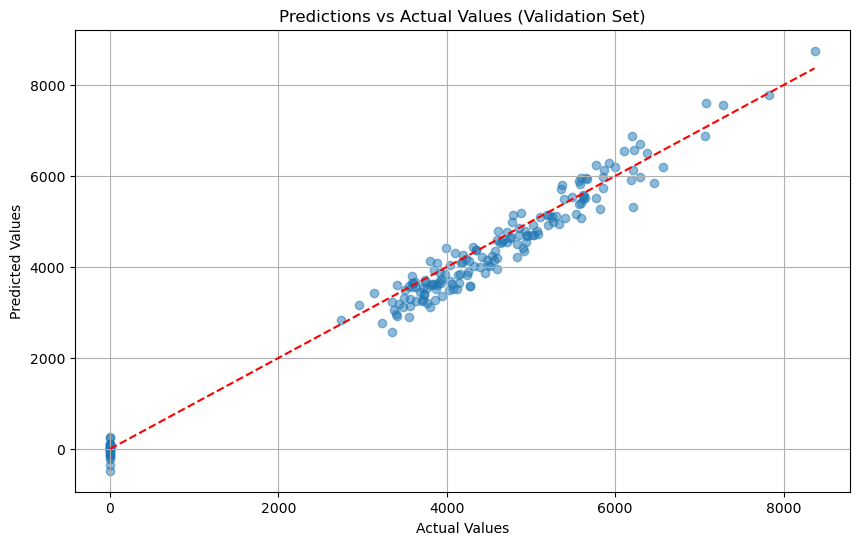

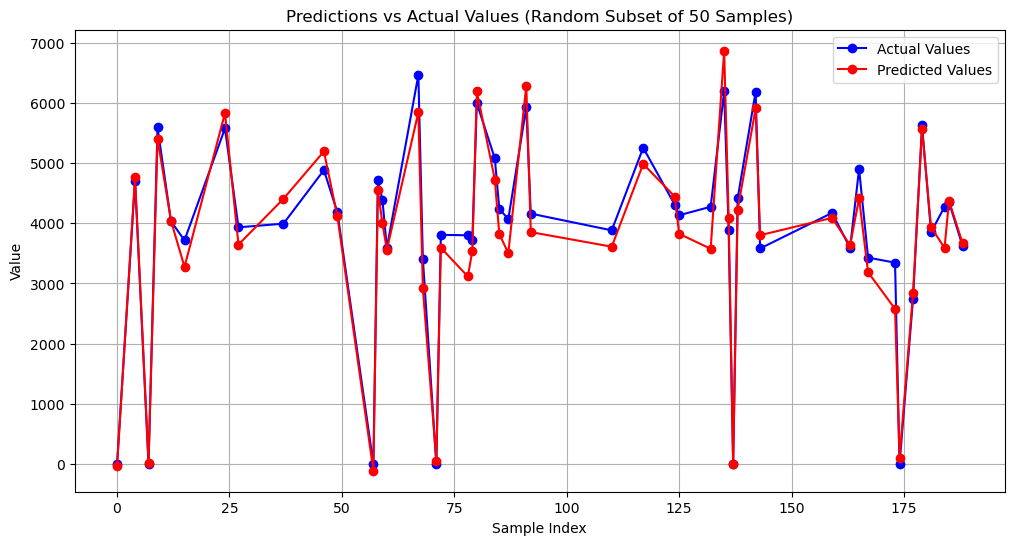

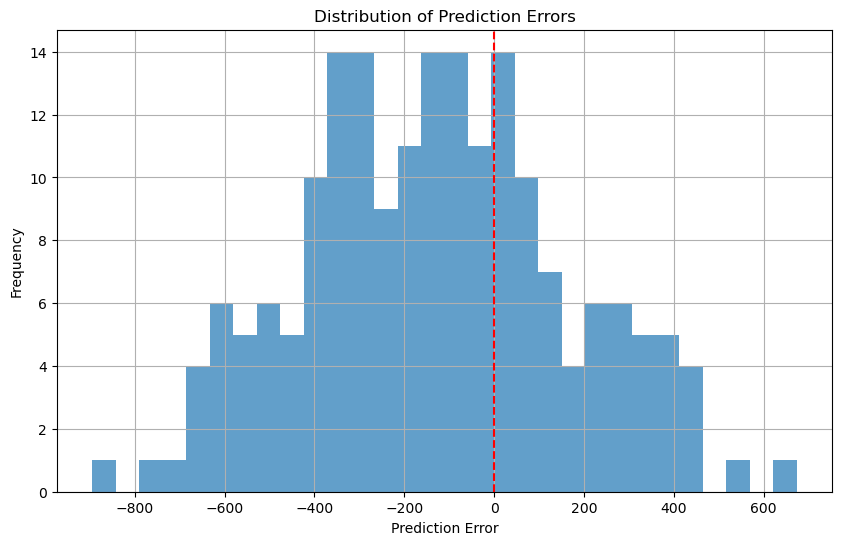

Error statistics:
Mean error: -132.304031
Median error: -126.653492
Standard deviation: 290.662308
Min error: -894.465850
Max error: 673.705524


In [23]:

# Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(val_y, test_predictions, alpha=0.5)
plt.plot([min(val_y), max(val_y)], [min(val_y), max(val_y)], 'r--')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values (Validation Set)')
plt.grid(True)
plt.show()

# Take a random subset for a clearer comparison (e.g., 50 samples)
subset_size = 50
subset_indices = np.random.choice(len(val_y), subset_size, replace=False)
subset_indices = np.sort(subset_indices)  # Sort for clearer visualization

# Plot predictions vs actual for the subset
plt.figure(figsize=(12, 6))
plt.plot(subset_indices, val_y[subset_indices], 'b-o', label='Actual Values')
plt.plot(subset_indices, test_predictions[subset_indices], 'r-o', label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title(f'Predictions vs Actual Values (Random Subset of {subset_size} Samples)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and display error statistics
errors = test_predictions- val_y
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

# Calculate additional statistics
print(f"Error statistics:")
print(f"Mean error: {np.mean(errors):.6f}")
print(f"Median error: {np.median(errors):.6f}")
print(f"Standard deviation: {np.std(errors):.6f}")
print(f"Min error: {np.min(errors):.6f}")
print(f"Max error: {np.max(errors):.6f}")

In [24]:
train_df.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'a', '0', 'b', 'c', 'lag_1',
       'difference_1', 'lag_7', 'difference_7', 'lag_8', 'difference_8',
       'lag_14', 'difference_14', 'lag_15', 'difference_15', 'lag_21',
       'difference_21', 'lag_22', 'difference_22', 'lag_28', 'difference_28',
       'lag_29', 'difference_29', 'lag_36', 'difference_36', 'lag_43',
       'difference_43', 'lag_50', 'difference_50', 'lag_57', 'difference_57',
       'lag_64', 'difference_64', 'lag_71', 'difference_71', 'lag_78',
       'difference_78', 'lag_85', 'difference_85', 'lag_92', 'difference_92',
       'lag_100', 'difference_100', 'rolling_mean_7', 'rolling_std_7',
       'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28',
       'rolling_std_28', 'ewm_mean_10', 'ewm_std_10', 'ewm_mean_30',
       'ewm_std_30', 'ewm_mean_50', 'ewm_std_50', 'month_of_year',
       'is_weekend', 'day_sin', 'day_cos', 'month_sin', 